AInewsbot.ipynb

- Automate collecting daily AI news
- Open URLs of news sites specififed in `sources` dict (sources.yaml) using Selenium and Firefox
- Save HTML of each URL in htmldata directory
- Extract URLs from all files, create a pandas dataframe with url, title, src
- Use ChatGPT to filter only AI-related headlines by sending a prompt and formatted table of headlines
- Use SQLite to filter headlines previously seen 
- OPENAI_API_KEY should be in the environment or in a .env file
  
Alternative manual workflow to get HTML files if necessary
- Use Chrome, open e.g. Tech News bookmark folder, right-click and open all bookmarks in new window
- on Google News, make sure switch to AI tab
- on Google News, Feedly, Reddit, scroll to additional pages as desired
- Use SingleFile extension, 'save all tabs'
- Move files to htmldata directory
- Run lower part of notebook to process the data


1. initialize
2. fetch web pages
3. parse news story urls from web pages
4. filter headlines by relevance, not previously seen
5. perform topic analysis on headlines, and ordering by topic
6. summarize individual pages as bullet points
7. from bullet points, extract top 10 most common themes and stories of the day in order of importance
8. topic analysis of bullet points, categorize bullet points as belonging to particular themes
9. for each theme, make a summary and links. Here we want to iterate to improve summaries per specific criteria.
10. combine themes and send.

In [ ]:
import sys
del sys.modules['ainb_const']


In [1]:
from datetime import datetime
import os
import yaml
import dotenv
import sqlite3
import unicodedata
import json
from collections import Counter

import numpy as np
import pandas as pd

# import bs4
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin, urlparse

import multiprocessing
from concurrent.futures import ThreadPoolExecutor, as_completed
import asyncio
import aiohttp

from IPython.display import HTML, Image, Markdown, display
import markdown

import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

from openai import OpenAI

from ainb_const import (DOWNLOAD_DIR, LOWCOST_MODEL, MODEL,
                        SOURCECONFIG, FILTER_PROMPT, TOPIC_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT, FINAL_SUMMARY_PROMPT, TOP_CATEGORIES_PROMPT,
                        MAX_INPUT_TOKENS, MAX_OUTPUT_TOKENS, MAX_RETRIES, TEMPERATURE)
from ainb_utilities import (log, delete_files, filter_unseen_urls_db, insert_article, 
                            nearest_neighbor_sort, agglomerative_cluster_sort, traveling_salesman_sort_scipy,
                            send_gmail)
from ainb_webscrape import (get_driver, quit_drivers, launch_drivers, get_file, get_url, parse_file, 
                            get_og_tags, get_path_from_url, trimmed_href, process_source_queue_factory, 
                            process_url_queue_factory, DRIVERS)
from ainb_llm import paginate_df, process_pages, fetch_pages, fetch_openai, fetch_all_summaries, fetch_openai_summary, trunc_tokens


import asyncio
# need this to run async in jupyter since it already has an asyncio event loop running
import nest_asyncio
nest_asyncio.apply()


# Initialize

In [2]:
# OpenAI API module
client = OpenAI()

# Or can use REST API directly
API_URL = 'https://api.openai.com/v1/chat/completions'

headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Bearer {os.getenv("OPENAI_API_KEY")}',
}


In [3]:
#  load sources to scrape from sources.yaml
with open(SOURCECONFIG, "r") as stream:
    try:
        sources = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

log(f"Load {len(sources)} sources from {SOURCECONFIG}")

# make a reverse dict to map output file titles to source names
sources_reverse = {}
for k, v in sources.items():
    log(f"{k} -> {v['url']} -> {v['title']}.html")
    v['sourcename'] = k
    # map filename (title) to source name
    sources_reverse[v['title']] = k

log(f"Mapped {len(sources_reverse)} source page titles to sources")


2024-07-07 18:05:46,031 - AInewsbot - INFO - Load 17 sources from sources.yaml
2024-07-07 18:05:46,033 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-07-07 18:05:46,033 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/technology -> Bloomberg Technology - Bloomberg.html
2024-07-07 18:05:46,034 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Tech - Business Insider.html
2024-07-07 18:05:46,034 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> Technology.html
2024-07-07 18:05:46,034 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Discover and Add New Feedly AI Feeds.html
2024-07-07 18:0

20

In [4]:
sources

{'Ars Technica': {'include': ['^https://arstechnica.com/(\\w+)/(\\d+)/(\\d+)/'],
  'title': 'Ars Technica',
  'url': 'https://arstechnica.com/',
  'sourcename': 'Ars Technica'},
 'Bloomberg Tech': {'include': ['^https://www.bloomberg.com/news/'],
  'title': 'Bloomberg Technology - Bloomberg',
  'url': 'https://www.bloomberg.com/technology',
  'sourcename': 'Bloomberg Tech'},
 'Business Insider': {'exclude': ['^https://www.insider.com',
   '^https://www.passionfroot.me'],
  'title': 'Tech - Business Insider',
  'url': 'https://www.businessinsider.com/tech',
  'sourcename': 'Business Insider'},
 'FT Tech': {'include': ['https://www.ft.com/content/'],
  'title': 'Technology',
  'url': 'https://www.ft.com/technology',
  'sourcename': 'FT Tech'},
 'Feedly AI': {'exclude': ['^https://feedly.com',
   '^https://s1.feedly.com',
   '^https://blog.feedly.com'],
  'scroll': 5,
  'initial_sleep': 30,
  'title': 'Discover and Add New Feedly AI Feeds',
  'url': 'https://feedly.com/i/aiFeeds?options=e

In [5]:
sources_reverse


{'Ars Technica': 'Ars Technica',
 'Bloomberg Technology - Bloomberg': 'Bloomberg Tech',
 'Tech - Business Insider': 'Business Insider',
 'Technology': 'FT Tech',
 'Discover and Add New Feedly AI Feeds': 'Feedly AI',
 'Google News - Technology - Artificial intelligence': 'Google News',
 'Hacker News Page 1': 'Hacker News',
 'Hacker News Page 2': 'Hacker News 2',
 'HackerNoon - read, write and learn about any technology': 'HackerNoon',
 'Technology - The New York Times': 'NYT Tech',
 'top scoring links _ multi': 'Reddit',
 'Techmeme': 'Techmeme',
 'The Register_ Enterprise Technology News and Analysis': 'The Register',
 'Artificial Intelligence - The Verge': 'The Verge',
 'AI News _ VentureBeat': 'VentureBeat',
 'Technology - WSJ.com': 'WSJ Tech',
 'Technology - The Washington Post': 'WaPo Tech'}

In [6]:
# determine files already in htmldata directory
# List all paths in the directory matching today's date
nfiles = 50
files = [os.path.join(DOWNLOAD_DIR, file)
         for file in os.listdir(DOWNLOAD_DIR)]

# Get the current date
today = datetime.now()
year, month, day = today.year, today.month, today.day
datestr = datetime.now().strftime("%m_%d_%Y")

# filter files only
files = [file for file in files if os.path.isfile(file)]

# Sort files by modification time and take top 50
files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
file = files[:nfiles]

# filter files by with today's date ending in .html
files = [
    file for file in files if datestr in file and file.endswith(".html")]
log(len(files))
for file in files:
    log(file)

saved_pages = []
for file in files:
    filename = os.path.basename(file)
    # locate date like '01_14_2024' in filename
    position = filename.find(" (" + datestr)
    basename = filename[:position]
    # match to source name
    sourcename = sources_reverse.get(basename)
    if sourcename is None:
        log(f"Skipping {basename}, no sourcename metadata")
        continue
    sources[sourcename]['latest'] = file
    saved_pages.append((sourcename, file))

2024-07-07 18:05:55,176 - AInewsbot - INFO - 17
2024-07-07 18:05:55,177 - AInewsbot - INFO - htmldata/Technology - The Washington Post (07_07_2024 06_03_04 PM).html
2024-07-07 18:05:55,177 - AInewsbot - INFO - htmldata/Technology - WSJ.com (07_07_2024 06_03_02 PM).html
2024-07-07 18:05:55,178 - AInewsbot - INFO - htmldata/AI News _ VentureBeat (07_07_2024 06_03_00 PM).html
2024-07-07 18:05:55,178 - AInewsbot - INFO - htmldata/Discover and Add New Feedly AI Feeds (07_07_2024 06_02_53 PM).html
2024-07-07 18:05:55,179 - AInewsbot - INFO - htmldata/Artificial Intelligence - The Verge (07_07_2024 06_02_51 PM).html
2024-07-07 18:05:55,179 - AInewsbot - INFO - htmldata/top scoring links _ multi (07_07_2024 06_02_49 PM).html
2024-07-07 18:05:55,179 - AInewsbot - INFO - htmldata/The Register_ Enterprise Technology News and Analysis (07_07_2024 06_02_40 PM).html
2024-07-07 18:05:55,180 - AInewsbot - INFO - htmldata/Techmeme (07_07_2024 06_02_30 PM).html
2024-07-07 18:05:55,180 - AInewsbot - INFO

# Save source pages

In [ ]:
# Fetch HTML files from sources

# empty download directory
delete_files(DOWNLOAD_DIR)

# save each file specified from sources
num_browsers = 3
log(f"Saving HTML files using {num_browsers} browsers")

# Create a queue for multiprocessing and populate it 
queue = multiprocessing.Queue()
for item in sources.values():
    queue.put(item)
    
# Function to take the queue and pop entries off and process until none are left
# lets you create an array of functions with different args
callable = process_source_queue_factory(queue)

saved_pages = launch_drivers(num_browsers, callable)


In [ ]:
log(f"Saved {len(saved_pages)} pages")

print(len(saved_pages))
for sourcename, page in saved_pages:
    sources[sourcename]['latest'] = page
    log("{sourcename} -> {page}")
    

# Extract news URLs from saved pages

In [13]:
# Parse news URLs and titles from downloaded HTML files
log("Parsing html files")
all_urls = []
for sourcename, filename in saved_pages:
    log(sourcename +' -> ' + filename)
    log(f"{sourcename}", "parse loop")
    links = parse_file(sources[sourcename])
    log(f"{len(links)} links found", "parse loop")
    all_urls.extend(links)

log(f"found {len(all_urls)} links", "parse loop")

# make a pandas dataframe of all the links found
orig_df = (
    pd.DataFrame(all_urls)
    .groupby("url")
    .first()
    .reset_index()
    .sort_values("src")[["src", "title", "url"]]
    .reset_index(drop=True)
    .reset_index(drop=False)
    .rename(columns={"index": "id"})
)
orig_df.head()


2024-07-07 18:12:54,691 - AInewsbot - INFO - Parsing html files
2024-07-07 18:12:54,694 - AInewsbot - INFO - WaPo Tech -> htmldata/Technology - The Washington Post (07_07_2024 06_03_04 PM).html
2024-07-07 18:12:54,695 - AInewsbot - INFO - parse loop - WaPo Tech
2024-07-07 18:12:54,719 - AInewsbot - INFO - parse_file - found 159 raw links
2024-07-07 18:12:54,721 - AInewsbot - INFO - parse_file - found 21 filtered links
2024-07-07 18:12:54,722 - AInewsbot - INFO - parse loop - 21 links found
2024-07-07 18:12:54,722 - AInewsbot - INFO - WSJ Tech -> htmldata/Technology - WSJ.com (07_07_2024 06_03_02 PM).html
2024-07-07 18:12:54,723 - AInewsbot - INFO - parse loop - WSJ Tech
2024-07-07 18:12:54,758 - AInewsbot - INFO - parse_file - found 495 raw links
2024-07-07 18:12:54,765 - AInewsbot - INFO - parse_file - found 8 filtered links
2024-07-07 18:12:54,765 - AInewsbot - INFO - parse loop - 8 links found
2024-07-07 18:12:54,765 - AInewsbot - INFO - VentureBeat -> htmldata/AI News _ VentureBeat

,id,src,title,url
0,0,Ars Technica,"ITER fusion reactor to see further delays, wit...",https://arstechnica.com/science/2024/07/iters-...
1,1,Ars Technica,Alaska’s top-heavy glaciers are approaching an...,https://arstechnica.com/science/2024/07/alaska...
2,2,Ars Technica,What we know about microdosing candy illnesses...,https://arstechnica.com/science/2024/07/author...
3,3,Ars Technica,Can’t stop your cat from scratching the furnit...,https://arstechnica.com/science/2024/07/cant-s...
4,4,Ars Technica,Egalitarian oddity found in the Neolithic,https://arstechnica.com/science/2024/07/egalit...


In [14]:
# # extracts all links from history where isAI=1
# # useful for training dimensionality reduction
# conn = sqlite3.connect('articles.db')
# c = conn.cursor()

# query = "select * from news_articles where isAI=1 order by id"
# ai_history_df = pd.read_sql_query(query, conn)
# ai_history_df

,id,src,title,url,isAI,article_date,timestamp
0,12,Bloomberg Tech,"Xperi Holder Rubric Pushes for Cost Cuts, AI U...",https://www.bloomberg.com/news/articles/2024-0...,1,2024-01-24,None
1,43,Bloomberg Tech,Apple Dials Back Car’s Self-Driving Features a...,https://www.bloomberg.com/news/articles/2024-0...,1,2024-01-24,None
2,46,Bloomberg Tech,AIAI Startup Strikes $200 Million SPAC Deal to...,https://www.bloomberg.com/news/articles/2024-0...,1,2024-01-24,None
3,61,Bloomberg Tech,"TechnologySAP Plans 8,000-Job Restructuring to...",https://www.bloomberg.com/news/articles/2024-0...,1,2024-01-24,None
4,64,Bloomberg Tech,TechnologyNvidia Alum Snags Funding for Startu...,https://www.bloomberg.com/news/articles/2024-0...,1,2024-01-24,None
...,...,...,...,...,...,...,...
50320,123988,Reddit,GPT-4o vs Gemini 1.5 Pro vs Claude 3.5 Sonnet....,https://www.reddit.com/r/ChatGPT/comments/1dxm...,1,2024-07-07,2024-07-07 17:02:11
50321,124002,The Register,A friendly guide to containerization for AI wo...,https://www.theregister.com/2024/07/07/contain...,1,2024-07-07,2024-07-07 17:02:11
50322,124006,The Verge,Apple Intelligence and a better Siri may be co...,https://www.theverge.com/2024/7/7/24193619/app...,1,2024-07-07,2024-07-07 17:02:11
50323,124007,The Verge,Meta AI may get more collaborative in WhatsApp...,https://www.theverge.com/2024/7/7/24193680/met...,1,2024-07-07,2024-07-07 17:02:11


In [15]:
# # clean up sqlite database if you want to rerun the job from a given point
# conn.execute(f"delete from news_articles where timestamp > '2024-07-07 12:00'")
# # conn.execute(f"delete from news_articles where id > 220230")
# # Committing the changes
# conn.commit()

# # Close the connection
# conn.close()


# Filter URLs to new AI headlines only

In [16]:
# filter urls we've already seen in previous runs and saved in SQLite
filtered_df = filter_unseen_urls_db(orig_df)


2024-07-07 18:13:47,091 - AInewsbot - INFO - Existing URLs: 123673
2024-07-07 18:13:47,134 - AInewsbot - INFO - New URLs: 373


In [17]:
# use chatgpt to filter AI-related headlines using a prompt to OpenAI
print(FILTER_PROMPT)



You will act as a research assistant to categorize news articles based on their relevance
to the topic of artificial intelligence (AI). You will closely read the title of each story
to determine if it is primarily about AI based on the semanting meaning of the title and
the keywords and entities mentioned. The input headlines and outptu classifications will
be formatted as JSON objects.

Input Specification:
You will receive a list of news headlines formatted as JSON objects.
Each object will include an 'id' and a 'title'. For instance:
[{'id': 97, 'title': 'AI to predict dementia, detect cancer'},
 {'id': 103,'title': 'Figure robot learns to make coffee by watching humans for 10 hours'},
 {'id': 103,'title': 'Baby trapped in refrigerator eats own foot'},
 {'id': 210,'title': 'ChatGPT removes, then reinstates a summarization assistant without explanation.'},
 {'id': 298,'title': 'The 5 most interesting PC monitors from CES 2024'},
 ]

Classification Criteria:
Classify each story based

In [18]:
# make pages that fit in a reasonably sized (MAXPAGELEN or MAX_INPUT_TOKENS) prompt
pages = paginate_df(filtered_df)
log(f"Paginated {len(pages)} pages")


2024-07-07 18:14:04,194 - AInewsbot - INFO - Paginated 8 pages


20

In [19]:
# use REST API directly. OpenAI python API doesn't support concurrent requests from a single client
# this runs fast with async aiohttp and on gpt-3.5 (15 seconds vs 2 minutes synchronously with gpt-4o)
# the old API supported submitting multiple payloads in a single completion request
# current API supports a slow 'batch' submission https://platform.openai.com/docs/guides/rate-limits/usage-tiers
# there is a more complex example here - https://github.com/openai/openai-cookbook/blob/main/examples/api_request_parallel_processor.py

log("start classify")
enriched_urls = asyncio.run(fetch_pages(pages, prompt=FILTER_PROMPT))
log("end classify")

enriched_df = pd.DataFrame(enriched_urls)
print(len(enriched_df))
log("isAI", len(enriched_df.loc[enriched_df["isAI"]]))
log("not isAI", len(enriched_df.loc[~enriched_df["isAI"]]))
enriched_df.head()


2024-07-07 18:14:06,895 - AInewsbot - INFO - start classify
2024-07-07 18:14:06,897 - AInewsbot - INFO - sent 50 items 
2024-07-07 18:14:06,921 - AInewsbot - INFO - sent 50 items 
2024-07-07 18:14:06,922 - AInewsbot - INFO - sent 50 items 
2024-07-07 18:14:06,922 - AInewsbot - INFO - sent 50 items 
2024-07-07 18:14:06,923 - AInewsbot - INFO - sent 50 items 
2024-07-07 18:14:06,923 - AInewsbot - INFO - sent 50 items 
2024-07-07 18:14:06,924 - AInewsbot - INFO - sent 50 items 
2024-07-07 18:14:06,924 - AInewsbot - INFO - sent 23 items 
2024-07-07 18:14:10,280 - AInewsbot - INFO - got dict with 23 items 
2024-07-07 18:14:12,556 - AInewsbot - INFO - got dict with 50 items 
2024-07-07 18:14:13,377 - AInewsbot - INFO - got dict with 50 items 
2024-07-07 18:14:13,529 - AInewsbot - INFO - got dict with 50 items 
2024-07-07 18:14:13,884 - AInewsbot - INFO - got dict with 50 items 
2024-07-07 18:14:13,886 - AInewsbot - INFO - got dict with 50 items 
2024-07-07 18:14:14,475 - AInewsbot - INFO - g

373


,id,isAI
0,26,False
1,97,False
2,136,False
3,146,False
4,149,False


In [20]:
# merge returned df with isAI column into original df on id column
merged_df = pd.merge(filtered_df, enriched_df, on="id", how="outer")
merged_df['date'] = datetime.now().date()
merged_df.head()


,id,src,title,url,isAI,date
0,26,Ars Technica,Review: Catching up withDoctor Whoand Ncuti Ga...,https://arstechnica.com/culture/2024/07/review...,False,2024-07-07
1,97,Business Insider,Card skimmers are hard to spot and on the rise...,https://www.businessinsider.com/how-to-spot-ca...,False,2024-07-07
2,136,FT Tech,‘People are addicted to escape’: psychoactive ...,https://www.ft.com/content/f1bcbef0-a02d-446c-...,False,2024-07-07
3,146,FT Tech,Ask Shrimsley: is wild hair the sign of a bad ...,https://www.ft.com/content/b3996347-1284-4198-...,False,2024-07-07
4,149,FT Tech,Turkey divided over mass cull of 4mn street dogs,https://www.ft.com/content/ad27bda3-a533-4621-...,False,2024-07-07


In [21]:
# should be empty, shouldn't get back rows that don't match to existing
log(f"Unmatched response rows: {len(merged_df.loc[merged_df['src'].isna()])}")
# should be empty, should get back all rows from orig
log(f"Unmatched source rows: {len(merged_df.loc[merged_df['isAI'].isna()])}")


2024-07-07 18:14:20,279 - AInewsbot - INFO - Unmatched response rows: 0
2024-07-07 18:14:20,282 - AInewsbot - INFO - Unmatched source rows: 0


20

In [22]:
# update SQLite database with all seen URLs
conn = sqlite3.connect('articles.db')
cursor = conn.cursor()

for row in merged_df.itertuples():
    insert_article(conn, cursor, row.src, row.title,
                   row.url, row.isAI, row.date)


In [23]:
# keep headlines that are related to AI
AIdf = merged_df.loc[merged_df["isAI"]==1] \
    .reset_index(drop=True)  \
    .reset_index()  \
    .drop(columns=["id"])  \
    .rename(columns={'index': 'id'})

log(f"Found {len(AIdf)} AI headlines")
AIdf

2024-07-07 18:14:26,913 - AInewsbot - INFO - Found 123 AI headlines


,id,src,title,url,isAI,date
0,0,Feedly AI,Figma disables AI-powered 'Make Design' featur...,https://appleinsider.com/articles/24/07/07/fig...,True,2024-07-07
1,1,Feedly AI,Meta AI may get more collaborative in WhatsApp...,https://www.theverge.com/2024/7/7/24193680/met...,True,2024-07-07
2,2,Feedly AI,Apple Intelligence and a better Siri may be co...,https://www.theverge.com/2024/7/7/24193619/app...,True,2024-07-07
3,3,Feedly AI,CIOs’ concerns over generative AI echo those o...,https://techcrunch.com/2024/07/07/cios-concern...,True,2024-07-07
4,4,Feedly AI,Netflix vs. Disney? We asked ChatGPT-4o which ...,https://finbold.com/netflix-vs-disney-we-asked...,True,2024-07-07
...,...,...,...,...,...,...
118,118,The Register,A friendly guide to containerization for AI wo...,https://www.theregister.com/2024/07/07/contain...,True,2024-07-07
119,119,The Verge,Police pulled over a Waymo car for driving in ...,https://www.theverge.com/2024/7/6/24193094/pho...,True,2024-07-07
120,120,The Verge,When AI models are past their prime.,https://www.theverge.com/2024/7/7/24193768/usi...,True,2024-07-07
121,121,VentureBeat,"In the age of AI, the role of the CAIO will be...",https://venturebeat.com/ai/in-the-age-of-ai-th...,True,2024-07-07


In [24]:
# map title to ascii characters to avoid some dupes with e.g. different quote symbols

def unicode_to_ascii(input_string):
    # Normalize the Unicode string to NFKD form
    normalized_string = unicodedata.normalize('NFKD', input_string)
    
    # Encode to ASCII bytes, ignoring characters that cannot be converted
    ascii_bytes = normalized_string.encode('ascii', 'ignore')
    
    # Convert bytes back to a string
    ascii_string = ascii_bytes.decode('ascii')
    
    return ascii_string

AIdf['title'] = AIdf['title'].apply(unicode_to_ascii)


In [25]:
# dedupe identical headlines
AIdf['title_clean'] = AIdf['title'].map(lambda s: "".join(s.split()))
AIdf = AIdf.sort_values("src") \
    .groupby("title_clean") \
    .first() \
    .reset_index(drop=True) \
    .drop(columns=['id']) \
    .reset_index() \
    .rename(columns={'index': 'id'})

log(f"Found {len(AIdf)} unique AI headlines")


2024-07-07 18:14:33,006 - AInewsbot - INFO - Found 112 unique AI headlines


20

# Semantic sort

In [26]:
# use embeddings to sort headlines by semantical similarity
log(f"Fetching embeddings for {len(AIdf)} headlines")
embedding_model = 'text-embedding-3-large'
response = client.embeddings.create(input=AIdf['title'].tolist(),
                                    model=embedding_model)
embedding_df = pd.DataFrame([e.model_dump()['embedding'] for e in response.data])

sorted_indices = agglomerative_cluster_sort(embedding_df)
AIdf = AIdf.iloc[sorted_indices] \
    .reset_index(drop=True) \
    .reset_index() \
    .drop(columns=["id"]) \
    .rename(columns={'index': 'id'})

# sort embedding_df to match
embedding_df = embedding_df[sorted_indices]

AIdf


2024-07-07 18:14:37,813 - AInewsbot - INFO - Fetching embeddings for 112 headlines
2024-07-07 18:14:38,272 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


,id,src,title,url,isAI,date
0,0,Feedly AI,5 big analyst AI moves: Nvidia downgraded on l...,https://www.investing.com/news/stock-market-ne...,True,2024-07-07
1,1,Feedly AI,Two risks to the AI tech rally,https://au.investing.com/news/stock-market-new...,True,2024-07-07
2,2,Google News,45% of Warren Buffett's $398 Billion Portfolio...,https://news.google.com/articles/CBMiW2h0dHBzO...,True,2024-07-07
3,3,Google News,Broadcom: An Essential Company For AI Investor...,https://news.google.com/articles/CBMiV2h0dHBzO...,True,2024-07-07
4,4,Google News,"Advanced Micro Devices, Inc. (AMD): Hedge Fund...",https://news.google.com/articles/CBMiTGh0dHBzO...,True,2024-07-07
...,...,...,...,...,...,...
107,107,Reddit,"James Muldoon, Mark Graham and Callum Cant: AI...",https://www.reddit.com/r/technology/comments/1...,True,2024-07-07
108,108,Reddit,Meet Mercy and Anita the African workers driv...,https://www.reddit.com/r/technology/comments/1...,True,2024-07-07
109,109,Feedly AI,Figma disables AI-powered 'Make Design' featur...,https://appleinsider.com/articles/24/07/07/fig...,True,2024-07-07
110,110,Google News,Microsoft's AI CEO: Web Content (Without a Rob...,https://news.google.com/articles/CBMifmh0dHBzO...,True,2024-07-07


# Save and email headlines


In [27]:
html_str = ""
for row in AIdf.itertuples():
    log(f"[{row.Index}. {row.title} - {row.src}]({row.url})")
    html_str += f'{row.Index}.<a href="{row.url}">{row.title} - {row.src}</a><br />\n'


2024-07-07 18:14:48,260 - AInewsbot - INFO - [0. 5 big analyst AI moves: Nvidia downgraded on limited further upside - Feedly AI](https://www.investing.com/news/stock-market-news/5-big-analyst-ai-moves-nvidia-downgraded-on-limited-further-upside-3509545)
2024-07-07 18:14:48,262 - AInewsbot - INFO - [1. Two risks to the AI tech rally - Feedly AI](https://au.investing.com/news/stock-market-news/two-risks-to-the-ai-tech-rally-432SI-3330078)
2024-07-07 18:14:48,262 - AInewsbot - INFO - [2. 45% of Warren Buffett's $398 Billion Portfolio Is Invested in 3 Artificial Intelligence (AI) Stocks - Google News](https://news.google.com/articles/CBMiW2h0dHBzOi8vd3d3LmZvb2wuY29tL2ludmVzdGluZy8yMDI0LzA3LzA3LzQ1LXdhcnJlbi1idWZmZXR0cy0zOTgtYmlsbGlvbi1pcy1pbi0zLWFpLXN0b2Nrcy_SAQA)
2024-07-07 18:14:48,263 - AInewsbot - INFO - [3. Broadcom: An Essential Company For AI Investors (NASDAQ:AVGO) - Google News](https://news.google.com/articles/CBMiV2h0dHBzOi8vc2Vla2luZ2FscGhhLmNvbS9hcnRpY2xlLzQ3MDE4MDEtYnJvYWRjb

2024-07-07 18:14:48,275 - AInewsbot - INFO - [27. HowArtificial IntelligenceCan Make Our Smart Homes, Smarter - Feedly AI](https://hackernoon.com/how-artificial-intelligence-can-make-our-smart-homes-smarter)
2024-07-07 18:14:48,275 - AInewsbot - INFO - [28. Personalized AI Farming Assistants - Google News](https://news.google.com/articles/CBMiLWh0dHBzOi8vd3d3LnRyZW5kaHVudGVyLmNvbS90cmVuZHMvYWktZmFybWluZ9IBMWh0dHBzOi8vd3d3LnRyZW5kaHVudGVyLmNvbS9hbXAvdHJlbmRzL2FpLWZhcm1pbmc)
2024-07-07 18:14:48,276 - AInewsbot - INFO - [29. AI Can Learn Uses for Modern-Day Agriculture - Google News](https://news.google.com/articles/CBMieWh0dHBzOi8vd3d3LmttYWxhbmQuY29tL2FnL2FpLWNhbi1sZWFybi11c2VzLWZvci1tb2Rlcm4tZGF5LWFncmljdWx0dXJlL2FydGljbGVfYWY2Zjc1MzYtM2FlNi0xMWVmLWE2OTYtNGY5ZGJlYWZiZDBmLmh0bWzSAQA)
2024-07-07 18:14:48,276 - AInewsbot - INFO - [30. Artificial Intelligence is being trained to help all areas of agriculture - Google News](https://news.google.com/articles/CBMiX2h0dHBzOi8vd3d3LnJmZHR2LmNvbS

2024-07-07 18:14:48,284 - AInewsbot - INFO - [55. AI models that cost $1 billion to train are underway, $100 billion models coming  largest current models take 'only' $100 million to train: Anthropic CEO - Feedly AI](https://www.tomshardware.com/tech-industry/artificial-intelligence/ai-models-that-cost-dollar1-billion-to-train-are-in-development-dollar100-billion-models-coming-soon-largest-current-models-take-only-dollar100-million-to-train-anthropic-ceo)
2024-07-07 18:14:48,284 - AInewsbot - INFO - [56. Anthropic aims to fix one of the biggest problems in AI right now - Feedly AI](https://www.digitaltrends.com/computing/anthropic-ai-benchmark-funding-program/)
2024-07-07 18:14:48,284 - AInewsbot - INFO - [57. How Congress is fighting the rise of nonconsensual AI porn - Feedly AI](https://thehill.com/policy/technology/4752365-regulation-nonconsensual-explicit-deepfakes/)
2024-07-07 18:14:48,285 - AInewsbot - INFO - [58. Texas teen works to protect victims of non-consensual real and AI 

2024-07-07 18:14:48,289 - AInewsbot - INFO - [86. OpenAI's ChatGPT Mac App Was Saving Chats as Plain Text - Feedly AI](https://www.pcmag.com/news/openais-chatgpt-mac-app-was-saving-chats-as-plain-text)
2024-07-07 18:14:48,289 - AInewsbot - INFO - [87. How ChatGPT is Revolutionizing Customer Service in 2024 - Feedly AI](https://www.marktechpost.com/2024/07/07/how-chatgpt-is-revolutionizing-customer-service-in-2024/)
2024-07-07 18:14:48,289 - AInewsbot - INFO - [88. What are some creative or unexpected uses of ChatGPT youve discovered? - Reddit](https://www.reddit.com/r/ChatGPT/comments/1dxexjh/what_are_some_creative_or_unexpected_uses_of/)
2024-07-07 18:14:48,289 - AInewsbot - INFO - [89. GPT-4o vs Gemini 1.5 Pro vs Claude 3.5 Sonnet. Only Claude calls astrology bullshit right away - Reddit](https://www.reddit.com/r/ChatGPT/comments/1dxmm0u/gpt4o_vs_gemini_15_pro_vs_claude_35_sonnet_only/)
2024-07-07 18:14:48,290 - AInewsbot - INFO - [90. I learned how to use AI generative prompts with 

In [28]:
# save headlines
with open('headlines.html', 'w') as f:
    f.write(html_str)


In [29]:
# send mail
log("Sending headlines email")
subject = f'AI headlines {datetime.now().strftime("%H:%M:%S")}'
send_gmail(subject, html_str)


2024-07-07 18:14:53,062 - AInewsbot - INFO - Sending headlines email


# Save individual pages 

In [30]:
# fetch pages
# Create a queue for multiprocessing and populate it 
log("Queuing URLs for scraping")

queue = multiprocessing.Queue()
for row in AIdf.itertuples():
    queue.put((row.id, row.url, row.title))
    

2024-07-07 18:14:56,822 - AInewsbot - INFO - Queuing URLs for scraping


In [31]:
# scrape urls in queue asynchronously
num_browsers = 4

callable = process_url_queue_factory(queue)

log(f"fetching {len(AIdf)} pages using {num_browsers} browsers")
saved_pages = launch_drivers(num_browsers, callable)


2024-07-07 18:15:01,961 - AInewsbot - INFO - fetching 112 pages using 4 browsers
2024-07-07 18:15:01,964 - AInewsbot - INFO - get_driver - 78414 Initializing webdriver
2024-07-07 18:15:01,965 - AInewsbot - INFO - get_driver - 78414 Initializing webdriver
2024-07-07 18:15:01,965 - AInewsbot - INFO - get_driver - 78414 Initializing webdriver
2024-07-07 18:15:01,965 - AInewsbot - INFO - get_driver - 78414 Initializing webdriver
2024-07-07 18:15:22,159 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-07 18:15:22,159 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-07 18:15:22,159 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-07 18:15:22,160 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-07 18:15:22,160 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-07-07 18:15:22,160 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-07-07 18:15:22,161 - AInewsbot - INFO 

2024-07-07 18:16:58,551 - AInewsbot - INFO - get_url(Could ASML Be The Next Major AI Stock to Split Its Shares?) - Saving Could_ASML_Be_The_Next_Major_AI_Stock_to_Split_Its_Shares__20240707_181658.html as utf-8
2024-07-07 18:16:58,552 - AInewsbot - INFO - Processing https://www.fool.com/investing/2024/07/07/generative-ai-soar-2040-best-ai-stock-buy-now-nvda/
2024-07-07 18:16:58,552 - AInewsbot - INFO - get_url(https://www.fool.com/investing/2024/07/07/generative-ai-soar-2040-best-ai-stock-buy-now-nvda/) - starting get_files https://www.fool.com/investing/2024/07/07/generative-ai-soar-2040-best-ai-stock-buy-now-nvda/
2024-07-07 18:16:59,556 - AInewsbot - INFO - get_url(Better Artificial Intelligence (AI) Stock: Nvidia vs. AMD) - Saving Better_Artificial_Intelligence__AI__Stock__Nvidia_vs__AMD_20240707_181659.html as utf-8
2024-07-07 18:16:59,558 - AInewsbot - INFO - Processing https://finbold.com/netflix-vs-disney-we-asked-chatgpt-4o-which-stock-is-a-better-buy-for-2024/
2024-07-07 18:1

2024-07-07 18:17:28,684 - AInewsbot - INFO - get_url(AI's 'positive role' during Indian polls amidst deepfakes disinformation) - Saving AI_s__positive_role__during_Indian_polls_amidst_deepfakes_disinformation_20240707_181728.html as utf-8
2024-07-07 18:17:28,685 - AInewsbot - INFO - Processing https://news.google.com/articles/CBMiaWh0dHBzOi8vd3d3LndyZHcuY29tLzIwMjQvMDcvMDcvZ2VvcmdpYS1hcnRpZmljaWFsLWludGVsbGlnZW5jZS1wcm9ncmFtLXRlYWNoZXMta2lkcy1hYm91dC1iaWFzLXBvbGljaW5nL9IBeGh0dHBzOi8vd3d3LndyZHcuY29tLzIwMjQvMDcvMDcvZ2VvcmdpYS1hcnRpZmljaWFsLWludGVsbGlnZW5jZS1wcm9ncmFtLXRlYWNoZXMta2lkcy1hYm91dC1iaWFzLXBvbGljaW5nLz9vdXRwdXRUeXBlPWFtcA
2024-07-07 18:17:28,685 - AInewsbot - INFO - get_url(https://news.google.com/articles/CBMiaWh0dHBzOi8vd3d3LndyZHcuY29tLzIwMjQvMDcvMDcvZ2VvcmdpYS1hcnRpZmljaWFsLWludGVsbGlnZW5jZS1wcm9ncmFtLXRlYWNoZXMta2lkcy1hYm91dC1iaWFzLXBvbGljaW5nL9IBeGh0dHBzOi8vd3d3LndyZHcuY29tLzIwMjQvMDcvMDcvZ2VvcmdpYS1hcnRpZmljaWFsLWludGVsbGlnZW5jZS1wcm9ncmFtLXRlYWNoZXMta2lkcy1hYm91dC1iaWF

2024-07-07 18:17:50,190 - AInewsbot - INFO - get_url(Harnessing AI and technological advancements in the AEC industry for enhanced efficiency and productivity) - Saving Harnessing_AI_and_technological_advancements_in_the_AEC_industry_for_enhanced_efficiency_and_productivity_20240707_181750.html as utf-8
2024-07-07 18:17:50,191 - AInewsbot - INFO - Processing https://news.google.com/articles/CBMiLWh0dHBzOi8vd3d3LnRyZW5kaHVudGVyLmNvbS90cmVuZHMvYWktZmFybWluZ9IBMWh0dHBzOi8vd3d3LnRyZW5kaHVudGVyLmNvbS9hbXAvdHJlbmRzL2FpLWZhcm1pbmc
2024-07-07 18:17:50,192 - AInewsbot - INFO - get_url(https://news.google.com/articles/CBMiLWh0dHBzOi8vd3d3LnRyZW5kaHVudGVyLmNvbS90cmVuZHMvYWktZmFybWluZ9IBMWh0dHBzOi8vd3d3LnRyZW5kaHVudGVyLmNvbS9hbXAvdHJlbmRzL2FpLWZhcm1pbmc) - starting get_files https://news.google.com/articles/CBMiLWh0dHBzOi8vd3d3LnRyZW5kaHVudGVyLmNvbS90cmVuZHMvYWktZmFybWluZ9IBMWh0dHBzOi8vd3d3LnRyZW5kaHVudGVyLmNvbS9hbXAvdHJlbmRzL2FpLWZhcm1pbmc
2024-07-07 18:17:52,332 - AInewsbot - INFO - get_url(5 Be

2024-07-07 18:18:10,949 - AInewsbot - INFO - get_url(https://news.google.com/articles/CBMiRGh0dHBzOi8vd3d3LmV1cmFzaWFudGltZXMuY29tL3VzLWNoaW5hLWNvbmZsaWN0LXVzYWYtcGxhbnMtMTAwMC02dGgv0gFEaHR0cHM6Ly93d3cuZXVyYXNpYW50aW1lcy5jb20vdXMtY2hpbmEtY29uZmxpY3QtdXNhZi1wbGFucy0xMDAwLTZ0aC8) - starting get_files https://news.google.com/articles/CBMiRGh0dHBzOi8vd3d3LmV1cmFzaWFudGltZXMuY29tL3VzLWNoaW5hLWNvbmZsaWN0LXVzYWYtcGxhbnMtMTAwMC02dGgv0gFEaHR0cHM6Ly93d3cuZXVyYXNpYW50aW1lcy5jb20vdXMtY2hpbmEtY29uZmxpY3QtdXNhZi1wbGFucy0xMDAwLTZ0aC8
2024-07-07 18:18:13,490 - AInewsbot - INFO - get_url(We ask AI to explain why we struggle with solving the climate crisis) - Saving We_ask_AI_to_explain_why_we_struggle_with_solving_the_climate_crisis_20240707_181813.html as utf-8
2024-07-07 18:18:13,493 - AInewsbot - INFO - Processing https://news.google.com/articles/CBMiiwFodHRwczovL3d3dy5yZXV0ZXJzLmNvbS90ZWNobm9sb2d5L2FydGlmaWNpYWwtaW50ZWxsaWdlbmNlL2Vsb24tbXVzay1leHBlY3RlZC1tYWtlLXNwZWVjaC1vcGVuaW5nLXNoYW5naGFpcy13b3J

2024-07-07 18:18:34,922 - AInewsbot - INFO - get_url(https://news.google.com/articles/CBMiwAFodHRwczovL3d3dy5pbnRlbGxpZ2VudGNpby5jb20vZXUvMjAyNC8wNy8wNS93aGF0LXN0cmF0ZWdpZXMtY2FuLWJ1c2luZXNzLWFuZC10ZWNobm9sb2d5LWxlYWRlcnMtYWRvcHQtdG8tZWZmZWN0aXZlbHktYmFsYW5jZS1pbW1lZGlhdGUtYWktaW52ZXN0bWVudHMtd2l0aC1sb25nLXRlcm0tc3VzdGFpbmFiaWxpdHktb2JqZWN0aXZlcy_SAQA) - starting get_files https://news.google.com/articles/CBMiwAFodHRwczovL3d3dy5pbnRlbGxpZ2VudGNpby5jb20vZXUvMjAyNC8wNy8wNS93aGF0LXN0cmF0ZWdpZXMtY2FuLWJ1c2luZXNzLWFuZC10ZWNobm9sb2d5LWxlYWRlcnMtYWRvcHQtdG8tZWZmZWN0aXZlbHktYmFsYW5jZS1pbW1lZGlhdGUtYWktaW52ZXN0bWVudHMtd2l0aC1sb25nLXRlcm0tc3VzdGFpbmFiaWxpdHktb2JqZWN0aXZlcy_SAQA
2024-07-07 18:18:36,195 - AInewsbot - INFO - get_url(China's homegrown AI models are expanding) - Saving China_s_homegrown_AI_models_are_expanding_20240707_181836.html as utf-8
2024-07-07 18:18:36,198 - AInewsbot - INFO - Processing https://news.google.com/articles/CCAiC1pGbWFweFlCYWZZmAEB
2024-07-07 18:18:36,198 - AInews

2024-07-07 18:19:06,049 - AInewsbot - INFO - Processing https://www.digitaltrends.com/computing/anthropic-ai-benchmark-funding-program/
2024-07-07 18:19:06,050 - AInewsbot - INFO - get_url(https://www.digitaltrends.com/computing/anthropic-ai-benchmark-funding-program/) - starting get_files https://www.digitaltrends.com/computing/anthropic-ai-benchmark-funding-program/
2024-07-07 18:19:07,130 - AInewsbot - INFO - get_url(When AI models are past their prime.) - Saving When_AI_models_are_past_their_prime__20240707_181907.html as utf-8
2024-07-07 18:19:07,131 - AInewsbot - INFO - Processing https://thehill.com/policy/technology/4752365-regulation-nonconsensual-explicit-deepfakes/
2024-07-07 18:19:07,131 - AInewsbot - INFO - get_url(https://thehill.com/policy/technology/4752365-regulation-nonconsensual-explicit-deepfakes/) - starting get_files https://thehill.com/policy/technology/4752365-regulation-nonconsensual-explicit-deepfakes/
2024-07-07 18:19:08,665 - AInewsbot - INFO - get_url(A for

2024-07-07 18:19:31,631 - AInewsbot - INFO - get_url(https://www.reddit.com/r/ChatGPT/comments/1dxf72r/next_level_image_gen_i_can_see_why_artists_are/) - starting get_files https://www.reddit.com/r/ChatGPT/comments/1dxf72r/next_level_image_gen_i_can_see_why_artists_are/
2024-07-07 18:19:33,313 - AInewsbot - INFO - get_url(Real criminals, fake victims: how chatbots are being deployed in the global fight against phone scammers) - Saving Real_criminals__fake_victims__how_chatbots_are_being_deployed_in_the_global_fight_against_phone_scammers_20240707_181933.html as utf-8
2024-07-07 18:19:33,314 - AInewsbot - INFO - Processing https://www.forbes.com/sites/lanceeliot/2024/07/07/trend-of-hurkle-durkling-in-bed-gets-boosted-to-high-form-via-modern-generative-ai/
2024-07-07 18:19:33,314 - AInewsbot - INFO - get_url(https://www.forbes.com/sites/lanceeliot/2024/07/07/trend-of-hurkle-durkling-in-bed-gets-boosted-to-high-form-via-modern-generative-ai/) - starting get_files https://www.forbes.com/si

2024-07-07 18:20:05,428 - AInewsbot - INFO - Processing https://www.reddit.com/r/technology/comments/1dx7p3r/perseverance_triumphs_how_sherloc_was_brought/
2024-07-07 18:20:05,429 - AInewsbot - INFO - get_url(https://www.reddit.com/r/technology/comments/1dx7p3r/perseverance_triumphs_how_sherloc_was_brought/) - starting get_files https://www.reddit.com/r/technology/comments/1dx7p3r/perseverance_triumphs_how_sherloc_was_brought/
2024-07-07 18:20:09,689 - AInewsbot - INFO - get_url(Video: Figure 01 humanoid trains for its first job assembling BMWs) - Saving Video__Figure_01_humanoid_trains_for_its_first_job_assembling_BMWs_20240707_182009.html as utf-8
2024-07-07 18:20:09,691 - AInewsbot - INFO - Processing https://www.reddit.com/r/tech/comments/1dxeodw/400_robotic_surgeries_98_survival_rate_saudi/
2024-07-07 18:20:09,691 - AInewsbot - INFO - get_url(https://www.reddit.com/r/tech/comments/1dxeodw/400_robotic_surgeries_98_survival_rate_saudi/) - starting get_files https://www.reddit.com/r/

2024-07-07 18:20:38,159 - AInewsbot - INFO - get_url(OpenAI's ChatGPT Mac App Was Saving Chats as Plain Text) - Saving OpenAI_s_ChatGPT_Mac_App_Was_Saving_Chats_as_Plain_Text_20240707_182038.html as utf-8
2024-07-07 18:20:38,161 - AInewsbot - INFO - Processing https://www.techradar.com/computing/websites-apps/i-learned-how-to-use-ai-generative-prompts-with-this-one-app
2024-07-07 18:20:38,162 - AInewsbot - INFO - get_url(https://www.techradar.com/computing/websites-apps/i-learned-how-to-use-ai-generative-prompts-with-this-one-app) - starting get_files https://www.techradar.com/computing/websites-apps/i-learned-how-to-use-ai-generative-prompts-with-this-one-app
2024-07-07 18:20:42,941 - AInewsbot - INFO - get_url(How ChatGPT is Revolutionizing Customer Service in 2024) - Saving How_ChatGPT_is_Revolutionizing_Customer_Service_in_2024_20240707_182042.html as utf-8
2024-07-07 18:20:42,943 - AInewsbot - INFO - Processing https://news.google.com/articles/CBMiXmh0dHBzOi8vdmVudHVyZWJlYXQuY29tL

2024-07-07 18:21:03,603 - AInewsbot - INFO - get_url(https://www.theverge.com/2024/7/7/24193619/apple-intelligence-better-siri-ios-18-4-spring-public-launch) - starting get_files https://www.theverge.com/2024/7/7/24193619/apple-intelligence-better-siri-ios-18-4-spring-public-launch
2024-07-07 18:21:05,176 - AInewsbot - INFO - get_url(Apple's AI Shift, Board Observer Role At OpenAI, Extended iPhone Settlement Deadline, And AI Partnership With Google: This Week In Appleverse - Alphabet (NASDAQ:GOOG), Apple (NASDAQ:AAPL)) - Saving Apple_s_AI_Shift__Board_Observer_Role_At_OpenAI__Extended_iPhone_Settlement_Deadline__And_AI_Partnership_With_Google__This_Week_In_Appleverse_-_Alphabet__NASDAQ_GOOG___Apple__NASDAQ_AAPL__20240707_182105.html as utf-8
2024-07-07 18:21:05,178 - AInewsbot - INFO - Processing https://news.google.com/articles/CBMiQGh0dHBzOi8vd3d3LmFuZHJvaWRhdXRob3JpdHkuY29tL3NtYWxsLXBob25lcy1haS1yZXR1cm4tMzQ1NjcyNS_SAQA
2024-07-07 18:21:05,178 - AInewsbot - INFO - get_url(https://ne

2024-07-07 18:21:37,160 - AInewsbot - INFO - Processing https://www.reddit.com/r/technology/comments/1dxilwo/microsofts_climbdown_over_its_creepy_recall/
2024-07-07 18:21:37,160 - AInewsbot - INFO - get_url(https://www.reddit.com/r/technology/comments/1dxilwo/microsofts_climbdown_over_its_creepy_recall/) - starting get_files https://www.reddit.com/r/technology/comments/1dxilwo/microsofts_climbdown_over_its_creepy_recall/
2024-07-07 18:21:38,167 - AInewsbot - INFO - get_url(Meet Mercy and Anita  the African workers driving the AI revolution, for just over a dollar an hour) - Saving Meet_Mercy_and_Anita__the_African_workers_driving_the_AI_revolution__for_just_over_a_dollar_an_hour_20240707_182138.html as utf-8
2024-07-07 18:21:38,169 - AInewsbot - INFO - Quit webdriver
2024-07-07 18:21:43,104 - AInewsbot - INFO - get_url(Figma disables AI-powered 'Make Design' feature after Weather app rip-off) - Saving Figma_disables_AI-powered__Make_Design__feature_after_Weather_app_rip-off_20240707_18

In [32]:
pages_df = pd.DataFrame(saved_pages)
pages_df.columns = ['id', 'url', 'title', 'path']
pages_df

,id,url,title,path
0,0,https://www.investing.com/news/stock-market-ne...,5 big analyst AI moves: Nvidia downgraded on l...,htmldata/5_big_analyst_AI_moves__Nvidia_downgr...
1,4,https://news.google.com/articles/CBMiTGh0dHBzO...,"Advanced Micro Devices, Inc. (AMD): Hedge Fund...",htmldata/Advanced_Micro_Devices__Inc___AMD___H...
2,8,https://www.barrons.com/articles/ai-stocks-sal...,AI Stocks Keep Surging. Buy 2 That Havent.,htmldata/AI_Stocks_Keep_Surging__Buy_2_That_Ha...
3,13,https://news.google.com/articles/CBMiXWh0dHBzO...,3 Rapidly Rising Companies Set to Join the $1 ...,htmldata/3_Rapidly_Rising_Companies_Set_to_Joi...
4,17,https://news.google.com/articles/CBMiTmh0dHBzO...,AI's 'positive role' during Indian polls amids...,htmldata/AI_s__positive_role__during_Indian_po...
...,...,...,...,...
107,96,https://news.google.com/articles/CBMikQFodHRwc...,"Apple's AI Shift, Board Observer Role At OpenA...",htmldata/Apple_s_AI_Shift__Board_Observer_Role...
108,100,https://news.google.com/articles/CBMiQGh0dHBzO...,"I thought small phones were dead, but I want A...",htmldata/I_thought_small_phones_were_dead__but...
109,103,https://www.laptopmag.com/laptops/i-spent-a-da...,I spent a day using Copilot+ on the HP EliteBo...,htmldata/I_spent_a_day_using_Copilot__on_the_H...
110,107,https://www.reddit.com/r/technology/comments/1...,"James Muldoon, Mark Graham and Callum Cant: AI...",htmldata/James_Muldoon__Mark_Graham_and_Callum...


In [33]:
AIdf = pd.merge(AIdf, pages_df[["id", "path"]], on='id', how="inner")


In [34]:
AIdf

,id,src,title,url,isAI,date,path
0,0,Feedly AI,5 big analyst AI moves: Nvidia downgraded on l...,https://www.investing.com/news/stock-market-ne...,True,2024-07-07,htmldata/5_big_analyst_AI_moves__Nvidia_downgr...
1,1,Feedly AI,Two risks to the AI tech rally,https://au.investing.com/news/stock-market-new...,True,2024-07-07,htmldata/Two_risks_to_the_AI_tech_rally_202407...
2,2,Google News,45% of Warren Buffett's $398 Billion Portfolio...,https://news.google.com/articles/CBMiW2h0dHBzO...,True,2024-07-07,htmldata/45__of_Warren_Buffett_s__398_Billion_...
3,3,Google News,Broadcom: An Essential Company For AI Investor...,https://news.google.com/articles/CBMiV2h0dHBzO...,True,2024-07-07,htmldata/Broadcom__An_Essential_Company_For_AI...
4,4,Google News,"Advanced Micro Devices, Inc. (AMD): Hedge Fund...",https://news.google.com/articles/CBMiTGh0dHBzO...,True,2024-07-07,htmldata/Advanced_Micro_Devices__Inc___AMD___H...
...,...,...,...,...,...,...,...
107,107,Reddit,"James Muldoon, Mark Graham and Callum Cant: AI...",https://www.reddit.com/r/technology/comments/1...,True,2024-07-07,htmldata/James_Muldoon__Mark_Graham_and_Callum...
108,108,Reddit,Meet Mercy and Anita the African workers driv...,https://www.reddit.com/r/technology/comments/1...,True,2024-07-07,htmldata/Meet_Mercy_and_Anita__the_African_wor...
109,109,Feedly AI,Figma disables AI-powered 'Make Design' featur...,https://appleinsider.com/articles/24/07/07/fig...,True,2024-07-07,htmldata/Figma_disables_AI-powered__Make_Desig...
110,110,Google News,Microsoft's AI CEO: Web Content (Without a Rob...,https://news.google.com/articles/CBMifmh0dHBzO...,True,2024-07-07,htmldata/Microsoft_s_AI_CEO__Web_Content__With...


# Summarize individual pages

In [35]:
print(SUMMARIZE_SYSTEM_PROMPT)


You are a summarization assistant.
You will summarize the main content of provided text from HTML files in 3 bullet points or less.
You will output Markdown format.
You will ignore any content that appears to be navigation menus, footers, sidebars, or other boilerplate content.
You will provide the bullet points only, without any introduction such as 'here are' or any conclusion, or comment.



In [36]:
print(SUMMARIZE_USER_PROMPT)


Summarize the main points of the following text concisely in at most 3 bullet points:



In [37]:
# Here we are fetching all at once, could be 200 summaries, so we are firing off 200 REST requests at once
# This seems like a bad idea, could loop through and fire off e.g. 10 at a time, or use queues and workers (seems pointless)
# But it works and runs fast on 3.5 and if ChatGPT doesn't like it they could throttle it

log("Starting summarize")
responses = await fetch_all_summaries(AIdf)
log(f"Received {len(responses)} summaries")
print(responses[0])


2024-07-07 18:22:22,825 - AInewsbot - INFO - Starting summarize
2024-07-07 18:22:29,803 - AInewsbot - INFO - Received 112 summaries


(0, {'id': 'chatcmpl-9iUZ1VXgtG60rZnmNYGP8UqEJnuem', 'object': 'chat.completion', 'created': 1720390947, 'model': 'gpt-3.5-turbo-0125', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '- New Street Research downgraded Nvidia stock to Neutral from Buy due to limited further upside based on GPU revenue projections and potential competition.\n- UBS downgraded Pure Storage to Sell, expressing concerns about slowing growth, declining market share, high valuation, and exaggerated emphasis on AI.\n- Bank of America elevated Dell to its US 1 List, highlighting positive prospects for the company linked to AI server demand, storage needs, and an anticipated PC refresh.'}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 4701, 'completion_tokens': 89, 'total_tokens': 4790}, 'system_fingerprint': None})


In [38]:
# bring summaries into dict
response_dict = {}
for i, response in responses:
    try:
        response_str = response["choices"][0]["message"]["content"]
        response_dict[i] = response_str
    except Exception as exc:
        print(exc)
        
len(response_dict)

112

In [39]:
markdown_str = ''

for i, row in enumerate(AIdf.itertuples()):
    mdstr = f"[{i+1}. {row.title} - {row.src}]({row.url})  \n\n{response_dict[row.id]} \n\n"
    display(Markdown(mdstr))
    markdown_str += mdstr
    

[1. 5 big analyst AI moves: Nvidia downgraded on limited further upside - Feedly AI](https://www.investing.com/news/stock-market-news/5-big-analyst-ai-moves-nvidia-downgraded-on-limited-further-upside-3509545)  

- New Street Research downgraded Nvidia stock to Neutral from Buy due to limited further upside based on GPU revenue projections and potential competition.
- UBS downgraded Pure Storage to Sell, expressing concerns about slowing growth, declining market share, high valuation, and exaggerated emphasis on AI.
- Bank of America elevated Dell to its US 1 List, highlighting positive prospects for the company linked to AI server demand, storage needs, and an anticipated PC refresh. 



[2. Two risks to the AI tech rally - Feedly AI](https://au.investing.com/news/stock-market-news/two-risks-to-the-ai-tech-rally-432SI-3330078)  

- Yardeni Research identifies two risks to the AI tech rally: excessive capital influx into AI startups and overhyped expectations in the industry.
- Concerns include the significant amount of funding ($330 billion into 26,000 AI startups in 3 years), leading to a crowded market with profitability challenges and potential financial difficulties for startups.
- Analysts caution about inflated claims by industry leaders like Nvidia's CEO, highlighting the need for caution due to possible AI bubble and uncertainties surrounding AI's efficiency gains and industry volatility. 



[3. 45% of Warren Buffett's $398 Billion Portfolio Is Invested in 3 Artificial Intelligence (AI) Stocks - Google News](https://news.google.com/articles/CBMiW2h0dHBzOi8vd3d3LmZvb2wuY29tL2ludmVzdGluZy8yMDI0LzA3LzA3LzQ1LXdhcnJlbi1idWZmZXR0cy0zOTgtYmlsbGlvbi1pcy1pbi0zLWFpLXN0b2Nrcy_SAQA)  

- Warren Buffett's investment strategy at Berkshire Hathaway focuses on companies with steady growth, reliable profitability, and shareholder-friendly initiatives.
- Three AI stocks in Berkshire Hathaway's portfolio, Snowflake, Amazon, and Apple, are positioned to benefit substantially from the AI revolution.
- Apple is Berkshire Hathaway's largest position at 44.5%, having steadily grown since 2016 and introducing Apple Intelligence software to enhance user experience with AI capabilities. 



[4. Broadcom: An Essential Company For AI Investors (NASDAQ:AVGO) - Google News](https://news.google.com/articles/CBMiV2h0dHBzOi8vc2Vla2luZ2FscGhhLmNvbS9hcnRpY2xlLzQ3MDE4MDEtYnJvYWRjb20tYW4tZXNzZW50aWFsLWNvbXBhbnktZm9yLWFpLWludmVzdG9yc9IBAA)  

- Broadcom is viewed as an essential company for AI investors due to its strong AI-related revenue growth, diversified offerings, high profitability, and potential for growth in semiconductor products.
- Intrinsic value calculations suggest that Broadcom (AVGO) is currently trading at a discount, with a 9% potential upside, making it an attractive opportunity for investors.
- Broadcom's focus on AI servers, data centers, and semiconductor products for the Internet-of-Things industry positions the company for future growth, with a strong emphasis on innovation and technological excellence. 



[5. Advanced Micro Devices, Inc. (AMD): Hedge Funds Are Bullish On This AI Stock Right Now - Google News](https://news.google.com/articles/CBMiTGh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vbmV3cy9hZHZhbmNlZC1taWNyby1kZXZpY2VzLWluYy1hbWQtMDI1NjM1ODE4Lmh0bWzSAQA)  

- Advanced Micro Devices, Inc. (AMD) ranks seventh on the list of biggest AI stories, with hedge funds showing bullish sentiment towards the stock
- China is developing new AI patents faster than the US, potentially posing a threat
- AMD is disrupting various industries with AI, achieving significant revenue growth and attracting hedge fund investments worth $15.63 billion 



[6. Better Artificial Intelligence (AI) Stock: Nvidia vs. AMD - Google News](https://news.google.com/articles/CBMiXWh0dHBzOi8vd3d3LmZvb2wuY29tL2ludmVzdGluZy8yMDI0LzA3LzAyL2JldHRlci1hcnRpZmljaWFsLWludGVsbGlnZW5jZS1zdG9jay1udmlkaWEtdnMtYW1kL9IBAA)  

- Nvidia and AMD are leading players in the AI chip market, with Nvidia holding an estimated 90% market share in AI chips due to its dominance in GPUs.
- While both companies are compelling investments as the AI market grows, Nvidia has shown stronger financial growth and free cash flow compared to AMD, making it a better long-term investment.
- Despite both stocks being considered overvalued currently, Nvidia offers better value for investors due to its financial performance and dominance in AI chip segments. 



[7. Apple's New Artificial Intelligence (AI) Features Could Push This Semiconductor Company to a $1 Trillion Valuation - Google News](https://news.google.com/articles/CBMiXWh0dHBzOi8vd3d3LmZvb2wuY29tL2ludmVzdGluZy8yMDI0LzA3LzA0L2FwcGxlcy1uZXctYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtYWktZmVhdHVyZXMtY291L9IBAA)  

- Apple's new AI features rely on its own silicon chip designs, benefiting semiconductor company Taiwan Semiconductor Manufacturing (TSM) with potential for increased orders.
- Apple's on-device AI processing with Apple Intelligence could boost TSM's sales as Apple leads the way in this technology.
- TSM, already a significant player in chip manufacturing, stands to benefit from Apple's strong iPhone upgrade cycle, demand from Apple's data centers, and the growing trend towards edge computing. 



[8. Could ASML Be The Next Major AI Stock to Split Its Shares? - Feedly AI](https://247wallst.com/technology-3/2024/07/07/could-asml-be-the-next-major-ai-stock-to-split-its-shares/)  

- ASML is a key player in semiconductor manufacturing, known for its EUV lithography process for cutting-edge semiconductors.
- The company's shares are trading above $1,000 and have a history of stock splits during significant technological trends.
- ASML is considered a strong investment with a monopoly in advanced semiconductor manufacturing, making it a potential candidate for another stock split in the future. 



[9. AI Stocks Keep Surging. Buy 2 That Havent. - Feedly AI](https://www.barrons.com/articles/ai-stocks-salesforce-uber-buy-8aea0217)  

- Website: barrons.com is a financial news website.
- Provides information on stocks, investing, and personal finance.
- Offers insights, analyses, and recommendations for investors. 



[10. Forget Nvidia: This Stock-Split AI Stock Could Be a Better Buy - Google News](https://news.google.com/articles/CBMiXWh0dHBzOi8vd3d3LmZvb2wuY29tL2ludmVzdGluZy8yMDI0LzA3LzA0L2ZvcmdldC1udmlkaWEtdGhpcy1zdG9jay1zcGxpdC1haS1zdG9jay1jb3VsZC1iZS1hL9IBAA)  

- Broadcom announced a 10-for-1 stock split to make shares more accessible for retail investors, with a lower valuation and more diversification than Nvidia.
- Broadcom is positioned as a potential alternative AI stock due to its custom chip offerings tailored to specific use cases, big-name clients like Alphabet and Bytedance, and a diversified business beyond AI.
- Despite a significant stock price increase in the past five years, Broadcom offers a relatively cheaper valuation with a forward P/E of 28 compared to competitors like Nvidia and AMD. 



[11. Generative AI Sales Could Soar 2,040%: My Pick for the Best AI Stock to Buy Now (Hint: Not Nvidia) - Feedly AI](https://www.fool.com/investing/2024/07/07/generative-ai-soar-2040-best-ai-stock-buy-now-nvda/)  

- Nvidia is a dominant force in the AI processor market, with GPUs being industry standard for AI workloads, supported by the CUDA software ecosystem.
- Super Micro Computer is gaining market share in AI servers by leveraging in-house design capabilities and a modular approach to product development.
- Super Micro Computer is positioned as a strong AI stock investment due to its reasonable valuation, potential for growth in generative AI hardware, and market leadership in AI server sales. 



[12. Netflix vs. Disney? We asked ChatGPT-4o which stock is a better buy for 2024 - Feedly AI](https://finbold.com/netflix-vs-disney-we-asked-chatgpt-4o-which-stock-is-a-better-buy-for-2024/)  

- Netflix and Disney, as dominant companies in the entertainment and streaming industry, are attracting investor attention for 2024 due to their unique positions.
- ChatGPT-4o highlighted that Netflix shows substantial revenue and subscriber growth along with strong content library, while Disney offers diverse revenue streams and improving financial metrics.
- The decision between investing in Netflix or Disney depends on individual investment goals and risk tolerance, with Netflix presenting high growth potential but also higher risks, while Disney may offer a more stable investment opportunity. 



[13. 1 Phenomenal Stock That Could Join Microsoft, Apple, Nvidia, Alphabet, Amazon, and Meta in the $1 Trillion Club - Google News](https://news.google.com/articles/CBMiXWh0dHBzOi8vd3d3LmZvb2wuY29tL2ludmVzdGluZy8yMDI0LzA3LzA3LzEtcGhlbm9tZW5hbC1zdG9jay10aGF0LWNvdWxkLWpvaW4tbWljcm9zb2Z0LWFwcGxlL9IBAA)  

- Super Micro Computer is gaining market share rapidly in the AI hardware industry, with a distinguished track record in customized servers and fueled by the demand driven by AI.
- The company's flexible server options, long track record, and partnerships with leading chipmakers position it well for potential growth towards a $1 trillion market cap.
- Analysts suggest that Super Micro Computer could reach the $1 trillion market cap by 2029 or 2032 if it maintains its growth rate in the AI server market, supported by the rapid adoption of AI technology. 



[14. 3 Rapidly Rising Companies Set to Join the $1 Trillion Club - Google News](https://news.google.com/articles/CBMiXWh0dHBzOi8vaW52ZXN0b3JwbGFjZS5jb20vMjAyNC8wNy8zLXJhcGlkbHktcmlzaW5nLWNvbXBhbmllcy1zZXQtdG8tam9pbi10aGUtMS10cmlsbGlvbi1jbHViL9IBAA)  

- Advanced Micro Devices (AMD) saw a boost in revenue due to success in data center segment with Instinct MI300X GPUs and server CPU sales.
- Taiwan Semiconductor Manufacturing (TSM) maintained strong gross margin and lead in semiconductor production despite seasonal fluctuations in smartphone market.
- Tesla (TSLA) achieved record energy storage deployments, doubled AI training compute capacity, and is set to increase car production to over 3 million annually, solidifying its position on the future trillion-dollar companies list. 



[15. Google Says AI Could Break Reality - Feedly AI](https://www.404media.co/email/dd4acda7-3cf5-48a1-a940-8bdf0aede2b4/)  

- Generative AI could distort collective understanding of socio-political reality or scientific consensus, causing significant harm.
- Misuse of generative AI tools is often not overtly malicious and does not violate content policies or terms of services.
- The ease of flooding the internet with AI-generated content poses risks of undermining public trust and distorting information retrieval. 



[16. Top Artificial Intelligence AI Search Engines to Know in 2024 - Google News](https://news.google.com/articles/CBMiZmh0dHBzOi8vd3d3Lm1hcmt0ZWNocG9zdC5jb20vMjAyNC8wNy8wNy90b3AtYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtYWktc2VhcmNoLWVuZ2luZXMtdG8ta25vdy1pbi0yMDI0L9IBamh0dHBzOi8vd3d3Lm1hcmt0ZWNocG9zdC5jb20vMjAyNC8wNy8wNy90b3AtYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtYWktc2VhcmNoLWVuZ2luZXMtdG8ta25vdy1pbi0yMDI0Lz9hbXA)  

- AI search engines use machine learning, natural language processing, and deep learning to provide more thorough and personalized responses to user queries.
- Gemini, Bing AI, Komo, Yep, You.com, Phind, Neeva, Perplexity AI, and Andi are AI search engines known for their specific features like image creation, code generation, and privacy prioritization.
- AI search engines are transforming information retrieval by offering individualized, context-aware results, catering to diverse needs such as privacy-focused queries, specialized tools for developers, and in-depth research capabilities. 



[17. Wild new way to search for anything, anywhere with Google's Circle to Search AI feature - Feedly AI](https://www.foxnews.com/tech/wild-new-way-search-anything-anywhere-googles-circle-search-ai-feature)  

- Google's Circle to Search tool allows Android users to search anything on a screen without switching apps, activated by long-pressing the home button or navigation bar.
- The Circle to Search feature offers versatile search capabilities including visual searches, text-based searches, and multisearch options for various types of content.
- Supported on select premium Android devices, Circle to Search leverages AI to provide comprehensive information without interrupting the user's current activity. 



[18. AI's 'positive role' during Indian polls amidst deepfakes disinformation - Google News](https://news.google.com/articles/CBMiTmh0dHBzOi8vd3d3LmNvdW50ZXJ2aWV3Lm5ldC8yMDI0LzA3L2Fpcy1wb3NpdGl2ZS1yb2xlLWR1cmluZy1pbmRpYW4tcG9sbHMuaHRtbNIBAA)  

- Indian political parties used AI in the form of deepfakes and targeted communication during the world's largest election
- AI was utilized for personalized voter engagement, multilingual communication, and online trolling
- The Indian experience showcases the potential of AI in participatory democracy and representative governance, with lessons for democracies worldwide 



[19. Our Chicago: Could artificial intelligence impact 2024 election as voters choose between Joe Biden, Donald Trump? - Google News](https://news.google.com/articles/CBMiaGh0dHBzOi8vYWJjN2NoaWNhZ28uY29tL3Bvc3QvY2hpY2Fnby1jb3VsZC1hcnRpZmljaWFsLWludGVsbGlnZW5jZS1pbXBhY3QtMjAyNC1lbGVjdGlvbi12b3RlcnMvMTUwMzY5NTEv0gEA)  

- In the 2024 presidential election, there is a concern about how artificial intelligence can impact voter behavior, as evidenced by an AI-generated robocall in the New Hampshire primary sounding like Joe Biden.
- The use of AI in political campaigns can worsen divisions in a polarized society, fuel misinformation, and pose challenges in holding bad actors accountable due to the lack of federal regulations specifically addressing AI in elections.
- Various states, including Illinois, have different regulations regarding the use of AI in elections, creating a patchwork of laws at the national level, leading to a somewhat unregulated environment where AI's role in elections remains relatively unchecked. 



[20. Program looks at AI's impact on politics in La Crosse - Google News](https://news.google.com/articles/CBMiigFodHRwczovL3d3dy53cW93LmNvbS9uZXdzL3dpc2NvbnNpbi9wcm9ncmFtLWxvb2tzLWF0LWFpcy1pbXBhY3Qtb24tcG9saXRpY3MtaW4tbGEtY3Jvc3NlL2FydGljbGVfMWI4OGMxZTgtZjIxYy01ODMwLWI4ODYtNDI5NDA4MjY1NjQ4Lmh0bWzSAQA)  

- Discussion about the use of artificial intelligence in politics in La Crosse
- Program features nationally recognized leader Miles Taylor discussing AI's impact on elections
- Presentation is on Zoom and sponsored by Leader Ethics and League of Women Voters of the La Crosse Area 



[21. Georgia artificial intelligence program teaches kids about bias in policing - Google News](https://news.google.com/articles/CBMiaWh0dHBzOi8vd3d3LndyZHcuY29tLzIwMjQvMDcvMDcvZ2VvcmdpYS1hcnRpZmljaWFsLWludGVsbGlnZW5jZS1wcm9ncmFtLXRlYWNoZXMta2lkcy1hYm91dC1iaWFzLXBvbGljaW5nL9IBeGh0dHBzOi8vd3d3LndyZHcuY29tLzIwMjQvMDcvMDcvZ2VvcmdpYS1hcnRpZmljaWFsLWludGVsbGlnZW5jZS1wcm9ncmFtLXRlYWNoZXMta2lkcy1hYm91dC1iaWFzLXBvbGljaW5nLz9vdXRwdXRUeXBlPWFtcA)  

- Georgia AI program teaches kids about bias in policing, focusing on facial recognition and predictive policing data analysis
- Program aims to educate kids on biases present in AI systems and how to avoid them 
- The initiative by AI for Black Kids introduces children to AI concepts to contribute to well-rounded and less biased policing techniques 



[22. California Teachers are Using AI to Grade Papers. Whos Grading the AI? - Feedly AI](https://www.the74million.org/article/california-teachers-are-using-ai-to-grade-papers-whos-grading-the-ai/)  

- California schools are incorporating AI tools, such as chatbots, to automate tasks like grading papers, providing feedback, and personalizing learning material for students, which can help teachers save time and reduce burnout.
- While AI tools offer benefits like faster grading and more feedback, guidelines on their ethical and appropriate use in classrooms are vague, and there are concerns about accuracy, bias, privacy, and potential negative impacts on students and educators.
- Teachers like Jen Roberts and Alex Rainey have reported positive experiences using AI tools like Writable and GPT-4 to grade papers, but there are challenges such as varying grading standards, costs of AI tools, and the need for teachers to oversee AI-generated feedback to ensure better student outcomes. 



[23. Will artificial intelligence transform school? - Google News](https://news.google.com/articles/CBMiYWh0dHBzOi8vd3d3LmVjb25vbWlzdC5jb20vc3BlY2lhbC1yZXBvcnQvMjAyNC8wNy8wNy93aWxsLWFydGlmaWNpYWwtaW50ZWxsaWdlbmNlLXRyYW5zZm9ybS1zY2hvb2zSAQA)  

- The boldest visions for AI in classrooms misunderstand much about education.
- AI tools like Khanmigo are being developed for students and teachers to interact with historical figures and characters.
- Thomas Edison's prediction from 1913 about the obsolescence of books in schools is revisited in the context of AI development in education. 



[24. So how are we doing with AI in architectural design? - Google News](https://news.google.com/articles/CBMiXmh0dHBzOi8vd3d3LmRvbXVzd2ViLml0L2VuL25ld3MvMjAyNC8wNi8yNi9hcmUtd2UtcmVhZHktdG8tdXNlLWFpLWluLWFyY2hpdGVjdHVyYWwtZGVzaWduLmh0bWzSAWJodHRwczovL3d3dy5kb211c3dlYi5pdC9lbi9uZXdzLzIwMjQvMDYvMjYvYXJlLXdlLXJlYWR5LXRvLXVzZS1haS1pbi1hcmNoaXRlY3R1cmFsLWRlc2lnbi5hbXAuaHRtbA)  

- The fast evolution of AI is impacting the architectural design field, with a study commissioned by Chaos analyzing the significant use of AI in architecture and the desire for improved precision and reliability in AI tools.
- AI is predominantly utilized in the early stages of conceptual design, enhancing efficiency and creativity, but there is a lack of defined ethical guidelines for AI use in architectural design.
- The Royal Institute of British Academy is addressing the ethical dilemmas surrounding AI adoption in architecture, aiming to promote responsible stewardship amidst rapid technological advancements. 



[25. Harnessing AI and technological advancements in the AEC industry for enhanced efficiency and productivity - Google News](https://news.google.com/articles/CBMinAFodHRwczovL3d3dy5leHByZXNzY29tcHV0ZXIuaW4vZ3Vlc3QtYmxvZ3MvaGFybmVzc2luZy1haS1hbmQtdGVjaG5vbG9naWNhbC1hZHZhbmNlbWVudHMtaW4tdGhlLWFlYy1pbmR1c3RyeS1mb3ItZW5oYW5jZWQtZWZmaWNpZW5jeS1hbmQtcHJvZHVjdGl2aXR5LzExMzc1Mi_SAaABaHR0cHM6Ly93d3cuZXhwcmVzc2NvbXB1dGVyLmluL2FtcC9ndWVzdC1ibG9ncy9oYXJuZXNzaW5nLWFpLWFuZC10ZWNobm9sb2dpY2FsLWFkdmFuY2VtZW50cy1pbi10aGUtYWVjLWluZHVzdHJ5LWZvci1lbmhhbmNlZC1lZmZpY2llbmN5LWFuZC1wcm9kdWN0aXZpdHkvMTEzNzUyLw)  

- AI in AEC industry enables problem-solving, data-driven learning, and decision support, transforming various operations.
- AI advancements impact AEC sector with improved design capabilities, optimizing project outcomes, cost analysis, and risk management.
- Machine learning algorithms enhance project management by automating tasks, providing real-time data analysis, and improving decision-making for project managers. 



[26. 5 Best AI Tools for the Construction Industry (July 2024) - Google News](https://news.google.com/articles/CBMiQWh0dHBzOi8vd3d3LnVuaXRlLmFpL2Jlc3QtYWktdG9vbHMtZm9yLXRoZS1jb25zdHJ1Y3Rpb24taW5kdXN0cnkv0gEA)  

- AI tools are disrupting the construction industry by enhancing project management, efficiency, and data-driven decision-making.
- AI tools like OpenSpace, Procore, ALICE Technologies, Doxel, and Buildots are transforming construction processes through real-time progress tracking, generative scheduling, and predictive analytics.
- These AI-powered solutions improve project outcomes, optimize resource allocation, enhance safety on construction sites, and revolutionize the entire construction process from planning to completion. 



[27. What generative AI can do for construction right now - Google News](https://news.google.com/articles/CBMiWmh0dHBzOi8vd3d3LmNvbnN0cnVjdGlvbmRpdmUuY29tL25ld3MvZ2VuZXJhdGl2ZS1haS1zd2luZXJ0b24tZnV0dXJldGVjaC1NaWNyb3NvZnQvNzIwNTEzL9IBAA)  

- Aaron Anderson from Swinerton discusses the current capabilities of generative AI in construction 
- Swinerton is utilizing OpenSpace AI for accurate models in a mass timber multifamily development 
- Anderson highlights the importance of AI tools, robotics integration, and evolving business models in the construction industry 



[28. HowArtificial IntelligenceCan Make Our Smart Homes, Smarter - Feedly AI](https://hackernoon.com/how-artificial-intelligence-can-make-our-smart-homes-smarter)  

- AI is revolutionizing smart homes, enhancing automation, security, and convenience, and transforming our everyday living experience.
- Smart home technology allows for intelligent automation, enhanced activity analyses, upgraded hands-free digital security, and improved home accessibility.
- Incorporating AI into homes can lead to a more advanced ecosystem, real-time insights, comprehensive pattern identification, and immersive experiences, ultimately reshaping the real estate market towards smarter homes. 



[29. Personalized AI Farming Assistants - Google News](https://news.google.com/articles/CBMiLWh0dHBzOi8vd3d3LnRyZW5kaHVudGVyLmNvbS90cmVuZHMvYWktZmFybWluZ9IBMWh0dHBzOi8vd3d3LnRyZW5kaHVudGVyLmNvbS9hbXAvdHJlbmRzL2FpLWZhcm1pbmc)  

- Netagrow is advancing AI farming by providing farmers with AI-driven tools and insights for optimized yields and sustainability.
- The platform offers personalized recommendations on crop management, soil health, and pest control, enabling data-driven decisions to reduce waste and enhance productivity.
- The integration of AI and agriculture signifies a new era where technology intersects with nature to ensure food security and environmental sustainability. 



[30. AI Can Learn Uses for Modern-Day Agriculture - Google News](https://news.google.com/articles/CBMieWh0dHBzOi8vd3d3LmttYWxhbmQuY29tL2FnL2FpLWNhbi1sZWFybi11c2VzLWZvci1tb2Rlcm4tZGF5LWFncmljdWx0dXJlL2FydGljbGVfYWY2Zjc1MzYtM2FlNi0xMWVmLWE2OTYtNGY5ZGJlYWZiZDBmLmh0bWzSAQA)  

- Artificial intelligence can learn and utilize historical data to enhance modern-day agriculture practices, such as monitoring crop damage, disease, and pests using drones and sensors.
- AI is being explored for its potential in identifying diseases in animals early on, ensuring prompt intervention and preventing herd-wide spread.
- Ensuring data security is crucial in the implementation of AI in agriculture, with a focus on safeguarding information and machinery from potential cyber threats. 



[31. Artificial Intelligence is being trained to help all areas of agriculture - Google News](https://news.google.com/articles/CBMiX2h0dHBzOi8vd3d3LnJmZHR2LmNvbS9hcnRpZmljaWFsLWludGVsbGlnZW5jZS1pcy1iZWluZy10cmFpbmVkLXRvLWhlbHAtYWxsLWFyZWFzLW9mLWFncmljdWx0dXJl0gEA)  

- Artificial intelligence is increasingly used in agriculture to identify plant diseases, pests, and soil conditions, with the goal of improving accuracy in various areas such as nutrition for livestock and crop protection products.
- AI technology requires vast amounts of data to be effective, including crop data, image data, and soil samples, and ongoing input from farmers and ranchers is essential for its development.
- The use of AI in agriculture has grown significantly, with computer science professors at Dakota State University highlighting its potential to revolutionize various aspects of the field through advanced data analysis and image recognition capabilities. 



[32. On AI's impact on sustainability - Google News](https://news.google.com/articles/CBMiamh0dHBzOi8vd3d3Lm1hbmlsYXRpbWVzLm5ldC8yMDI0LzA3LzA3L2J1c2luZXNzL3N1bmRheS1idXNpbmVzcy1pdC9vbi1haXMtaW1wYWN0LW9uLXN1c3RhaW5hYmlsaXR5LzE5NTU1MDbSAW5odHRwczovL3d3dy5tYW5pbGF0aW1lcy5uZXQvMjAyNC8wNy8wNy9idXNpbmVzcy9zdW5kYXktYnVzaW5lc3MtaXQvb24tYWlzLWltcGFjdC1vbi1zdXN0YWluYWJpbGl0eS8xOTU1NTA2L2FtcA)  

- Artificial intelligence (AI) has evolved from a digital assistant to a key component in modern technology, utilized in various fields such as education, science, medical research, space exploration, and financial management.
- Generative AI (GenAI) is a significant advancement in AI technology, becoming deeply integrated into daily activities and applications.
- The widespread adoption of AI has implications for customer interactions, with banks and other industries increasingly relying on AI interfaces for client communication. 



[33. How AI is helping us tackle the climate crisis - Google News](https://news.google.com/articles/CBMiaWh0dHBzOi8vd3d3LnRoZWd1YXJkaWFuLmNvbS90ZWNobm9sb2d5L2FydGljbGUvMjAyNC9qdWwvMDcvaG93LWFpLWlzLWhlbHBpbmctdXMtdGFja2xlLXRoZS1jbGltYXRlLWNyaXNpc9IBaWh0dHBzOi8vYW1wLnRoZWd1YXJkaWFuLmNvbS90ZWNobm9sb2d5L2FydGljbGUvMjAyNC9qdWwvMDcvaG93LWFpLWlzLWhlbHBpbmctdXMtdGFja2xlLXRoZS1jbGltYXRlLWNyaXNpcw)  

- AI can help accelerate the green transition and address climate and nature crises by enabling decarbonisation opportunities and supporting shifts towards sustainability in sectors like the built environment.
- The power use for AI is often lower than traditional computing methods, such as in energy-intensive climate models, and discussions around its energy consumption should consider its benefits in combating larger sources of emissions like construction and transport.
- There is a need to focus on improving the efficiency and responsible development of AI, while also harnessing its capabilities to drive the green transition further. 



[34. We ask AI to explain why we struggle with solving the climate crisis - Google News](https://news.google.com/articles/CBMibmh0dHBzOi8vZ2VvZ3JhcGhpY2FsLmNvLnVrL2NsaW1hdGUtY2hhbmdlL3dlLWFzay1haS10by1leHBsYWluLXdoeS13ZS1zdHJ1Z2dsZS13aXRoLXNvbHZpbmctdGhlLWNsaW1hdGUtY3Jpc2lz0gEA)  

- Climate change is a complex issue with interconnected effects and potential cascading consequences, highlighting the importance of understanding its interactions and amplifications.
- Reasons for lack of public awareness about climate change interconnectedness include complexity, communication challenges, information overload, psychological barriers, and political polarization.
- Despite irreversible changes, catastrophic consequences can still be avoided through swift and decisive action by self-described intelligent human beings. 



[35. Predicting Toxic Algae Blooms with AI Modeling - Feedly AI](https://www.planetizen.com/news/2024/07/130117-predicting-toxic-algae-blooms-ai-modeling)  

- Scientists are using AI and machine learning models to predict water quality issues caused by toxic blue-green algae blooms, fueled by climate change and rising water temperatures.
- Artificial intelligence modeling will be employed to forecast toxic algal blooms by analyzing data collected since 1954 and predicting how climate change may affect the intensity and frequency of these blooms in the future.
- These harmful algal blooms have been reported in all 50 U.S. states and can have significant consequences such as dangerous toxin levels in water sources, impacting communities and activities like summer tourism. 



[36. UAH Doctoral Candidate Leads Study On Leveraging AI And Social Media For Disaster Relief Communication - Google News](https://news.google.com/articles/CBMinQFodHRwczovL2h1bnRzdmlsbGVidXNpbmVzc2pvdXJuYWwuY29tL25ld3MvMjAyNC8wNy8wNy91YWgtZG9jdG9yYWwtY2FuZGlkYXRlLWxlYWRzLXN0dWR5LW9uLWxldmVyYWdpbmctYWktYW5kLXNvY2lhbC1tZWRpYS1mb3ItZGlzYXN0ZXItcmVsaWVmLWNvbW11bmljYXRpb24v0gEA)  

- The page could not be found on the Huntsville Business Journal website.
- Suggestions for users include checking spelling, using similar keywords, and using more than one keyword for better search results.
- Contact information for the Huntsville Business Journal is provided on the site for inquiries and submissions. 



[37. US-China Conflict: USAF Plans 1000 6th-Gen Robo Warplanes To Counter Beijing & Its Ever Growing PLAAF - Google News](https://news.google.com/articles/CBMiRGh0dHBzOi8vd3d3LmV1cmFzaWFudGltZXMuY29tL3VzLWNoaW5hLWNvbmZsaWN0LXVzYWYtcGxhbnMtMTAwMC02dGgv0gFEaHR0cHM6Ly93d3cuZXVyYXNpYW50aW1lcy5jb20vdXMtY2hpbmEtY29uZmxpY3QtdXNhZi1wbGFucy0xMDAwLTZ0aC8)  

- CCA (Collaborative Combat Aircraft) Drone is part of the US Air Force's Next Generation Air Dominance (NGAD) Family of Systems to fight China
- The CCA program aims to develop unmanned combat air vehicles (UCAVs) that work collaboratively with manned combat aircraft, incorporating AI for increased survivability and reduced costs
- The USAF plans to spend over $6 billion on the CCA program from 2023 to 2028, with the goal of operationalizing the systems by 2030 and deploying over 1,000 CCAs to counter the growing threats from China 



[38. Elon Musk expected to make speech at opening of Shanghai's World AI Conference - Google News](https://news.google.com/articles/CBMiiwFodHRwczovL3d3dy5yZXV0ZXJzLmNvbS90ZWNobm9sb2d5L2FydGlmaWNpYWwtaW50ZWxsaWdlbmNlL2Vsb24tbXVzay1leHBlY3RlZC1tYWtlLXNwZWVjaC1vcGVuaW5nLXNoYW5naGFpcy13b3JsZC1haS1jb25mZXJlbmNlLTIwMjQtMDctMDMv0gEA)  

- Elon Musk will be a keynote speaker at the opening ceremony of the World AI Conference in Shanghai.
- There is uncertainty whether Musk will appear in person or via video at the event.
- Musk's speech coincides with the EU potentially imposing tariffs on Chinese electric vehicle imports. 



[39. Big Tech needs to generate $600 billion in annual revenue to justify AI hardware expenditure - Feedly AI](https://www.techspot.com/news/103699-big-tech-needs-generate-600-billion-annual-revenue.html)  

- Big Tech needs to generate $600 billion in annual revenue to justify AI hardware expenditure according to the analysis by Sequoia Capital analyst, David Cahn.
- There is a significant gap between revenue expectations from AI infrastructure build-out and actual revenue growth in the AI ecosystem, with a requirement for $600 billion in annual AI revenue.
- Despite potential revenue growth from AI, there are concerns about the industry's ability to fill the financial gap and sustainability of investments in AI infrastructure. 



[40. Samsung expects profits to surge on demand for AI chips - Google News](https://news.google.com/articles/CBMiP2h0dHBzOi8vd3d3LmZ0LmNvbS9jb250ZW50LzhhN2M4NmZlLWYyNzEtNDRlYS05NmUxLTczMGY1NjQ5M2YzOdIBAA)  

- Samsung Electronics expects a more than 15-fold increase in second-quarter operating profit due to strong demand for AI products, particularly memory chips.
- Samsung's chip division's estimated strong operating profit in the second quarter is offsetting declining margins in the smartphone business.
- Despite positive financial results, Samsung is facing challenges in catching up with competitors in producing advanced HBM chips and is dealing with labor strikes and management changes. 



[41. Chinas tech boom powering AI career coup, with finance muscled out at top of salary pyramid - Feedly AI](https://www.scmp.com/economy/china-economy/article/3269334/chinas-tech-boom-powering-ai-career-coup-finance-muscled-out-top-salary-pyramid)  

- China's tech industry is surpassing finance in terms of salary rankings, with AI jobs offering the highest monthly salaries in a new survey
- As China focuses on self-sufficiency in technology and global demand for AI applications increases, the job market is shifting to meet the demand
- AI engineers are now among the top 20 best-paid jobs, with salaries exceeding those in the financial sector 



[42. China's AI model glut is a 'significant waste of resources' due to scarce real-world applications says Baidu CEO - Feedly AI](https://www.tomshardware.com/tech-industry/artificial-intelligence/chinas-ai-model-glut-is-a-significant-waste-of-resources-due-to-scarce-real-world-applications-says-baidu-ceo)  

- Baidu CEO stated that China's AI model glut is unsustainable with over 100 LLMs lacking practical applications  
- China has surpassed the U.S. in AI patents but is falling behind in citations  
- Competition between LLMs in China leads to business consolidation with larger companies gaining advantages and smaller companies struggling to sustain their products 



[43. China's homegrown AI models are expanding - Google News](https://news.google.com/articles/CBMiO2h0dHBzOi8vcXouY29tL2VtYWlscy9kYWlseS1icmllZi8xODUxNTgwMDc2L2NoaW5hcy1haS1wdXNo0gEA)  

- China's homegrown AI models are expanding, with Quartz compiling a list of the country's top artificial intelligence competitors and firms.
- The South Korea tech giant is experiencing solid profits due to AI and chip demand, leading to a three-year high in Samsung stock.
- Tesla's stock has seen a significant turnaround, with better-than-expected second quarter deliveries boosting the company and CEO Elon Musk's value by $10 billion. 



[44. Banks Must Guard against Scammers Using AI - Google News](https://news.google.com/articles/CBMiJWh0dHBzOi8vd3d3LmRhaWx5LXN1bi5jb20vcG9zdC83NTYzNjnSAQA)  

- Criminals are using Artificial Intelligence (AI) to impersonate bank senior executives and generate AI-based scams, leading to a significant increase in fraud-related losses.
- Banks and fraud prevention officials are concerned about the rise in fraud losses and are implementing measures such as AI tools for payment validation and customer education to prevent scams.
- Journalists play a vital role in exposing corruption, with news reports revealing corruption among government officials, police, and army personnel, contributing to public scrutiny and combating impunity. 



[45. Fintech needs to adopt advanced AI/ML-powered models - Google News](https://news.google.com/articles/CBMiZ2h0dHBzOi8vd3d3Lm5ld2luZGlhbmV4cHJlc3MuY29tL3hwbG9yZS8yMDI0L0p1bC8wNS9maW50ZWNoLW5lZWRzLXRvLWFkb3B0LWFkdmFuY2VkLWFpbWwtcG93ZXJlZC1tb2RlbHPSAXFodHRwczovL3d3dy5uZXdpbmRpYW5leHByZXNzLmNvbS9hbXAvc3RvcnkveHBsb3JlLzIwMjQvSnVsLzA1L2ZpbnRlY2gtbmVlZHMtdG8tYWRvcHQtYWR2YW5jZWQtYWltbC1wb3dlcmVkLW1vZGVscw)  

- Fintech sector adopting cloud services, IT modernization, and AI/ML integration
- Significant threats include GenAI threats, deepfakes, phishing, and multi-cloud threats
- Recommendations for fintechs include adopting cloud-native security, integrating security in DevOps, implementing AI/ML solutions, conducting risk analysis, and ensuring regulatory compliance 



[46. What strategies can business and technology leaders adopt to effectively balance immediate AI investments with long-term sustainability objectives?  Intelligent CIO Europe - Google News](https://news.google.com/articles/CBMiwAFodHRwczovL3d3dy5pbnRlbGxpZ2VudGNpby5jb20vZXUvMjAyNC8wNy8wNS93aGF0LXN0cmF0ZWdpZXMtY2FuLWJ1c2luZXNzLWFuZC10ZWNobm9sb2d5LWxlYWRlcnMtYWRvcHQtdG8tZWZmZWN0aXZlbHktYmFsYW5jZS1pbW1lZGlhdGUtYWktaW52ZXN0bWVudHMtd2l0aC1sb25nLXRlcm0tc3VzdGFpbmFiaWxpdHktb2JqZWN0aXZlcy_SAQA)  

- UK CEOs prioritizing AI investments for competitive advantage
- Challenge in balancing immediate AI investments with long-term sustainability goals
- Importance of strategic transactions and industrial AI approach for sustainability goals 



[47. How Cohere CEO Aidan Gomez Says AI Will Directly Profit Companies - Google News](https://news.google.com/articles/CCAiC1pGbWFweFlCYWZZmAEB)  

- Aidan Gomez, CEO of Cohere, is a key figure in generative AI development.
- He is focused on building generative AI models for companies to boost profits.
- Gomez was involved in writing the foundational paper on transformer tech for generative AI during his time as a Google intern in 2017. 



[48. In the age of AI, the role of the CAIO will be indispensable (and here's why) - VentureBeat](https://venturebeat.com/ai/in-the-age-of-ai-the-role-of-the-caio-will-be-indispensable-and-heres-why/)  

- Chief AI officers are essential for leading organizations into the future in the AI age 
- Establishing governance for responsible AI use is crucial for companies to innovate boldly and rapidly
- Getting AI into the hands of employees and acting decisively in adopting AI technology can provide significant advantages 



[49. CIOs concerns over generative AI echo those of the early days of cloud computing - Feedly AI](https://techcrunch.com/2024/07/07/cios-concerns-over-generative-ai-echo-those-of-the-early-days-of-cloud-computing/)  

- CIOs' concerns over generative AI echo those of the early days of cloud computing, with similarities in governance, security, and responsible use.
- CIOs have learned to focus on guiding responsible use of generative AI and enhancing customer experience, instead of just saying no to the technology.
- IT executives understand that locking down generative AI tools is not practical, and they need to find ways to help employees use them safely and effectively to prevent unauthorized usage. 



[50. US intelligence community is embracing generative AI - Feedly AI](https://www.nextgov.com/artificial-intelligence/2024/07/us-intelligence-community-embracing-generative-ai/397849/)  

- US intelligence agencies are utilizing generative AI for content triage, assisting analysts, search and discovery assistance, ideation, and brainstorming.
- Agencies like the CIA are employing generative AI to sift through vast amounts of data, extract insights, and inform policymakers, enhancing intelligence operations.
- Senior intelligence officials are recognizing the potential of generative AI while also emphasizing the importance of responsibly managing risks and ensuring safety, security, and compliance with privacy standards. 



[51. Passwords are passe: GenAI demands new methods of digital security - Google News](https://news.google.com/articles/CBMiX2h0dHBzOi8vd3d3LnRlY2hyYWRhci5jb20vcHJvL3Bhc3N3b3Jkcy1hcmUtcGFzc2UtZ2VuYWktZGVtYW5kcy1uZXctbWV0aG9kcy1vZi1kaWdpdGFsLXNlY3VyaXR50gEA)  

- Passwords have become outdated in the age of AI, leading to increased vulnerability to cybercriminals.
- Financial institutions face growing threats from AI-powered cybercrimes, requiring new strategies for fraud prevention.
- Behavioral biometric intelligence offers a non-intrusive method to enhance security and combat fraudulent activities in online banking. 



[52. Tokens are a big reason todays generative AI falls short - Reddit](https://www.reddit.com/r/technology/comments/1dx38gy/tokens_are_a_big_reason_todays_generative_ai/)  

- Tokens are highlighted as a significant factor contributing to the limitations of today's generative AI
- Discussion on the definition of AI, AGI, and the perception of intelligence in the AI industry
- Debate on the relevance and scope of artificial intelligence, including applications such as LLMs, NPC pathfinding, recommendation systems, and fraud detection 



[53. What happened to the artificial-intelligence revolution? - Feedly AI](https://www.economist.com/finance-and-economics/2024/07/02/what-happened-to-the-artificial-intelligence-revolution)  

- The artificial intelligence revolution has not had a significant economic impact so far, despite high expectations and investments from major tech firms.
- In San Francisco, there is a prevalent enthusiasm and belief in AI revolutionizing the global economy, with large investments being made in AI-related hardware and research.
- Outside of America's west coast, there is little evidence that AI is having a significant impact in other regions. 



[54. When AI models are past their prime. - The Verge](https://www.theverge.com/2024/7/7/24193768/using-chatgpt-for-coding-help-is-a-fraught-endeavor)  

- A recent study highlighted the limitations of AI models like ChatGPT when faced with coding problems that were added after their training data cutoff in 2021.
- ChatGPT (using GPT-3.5) performed well on coding problems existing before 2021 but struggled with new problems, sometimes failing to understand the questions.
- The study underscores the importance of having sufficient and up-to-date data for AI models to function effectively, showing a significant drop in success rate when lacking adequate data. 



[55. A former OpenAI researcher sees a clear path to AGI this decade. Bill Gates disagrees - Google News](https://news.google.com/articles/CBMiX2h0dHBzOi8vZm9ydHVuZS5jb20vMjAyNC8wNy8wMi9iaWxsLWdhdGVzLWxlb3BvbGQtYXNjaGVuYnJlbm5lci10cmVhdGlzZS1hZ2ktc3VwZXJpbnRlbGxpZ2VuY2Uv0gEA)  

- Former OpenAI researcher sees AGI achievable within the next two to five years, with potential for rapid progression to artificial superintelligence.
- Bill Gates and others doubt the feasibility of achieving AGI through scaling LLMs, emphasizing the need for better AI solutions than current models.
- Debate surrounding the effectiveness of LLMs, with critics highlighting inherent issues and the need for metacognition in AI systems, while considering the practical business applications of current AI technologies. 



[56. AI models that cost $1 billion to train are underway, $100 billion models coming  largest current models take 'only' $100 million to train: Anthropic CEO - Feedly AI](https://www.tomshardware.com/tech-industry/artificial-intelligence/ai-models-that-cost-dollar1-billion-to-train-are-in-development-dollar100-billion-models-coming-soon-largest-current-models-take-only-dollar100-million-to-train-anthropic-ceo)  

- AI training costs are growing exponentially, with models costing up to $1 billion to train and expectations for $100 billion models in the future.
- Hardware advancements must keep up with the rapid growth in AI models, with significant power consumption and infrastructure requirements for training these advanced models.
- The development of AI from generative artificial intelligence to artificial general intelligence is expected to be gradual, building upon past models' advancements, and hardware innovations seem to be keeping pace. 



[57. Anthropic aims to fix one of the biggest problems in AI right now - Feedly AI](https://www.digitaltrends.com/computing/anthropic-ai-benchmark-funding-program/)  

- Anthropic announced a program funding the development of third-party benchmark tests to evaluate its AI models, aiming to elevate the field of AI safety.
- The company is looking for benchmarks to measure AI safety levels, advanced capabilities, and is willing to fund the development of high-volume tasks for testing.
- Interested developers can submit proposals to Anthropic for evaluation on a rolling basis. 



[58. How Congress is fighting the rise of nonconsensual AI porn - Feedly AI](https://thehill.com/policy/technology/4752365-regulation-nonconsensual-explicit-deepfakes/)  

- Bipartisan bills introduced in Congress aim to regulate the spread of nonconsensual explicit deepfakes created using artificial intelligence.
- The bills target the issue of nonconsensual explicit deepfakes, which have impacted public figures, celebrities, everyday people, and even school students.
- The legislative efforts include the Defiance Act and the Take It Down Act, seeking to provide civil remedies and criminal violations for producing and sharing nonconsensual digitally altered images online. 



[59. Texas teen works to protect victims of non-consensual real and AI porn | Y'all-itics: June 27, 2024 - Google News](https://news.google.com/articles/CBMiuwFodHRwczovL3d3dy53ZmFhLmNvbS92aWRlby9uZXdzL3BvbGl0aWNzL3lhbGwtaXRpY3MvdGV4YXMtdGVlbi13b3Jrcy10by1wcm90ZWN0LXZpY3RpbXMtb2Ytbm9uLWNvbnNlbnN1YWwtcmVhbC1hbmQtYWktcG9ybi15YWxsLWl0aWNzLWp1bmUtMjctMjAyNC8yODctOGVlZjAyN2QtYmIxOS00Y2UwLWJjNjQtZDNmNjI5MDMxNmJi0gEA)  

- Elliston Berry experienced the creation and spread of fake porn images of her by a classmate at the age of 14
- Berry and her mother share their journey and challenges in dealing with the aftermath of non-consensual real and AI porn
- The article discusses the efforts of the Texas teen in advocating for victims and raising awareness about the issue 



[60. GenAI Helps Drive 118% Increase in Job Scams, ITRC Says - Google News](https://news.google.com/articles/CBMic2h0dHBzOi8vd3d3LnB5bW50cy5jb20vYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtMi8yMDI0L2dlbmFpLWhlbHBzLWRyaXZlLTExOHBlcmNlbnQtaW5jcmVhc2UtaW4tam9iLXNjYW1zLWl0cmMtc2F5cy_SAQA)  

- Generative artificial intelligence (AI) led to a 118% increase in job scams in 2023, with cybercriminals using AI to make scams appear more legitimate.
- Scammers targeted individuals on job posting platforms and social media, asking for sensitive personal information under the guise of fake job opportunities.
- Despite an overall 18% decrease in reported scams, job scams increased, highlighting the impact of AI advancements in aiding cybercriminals. 



[61. Job scams surged 118% in 2023, aided by AI. Here's how to stop them - Google News](https://news.google.com/articles/CBMia2h0dHBzOi8vd3d3LmNuYmMuY29tLzIwMjQvMDcvMDcvam9iLXNjYW1zLXN1cmdlZC0xMThwZXJjZW50LWluLTIwMjMtYWlkZWQtYnktYWktaGVyZXMtaG93LXRvLXN0b3AtdGhlbS5odG1s0gFvaHR0cHM6Ly93d3cuY25iYy5jb20vYW1wLzIwMjQvMDcvMDcvam9iLXNjYW1zLXN1cmdlZC0xMThwZXJjZW50LWluLTIwMjMtYWlkZWQtYnktYWktaGVyZXMtaG93LXRvLXN0b3AtdGhlbS5odG1s)  

- Job scams surged 118% in 2023, driven by AI and remote work, leading to an increase in fraudulent job and recruitment ads aimed at stealing personal and financial information from job seekers.
- Scammers pose as recruiters or post fake job listings on reputable platforms, tricking victims into divulging sensitive information that can be used for identity theft, with the typical victim losing around $2,000.
- Employment scams, though accounting for only 9% of identity scams, are an emerging threat, leveraging AI advancements to make fraudulent job offers appear more legitimate, highlighting the importance of independently verifying job opportunities and avoiding upfront requests for personal information. 



[62. Cloudflare launches a tool to combat AI bots - Feedly AI](https://techcrunch.com/2024/07/03/cloudflare-launches-a-tool-to-combat-ai-bots)  

- Cloudflare has launched a tool to automatically detect and block AI bots, crawlers, and scrapers.
- The tool analyzes AI bot and crawler traffic to fine-tune automatic bot detection models and flag traffic from evasive AI bots.
- The problem of AI bots has escalated with the demand for model training data, leading many sites to block AI scrapers and crawlers, although some vendors still appear to be circumventing standard bot exclusion rules. 



[63. Computer love: AI-powered chatbots are changing how we understand romantic and sexual well-being - Feedly AI](https://theconversation.com/computer-love-ai-powered-chatbots-are-changing-how-we-understand-romantic-and-sexual-well-being-234054)  

- AI-powered chatbots offer companionship, intimacy, and emotional support, leading users to form genuine emotional bonds with them, even resembling human relationships.
- There are concerns that reliance on AI romantic companions may hinder the development of social skills, emotional growth, and the ability to navigate real-world relationships.
- Privacy issues have been raised regarding AI chatbots, as they may share personal data and potentially lead to social isolation and emotional dependency for users. 



[64. Real criminals, fake victims: how chatbots are being deployed in the global fight against phone scammers - Reddit](https://www.reddit.com/r/technology/comments/1dxhln5/real_criminals_fake_victims_how_chatbots_are/)  

- Chatbots are being utilized in the global fight against phone scammers to engage and waste scammers' time.
- The use of chatbots aims to reduce the success rate of scam calls and protect potential victims.
- Certain companies are deploying strategies involving AI to combat phone scammers and enhance security measures. 



[65. AI Creates A 1950s The Fifth Element Movie Trailer & It's Freaky - Feedly AI](https://www.looper.com/1613987/ai-1950s-the-fifth-element-movie-trailer-freaky/)  

- AI technology reimagined "The Fifth Element" movie in a 1950s retro style, giving it a unique visual aesthetic with a throwback vibe.
- The fan-made concept trailer features elements like flying cars, buildings, and spacecrafts inspired by 1950s designs, creating a new perspective on the futuristic world of the film.
- Despite positive reception and hopes from fans, there are no current plans for a 1950s-set "The Fifth Element" remake or sequel, as the original remains a cult classic in the sci-fi genre. 



[66. AI turns Family Guy into a 1980s live action sitcom and the results are freaky - Feedly AI](https://www.unilad.com/film-and-tv/news/family-guy-live-action-ai-831421-20240705)  

- AI technology has been used to transform popular cartoons like Family Guy into live-action sitcoms from the 1980s, resulting in both hilarious and terrifying outcomes
- The AI-generated mockup of Family Guy features characters like Peter, Lois, Meg, and Chris, as well as unique interpretations of iconic characters like the Giant Chicken and Stewie
- Viewers reacted with a mix of fascination and unease, with some expressing interest in watching a full sitcom version of the AI-transformed Family Guy 



[67. next level image gen, i can see why artists are going out of business - Reddit](https://www.reddit.com/r/ChatGPT/comments/1dxf72r/next_level_image_gen_i_can_see_why_artists_are/)  

- Users on r/ChatGPT discuss the capabilities of an image generation model, comparing it to human coding skills and discussing its potential applications in creative projects.
- Some users express surprise at the model's ability to visualize unique images, highlighting its potential in assisting with coding tasks and generating creative solutions.
- There are mixed reactions within the community regarding the ease of generating images using the model, with debates on coding complexity, AI capabilities, and the efficiency of using AI tools. 



[68. Trend Of Hurkle-Durkling In Bed Gets Boosted To High Form Via Modern Generative AI - Feedly AI](https://www.forbes.com/sites/lanceeliot/2024/07/07/trend-of-hurkle-durkling-in-bed-gets-boosted-to-high-form-via-modern-generative-ai/)  

- Hurkle-durkling is the act of lounging in bed longer than necessary after waking up.
- Generative AI can help detect hurkle-durkling, provide mental health advisement, and analyze behavior patterns associated with it.
- Hurkle-durkling can have both positive aspects like rest and relaxation, and negative aspects like procrastination and routine disruption. 



[69. Fashion Gets a Generative AI Makeover - Feedly AI](https://analyticsindiamag.com/fashion-gets-a-generative-ai-makeover/)  

- Generative AI has the potential to boost the fashion industry's profits by $150 billion to $275 billion by 2030.
- AI algorithms are used to create innovative styles, inspiring designers and making high fashion accessible and diverse.
- Fashion brands like The Fabricant and Rebeca Minkoff use AI for digital clothing designs, GANs generate new fashion designs from existing styles, and various companies integrate AI for trend forecasting and personalized shopping experiences. 



[70. Metas new AI model can turn text into 3D images in under a minute - Feedly AI](https://www.digitaltrends.com/computing/meta-3d-gen-ai-retexture/)  

- Meta's new "3D Gen" AI model can transform text into high-fidelity 3D images in under a minute.
- The model can generate 3D models quickly and apply new textures using text prompts.
- The model demonstrates high-resolution textures, material maps, physically-based rendering, and generative re-texturing capabilities. 



[71. German court allows patents for AI-generated inventions - Feedly AI](https://www.surrey.ac.uk/news/german-court-allows-patents-ai-generated-inventions)  

- German court rules that inventions generated by artificial intelligence can be patented, resolving a split between German federal appellate courts
- The decision allows for a natural person to be named as an inventor even if AI was used in generating the invention
- This decision is part of the Artificial Inventor Project led by Professor Ryan Abbott from the University of Surrey 



[72. Does Generative AI Violate the Rights of Authors and Artists? - HackerNoon](https://hackernoon.com/does-generative-ai-violate-the-rights-of-authors-and-artists)  

- Authors, artists, and employers are upset over generative AI, leading to pending lawsuits and concerns about the impact on their livelihoods.
- Legal questions surrounding copyright and fair use in relation to generative AI are complex and remain unresolved.
- While generative AI can enhance creativity and knowledge, there are debates on whether AI should be treated differently under copyright law and how it may impact various industries in the future. 



[73. Is the First Generative AI Camera on the Horizon? - Google News](https://news.google.com/articles/CBMiR2h0dHBzOi8vd3d3LmNpbmVkLmNvbS9pcy10aGUtZmlyc3QtZ2VuZXJhdGl2ZS1haS1jYW1lcmEtb24tdGhlLWhvcml6b24v0gEA)  

- The CMR M-1 camera is a new concept camera co-developed by SpecialGuestX and 1stAveMachine, featuring generative AI technology.
- The camera challenges the traditional concept of a camera by incorporating generative AI algorithms alongside basic light-capturing elements.
- The CMR M-1 offers a unique workflow that combines vintage design elements with modern generative AI technology, providing a glimpse into potential future camera features. 



[74. OpenAI-Powered Humanoid Robot Fills Spot At BMW Assembly Plant - Feedly AI](https://www.forbes.com/sites/chriswestfall/2024/07/07/openai-powered-humanoid-robot-fills-spot-at-bmw-assembly-plant/)  

- BMW's Spartanburg plant is testing a new fully autonomous humanoid robot in its assembly process, with machine learning capabilities powered by OpenAI and built by Figure.
- Humanoid robots are becoming increasingly important in manufacturing due to factors like labor shortages, hazardous tasks, and repetitive work, leading car makers to explore automation options.
- Agility Robotics has established a humanoid robot factory, where production costs have significantly decreased, making humanoid robots more accessible for tasks requiring manual dexterity, navigation, and decision-making. 



[75. Figure 01: Coffee-making humanoid robot now shows car assembly skill at BMW - Google News](https://news.google.com/articles/CBMicGh0dHBzOi8vYmxvZy5hZGFmcnVpdC5jb20vMjAyNC8wNy8wNi9maWd1cmUtMDEtY29mZmVlLW1ha2luZy1odW1hbm9pZC1yb2JvdC1ub3ctc2hvd3MtY2FyLWFzc2VtYmx5LXNraWxsLWF0LWJtdy_SAQA)  

- Figure signed a commercial agreement with BMW to deploy its humanoid robot in the carmaker's production facility
- The California-based robotics firm released a video showcasing its 01 humanoid robot participating in the vehicle assembly process at BMW
- Adafruit Industries publishes various content including interviews and reporting on the maker market and technology industry 



[76. Video: Figure 01 humanoid trains for its first job assembling BMWs - Google News](https://news.google.com/articles/CBMiMmh0dHBzOi8vbmV3YXRsYXMuY29tL3JvYm90aWNzL2ZpZ3VyZS1odW1hbm9pZC1ibXcv0gEA)  

- Figure's humanoid robot has been training to work at a BMW manufacturing plant
- Various companies are developing AI-powered humanoids to undertake physical tasks more efficiently than humans
- These robots are in training for real-world customer operations, particularly in car manufacturing industries 



[77. Watch: Figure's 01 humanoids now working at BMW's car plant in US - Google News](https://news.google.com/articles/CBMiXmh0dHBzOi8vaW50ZXJlc3RpbmdlbmdpbmVlcmluZy5jb20vaW5ub3ZhdGlvbi91cy1maWd1cmUtaHVtYW5vaWQtc3RhcnQtb3BlcmF0aW9ucy1hdC1ibXctcGxhbnTSAQA)  

- Figure's humanoid robot is deployed at BMW's facility in Spartanburg, SC, demonstrating full autonomy in vehicle assembly with actions guided by neural networks.
- The versatile humanoid robots from Figure can handle various manufacturing tasks, such as sheet metal handling, operating in the body shop, and overseeing the warehouse, with precise placement capabilities enabled by neural networks.
- Several car manufacturers, including BMW and Mercedes, are exploring the use of humanoid robots for automating repetitive and hazardous tasks on assembly lines to improve productivity and address workforce scaling challenges. 



[78. Official PyTorch Documentary Revisits Its Past, and Its Future - Hacker News 2](https://thenewstack.io/official-pytorch-documentary-revisits-its-past-and-its-future/)  

- PyTorch is utilized by over 60% of AI jobs today and has a significant impact on AI research implementations.
- The official PyTorch documentary titled "Powering the AI Revolution" recounts the creation and development of the deep learning framework, highlighting its exponential growth.
- The documentary reflects on the evolution of AI tools, the origin and rise of PyTorch, its contributions to various industries, and its future potential in enabling diverse platforms and applications. 



[79. Perseverance Triumphs: How SHERLOC Was Brought Back to Life on Mars - Reddit](https://www.reddit.com/r/technology/comments/1dx7p3r/perseverance_triumphs_how_sherloc_was_brought/)  

- A post in r/technology discusses the successful revival of SHERLOC on Mars
- The post includes 40 points and 2 comments from users
- Users express excitement and amazement at the feat of bringing the science-built machine back to life on Mars 



[80. 400 robotic surgeries, 98% survival rate: Saudi hospital achieves milestone - Reddit](https://www.reddit.com/r/tech/comments/1dxeodw/400_robotic_surgeries_98_survival_rate_saudi/)  

- Saudi hospital achieves a milestone of 400 successful robotic cardiac surgeries with a 98% survival rate
- Discussions in the Reddit post include questions about the specifics of robotic surgery, the role of human control in robotic surgeries, and comparisons with traditional surgery survival rates
- Some skepticism and questions are raised regarding the reported statistics and the performance of robotic surgery, particularly in cardiac surgeries. 



[81. Press Release: A 2D device for quantum cooling:EPFL engineers have created a device that can efficiently convert heat into electrical voltage at temperatures lower than that of outer space. The innovation could help overcome a significant obstacle to the adva - Google News](https://news.google.com/articles/CBMiNGh0dHBzOi8vd3d3Lm5hbm90ZWNoLW5vdy5jb20vbmV3cy5jZ2k_c3RvcnlfaWQ9NTc0OTfSAQA)  

- EPFL engineers created a 2D device that efficiently converts heat into electrical voltage at temperatures lower than outer space.
- The device helps in overcoming obstacles in quantum computing technology by cooling quantum bits to millikelvin temperatures.
- The device combines graphene and indium selenide to exploit the Nernst effect, allowing for efficient heat to voltage conversion at ultra-low temperatures. 



[82. Step aside Futurama, scientist build robot that's controlled by a brain in a jar - Reddit](https://www.reddit.com/r/tech/comments/1dxf0nq/step_aside_futurama_scientist_build_robot_thats/)  

- Scientists have developed a robot controlled by a brain in a jar, reminiscent of science fiction concepts like Krang and Robobrains.
- The robot is a mockup and the actual brain is kept separate for testing, raising questions about the ethical and practical implications of using human or animal brains for such technology.
- There is discussion on the potential use of proto-brains and the ethical considerations of creating consciousness in non-born entities for tasks like servitude. 



[83. Policy Learning with Large World Models: Advancing Multi-Task Reinforcement Learning Efficiency and Performance - Feedly AI](https://www.marktechpost.com/2024/07/07/policy-learning-with-large-world-models-advancing-multi-task-reinforcement-learning-efficiency-and-performance/)  

- Reinforcement Learning (RL) is effective for individual tasks but struggles with multitasking, especially with different robotic forms
- Policy Learning with Large World Models (PWM) introduced as an innovative model-based reinforcement learning algorithm 
- PWM utilizes large multi-task world models for efficient policy training, outperforming existing methods with higher rewards and smoother optimization landscapes 



[84. InternLM2.5-7B-Chat: Open Sourcing Large Language Models with Unmatched Reasoning, Long-Context Handling, and Enhanced Tool Use - Feedly AI](https://www.marktechpost.com/2024/07/07/internlm2-5-7b-chat-open-sourcing-large-language-models-with-unmatched-reasoning-long-context-handling-and-enhanced-tool-use/)  

- InternLM has introduced InternLM2.5-7B-Chat, a large language model in GGUF format compatible with llama.cpp, highlighting state-of-the-art reasoning in mathematical tasks and a 1M context window.
- The model's capability in handling long contexts is enhanced with LMDeploy toolkit for compressing, deploying, and serving LLMs, particularly effective in retrieving information from extensive documents.
- InternLM2.5-7B-Chat demonstrates superior performance in various benchmarks, excelling in tool use, and offers a guide for installation, model download, and deployment examples with faster inference capabilities on NVIDIA GPUs. 



[85. Reasoning in Large Language Models: A Geometric Perspective - Hacker News](https://arxiv.org/abs/2407.02678)  

- The study explores reasoning abilities of large language models (LLMs) through a geometric understanding.
- A connection is established between the expressive power of LLMs and the density of their self-attention graphs.
- The density of these graphs defines the intrinsic dimension of the inputs to the MLP blocks, with higher intrinsic dimensions implying greater expressive capacity. 



[86. Workplace harrasment diagram by chatGPT - Reddit](https://www.reddit.com/r/ChatGPT/comments/1dxd1yg/workplace_harrasment_diagram_by_chatgpt/)  

- Workplace harassment diagram by ChatGPT shared on r/ChatGPT
- Rules on post behavior within the ChatGPT subreddit
- Comments by users on the diagram and its interpretation 



[87. OpenAI's ChatGPT Mac App Was Saving Chats as Plain Text - Feedly AI](https://www.pcmag.com/news/openais-chatgpt-mac-app-was-saving-chats-as-plain-text)  

- OpenAI's ChatGPT Mac app was saving chats as plain text.
- The issue was corrected through an update this week.
- The app now encrypts local chats but messages are still not sandboxed. 



[88. How ChatGPT is Revolutionizing Customer Service in 2024 - Feedly AI](https://www.marktechpost.com/2024/07/07/how-chatgpt-is-revolutionizing-customer-service-in-2024/)  

- OpenAI's ChatGPT is transforming customer service in 2024 using advanced AI technology
- ChatGPT enhances customer interactions through natural language processing and offers 24/7 availability for inquiries
- Implementing ChatGPT in customer service operations reduces costs, provides personalization, multilingual support, scalability, and continuous improvement through machine learning 



[89. What are some creative or unexpected uses of ChatGPT youve discovered? - Reddit](https://www.reddit.com/r/ChatGPT/comments/1dxexjh/what_are_some_creative_or_unexpected_uses_of/)  

- Users have discovered creative uses of ChatGPT such as generating beer recommendations based on a menu photo, translating foreign restaurant menus, creating bedtime stories, and generating music for D&D campaign recaps.
- ChatGPT has been utilized for tasks like resume tailoring for job applications, preparing for interviews, writing emails, optimizing grocery shopping lists, and learning about topics through daily discussions.
- It has also been employed in generating workout plans, meal recipes, legal contract analysis, and assisting lawyers in tasks like summarization, syntax review, and document templating. 



[90. GPT-4o vs Gemini 1.5 Pro vs Claude 3.5 Sonnet. Only Claude calls astrology bullshit right away - Reddit](https://www.reddit.com/r/ChatGPT/comments/1dxmm0u/gpt4o_vs_gemini_15_pro_vs_claude_35_sonnet_only/)  

- Claude 3.5 Sonnet stands out by calling astrology bullshit immediately.
- Users express satisfaction with Claude's responses and effectiveness.
- Discussion includes comparisons between GPT-4o, Gemini 1.5 Pro, and Claude 3.5 Sonnet, with Claude receiving positive feedback for its performance. 



[91. I learned how to use AI generative prompts with this one app - Feedly AI](https://www.techradar.com/computing/websites-apps/i-learned-how-to-use-ai-generative-prompts-with-this-one-app)  

- Sololearn provides a range of courses from AI to Python, offering an engaging and hands-on learning experience with real-time feedback.
- The app offers games like 'Bug Hunter' and challenges against opponents, fostering motivation and competition within the Sololearn community.
- Users can also create code in the Code Playground for community feedback, making it a valuable tool for error debugging and improvement in programming skills. 



[92. Mitigating AI bias with prompt engineering  putting GPT to the test - Google News](https://news.google.com/articles/CBMiXmh0dHBzOi8vdmVudHVyZWJlYXQuY29tL2FpL21pdGlnYXRpbmctYWktYmlhcy13aXRoLXByb21wdC1lbmdpbmVlcmluZy1wdXR0aW5nLWdwdC10by10aGUtdGVzdC_SAQA)  

- The experimental methodology analyzed the influence of different AI prompt designs on generating unbiased and fair content from LLMs.
- Ethically-informed prompts demonstrated a reduction in biased output and increased equitable representation of diverse groups compared to neutral prompts.
- Developing tailored approaches with emphasis on inclusive language and social context can enhance fairness in AI applications and mitigate biases. 



[93. Samsung Galaxy AI could soon offer real-time translations in WhatsApp - Feedly AI](https://www.techradar.com/phones/samsung-galaxy-phones/samsung-galaxy-ai-could-soon-offer-real-time-translations-in-whatsapp)  

- Samsung Galaxy AI is expected to offer real-time translations in WhatsApp through third-party integrations, expanding its Live Translate feature to other apps.
- The integration could extend to audio calls in WhatsApp, allowing translations between languages during conversations, in addition to text messages.
- Samsung is focusing on incorporating AI features in their phones to stay competitive with other manufacturers like Apple and Google, showcasing the importance of AI in smartphone technology advancements. 



[94. Meta AI may get more collaborative in WhatsApp for Android. - Feedly AI](https://www.theverge.com/2024/7/7/24193680/meta-ai-may-get-more-collaborative-in-whatsapp-for-android)  

- A new WhatsApp beta version for Android allows users to send photos to Meta AI and ask it questions or edit the image using prompts.
- Meta has been introducing more image-generation features on WhatsApp, including a beta feature that enables Meta AI to create avatars for users based on their photos.
- The collaboration between Meta AI and WhatsApp on Android may increase, providing users with more interactive and AI-driven experiences within the app. 



[95. WhatsApp's new feature will let Meta AI edit your photos for you - Feedly AI](https://www.androidauthority.com/whatsapp-meta-ai-update-3457975/)  

- WhatsApp's beta version introduced a new feature that allows users to share photos with Meta AI, which can analyze, provide information, and even edit the uploaded images directly in the chat.
- Meta AI will offer users the capability to ask questions about their photos, identify objects or locations, and request edits to their images.
- The extent of the image editing feature within Meta AI in WhatsApp, currently in development, remains unclear but has the potential to revolutionize photo editing capabilities through AI technology. 



[96. New cyberattack targets iPhone and Apple IDs  Heres how to stay safe - Google News](https://news.google.com/articles/CBMiX2h0dHBzOi8vY3liZXJndXkuY29tL3NjYW1zL25ldy1jeWJlcmF0dGFjay10YXJnZXRzLWlwaG9uZS1hbmQtYXBwbGUtaWRzLWhlcmVzLWhvdy10by1zdGF5LXNhZmUv0gFjaHR0cHM6Ly9jeWJlcmd1eS5jb20vc2NhbXMvbmV3LWN5YmVyYXR0YWNrLXRhcmdldHMtaXBob25lLWFuZC1hcHBsZS1pZHMtaGVyZXMtaG93LXRvLXN0YXktc2FmZS9hbXAv)  

- A cyberattack targeting Apple iPhone users through text phishing scam has been identified, urging users to be cautious of fake messages requesting Apple ID credentials.
- The attackers create fake websites resembling Apple's login page to steal personal and financial data.
- Apple advises enabling two-factor authentication, being wary of suspicious messages, and staying updated with software to protect against such scams. 



[97. Apple's AI Shift, Board Observer Role At OpenAI, Extended iPhone Settlement Deadline, And AI Partnership With Google: This Week In Appleverse - Alphabet (NASDAQ:GOOG), Apple (NASDAQ:AAPL) - Google News](https://news.google.com/articles/CBMikQFodHRwczovL3d3dy5iZW56aW5nYS5jb20vbmV3cy8yNC8wNy8zOTY1NjI2OS9hcHBsZXMtYWktc2hpZnQtYm9hcmQtb2JzZXJ2ZXItcm9sZS1hdC1vcGVuYWktZXh0ZW5kZWQtaXBob25lLXNldHRsZW1lbnQtZGVhZGxpbmUtYW5kLWFpLXBhcnRuZXJzaGlw0gEA)  

- Apple is shifting focus towards artificial intelligence and software due to slower hardware innovation
- Apple secures an observer role at OpenAI, extends iPhone settlement deadline, and works on major changes for the next-gen Vision Pro headset
- Apple is rumored to be partnering with Google in the fall for AI integration into Apple devices 



[98. Android Circuit: Galaxy Z Fold6 Details, Google AI Secrets, Pixel 9 Pro Specs - Google News](https://news.google.com/articles/CBMigAFodHRwczovL3d3dy5mb3JiZXMuY29tL3NpdGVzL2V3YW5zcGVuY2UvMjAyNC8wNy8wNS9hbmRyb2lkLW5ld3MtaGVhZGxpbmVzLXBpeGVsLTktcHJvLWdhbGF4eS16LWZvbGQ2LWh1YXdlaS1taXgtZm9sZDQtZ29vZ2xlLWFpL9IBAA)  

- Final details on Samsung's Galaxy Z Fold6 reveal advancements in the hinge assembly for better design and durability.
- Samsung might discontinue the "Plus" model for the S25 series, focusing on the regular and Ultra models.
- The Pixel 9 Pro is expected to feature a new long-life display and debut Google AI with photo enhancement and creative tools. 



[99. Apple Loop: iPhone 16 Pro Specs, Apple Watch 10 Design Leaks, Paying For Apple's AI - Google News](https://news.google.com/articles/CBMiiAFodHRwczovL3d3dy5mb3JiZXMuY29tL3NpdGVzL2V3YW5zcGVuY2UvMjAyNC8wNy8wNy9hcHBsZS1uZXdzLWhlYWRsaW5lcy1pcGhvbmUtMTYtcHJvLWExNy1hcHBsZS13YXRjaC1pcGhvbmUtYmF0dGVyeS1yZXBsYWNlbWVudC1haS1yY3Mv0gEA)  

- iPhone 16 lineup will have AI-capable processors and share the same processor, improving battery life efficiency
- Apple plans to introduce a new technology for easier battery replacements in iPhone models
- Apple is incorporating RCS messaging protocol in its Messages app in iOS 18 to allow for advanced communication features 



[100. Apple Intelligence and a better Siri may be coming to iPhones this spring - Feedly AI](https://www.theverge.com/2024/7/7/24193619/apple-intelligence-better-siri-ios-18-4-spring-public-launch)  

- Siri is expected to improve with the introduction of Apple Intelligence AI system in the iOS 18.4 update in spring 2025, allowing for enhanced features like better organization of photos and easier form-filling.
- Beta versions of iOS 18 will offer a preview of upcoming AI features like ChatGPT integration and a new Siri interface, with further enhancements like AirPods with embedded cameras in the works for future generations.
- Apple's AI advancements plan also includes potential features like using AI to describe surroundings with imagery from AirPods and help with navigation, similar to Meta's Ray-Ban glasses. 



[101. I thought small phones were dead, but I want AI to bring them back - Google News](https://news.google.com/articles/CBMiQGh0dHBzOi8vd3d3LmFuZHJvaWRhdXRob3JpdHkuY29tL3NtYWxsLXBob25lcy1haS1yZXR1cm4tMzQ1NjcyNS_SAQA)  

- The desire for the return of small phones is driven by the potential for AI to enhance user experience and functionality on compact devices. 
- The integration of highly capable smart assistants and offloading tasks to the cloud are seen as essential factors in making small phones a feasible reality. 
- The Rabbit R1, despite its shortcomings, represents a forward-thinking approach towards reimagining smartphone design by prioritizing voice commands and minimizing on-device work. 



[102. Police pulled over a Waymo car for driving in the oncoming lane - The Verge](https://www.theverge.com/2024/7/6/24193094/phoenix-waymo-car-pulled-over-traffic-stop-oncoming-lane-police)  

- A Waymo car was pulled over by police for driving in the oncoming lane due to confusion with construction signs
- The vehicle had no passengers and was unable to issue a citation as stated in dispatch records
- Despite instances of endangering road users, Waymo claims its cars are 3.5 times more likely to avoid a crash than humans 



[103. Don't Worry: Copilot+ PCs Don't Make Your Windows 11 System Obsolete - Feedly AI](https://www.makeuseof.com/worry-copilot-pc-old-windows-11-system-obsolete/)  

- CoPilot+ PCs enhance Windows 11 with AI tools via NPUs, offering features like automatic captions, Cocreator support, Auto Super Resolution, and AI assistant capabilities.
- CoPilot+ does not make Windows 11 redundant; it builds on the existing system by adding AI capabilities and features, making it an upgrade rather than a replacement.
- Deciding to buy a CoPilot+ PC depends on the user's interest in AI tools; it is not necessary for all users and primarily benefits those who want to leverage AI capabilities on their devices. 



[104. I spent a day using Copilot+ on the HP EliteBook Ultra, and it drove me crazy - Feedly AI](https://www.laptopmag.com/laptops/i-spent-a-day-using-copilot-on-the-hp-elitebook-ultra-and-it-drove-me-crazy)  

- Copilot+ AI on the HP EliteBook Ultra doesn't offer any new features
- Not all Copilot+ AI features are practical or necessary for daily use
- The performance and battery life of Copilot+ PCs, like the HP EliteBook Ultra, are impressive, but the AI features may not warrant an upgrade at this point. 



[105. A friendly guide to containerization for AI work - Feedly AI](https://go.theregister.com/feed/www.theregister.com/2024/07/07/containerize_ai_apps/)  

- Containerization helps in avoiding dependencies issues by building images configured specifically for tasks and ensures consistent and repeatable deployment.
- Docker allows for easy access to GPUs from Intel, AMD, and Nvidia by passing appropriate flags when spinning up containers.
- Prebuilt images like nvidia/cuda and ROCm images can be used to quickly set up CUDA, ROCm, or OpenVINO environments without building from scratch. 



[106. A friendly guide to containerization for AI workHands onSave the headaches, ship your dependenciesAI + ML6 hrs|1 - The Register](https://www.theregister.com/2024/07/07/containerize_ai_apps/)  

- Containerizing AI workloads can help in managing dependencies, enabling consistent deployment, and running apps with conflicting software stacks.
- Docker can be used to expose Intel, AMD, and Nvidia GPUs to containers, simplifying the process of making GPUs available for tasks.
- Prebuilt images for CUDA, ROCm, and OpenVINO can expedite setting up environment, while converting containers into images and building custom images can enhance reproducibility and testing in AI development. 



[107. Show HN: Workspaice:  Human+AI, Creating Together - Hacker News 2](https://www.nunodonato.com/workspaice-humanai-creating-together/)  

- Workspaice is a locally-run application that combines human creativity and AI assistance in a flexible workspace for creating various projects.
- The application prioritizes privacy and speed by running locally on the user's computer and utilizes AI collaboratively with users in the creation process.
- Workspaice is showcased in a demo video featuring projects like desktop app development, web app creation, and educational content, catering to developers, educators, writers, and anyone with innovative ideas. 



[108. James Muldoon, Mark Graham and Callum Cant: AI feeds off the work of human beings - Reddit](https://www.reddit.com/r/technology/comments/1dxij9l/james_muldoon_mark_graham_and_callum_cant_ai/)  

- Data annotation industry workers, mostly in the global south, face poor working conditions with low wages.
- 80% of the work behind AI products is data annotation, which can be intensive and outsourced.
- AI's exploitation of human labor is a significant issue that needs more attention and discussion. 



[109. Meet Mercy and Anita  the African workers driving the AI revolution, for just over a dollar an hour - Reddit](https://www.reddit.com/r/technology/comments/1dx9xkt/meet_mercy_and_anita_the_african_workers_driving/)  

- Mercy and Anita, African workers, are playing a significant role in driving the AI revolution while earning just over a dollar an hour.
- The article sheds light on the role of these workers in advancing Artificial Intelligence.
- The workers' contributions are crucial to the development and progression of AI technology. 



[110. Figma disables AI-powered 'Make Design' feature after Weather app rip-off - Feedly AI](https://appleinsider.com/articles/24/07/07/figma-disables-ai-powered-make-design-feature-after-weather-app-rip-off)  

- Figma is temporarily disabling its primary AI App UI design tool due to accusations of training the model on Apple's Weather app
- Developer Andy Allen demonstrated that Figma's "Make Design" feature was repeatedly copying Apple's app when asked to create a weather app
- Figma CEO Dylan Field defended the company by stating that the fault lies in the company's design systems, with no clear indication of when the tool will return 



[111. Microsoft's AI CEO: Web Content (Without a Robots.txt File) is 'Freeware' for AI Training - Google News](https://news.google.com/articles/CBMifmh0dHBzOi8vc2xhc2hkb3Qub3JnL3N0b3J5LzI0LzA3LzA3LzAwNTQyMjAvbWljcm9zb2Z0cy1haS1jZW8td2ViLWNvbnRlbnQtd2l0aG91dC1hLXJvYm90c3R4dC1maWxlLWlzLWZyZWV3YXJlLWZvci1haS10cmFpbmluZ9IBAA)  

- Microsoft's CEO of AI, Mustafa Suleyman, stated that web content shared online has been considered fair use since the 90s, unless explicitly prohibited by the content producer.
- Suleyman suggested that the economics of information will drastically change, leading to new scientific and cultural knowledge being produced at almost zero marginal cost.
- There is a debate surrounding the use of web content for AI training, with concerns raised about ownership of intellectual property and potential copyright infringement issues. 



[112. Microsofts climbdown over its creepy Recall feature shows its AI strategy is far from intelligent | The tech companys new Windows machines can take constant screenshots of users every action  quelle surprise, its a privacy minefield - Reddit](https://www.reddit.com/r/technology/comments/1dxilwo/microsofts_climbdown_over_its_creepy_recall/)  

- Microsoft faced criticism over the Recall feature in its new Windows machines for taking constant screenshots of users, highlighting privacy concerns.
- The AI strategy of Microsoft was questioned as the Recall feature was considered intrusive and raised privacy issues among users.
- Users expressed dissatisfaction with the privacy implications and performance impact of the Recall feature, with concerns about the extent of monitoring and lack of user control. 



In [40]:
# Convert Markdown to HTML
html_str = markdown.markdown(markdown_str, extensions=['extra'])
display(HTML(html_str))


In [41]:
# save bullets
with open('bullets.md', 'w') as f:
    f.write(markdown_str)


In [42]:
log("Sending bullet points email")
subject = f'AI news bullets {datetime.now().strftime("%H:%M:%S")}'
send_gmail(subject, html_str)


2024-07-07 18:22:30,029 - AInewsbot - INFO - Sending bullet points email


# Topic analysis
Here we are trying to identify the top topics of the day, to help make a nice summary. 

1st approach - do dimensionality reduction on the headline embeddings with UMAP and cluster with DBSCAN.

2nd approach
 - extract topics from headline using a prompt
 - human canonicalizes topics
 - assign headlines to topics using a prompt
 
 The final summary is pretty inconsistent, would be nice to give chatgpt a prompt that would say, summarize these bullet points using this categorization.
 

In [43]:
# attempt to extract top topics 
print(TOPIC_PROMPT)



You will act as a research assistant to extract topics from news headlines. You will extract topics, entities,
and keywords from news headlines formatted as JSON objects.

Input Specification:
You will receive a list of news headlines formatted as JSON objects.
Each object will include an 'id' and a 'title'. For instance:
[{'id': 97, 'title': 'AI to predict dementia, detect cancer'},
 {'id': 103,'title': 'Figure robot learns to make coffee by watching humans for 10 hours'},
 {'id': 105,'title': "Former Microsoft CEO Steve Ballmer is now just as rich as his former boss Bill Gates. Here's how he spends his billions."},
 {'id': 210,'title': 'ChatGPT removes, then reinstates a summarization assistant without explanation.'},
 {'id': 298,'title': 'The 5 most interesting PC monitors from CES 2024'},
]

Output Specification:
You will return a JSON object with the field 'topics' containing a flat list of classification results.
For each headline input, your output will be a JSON object contain

In [45]:
# get topics
pages = paginate_df(AIdf)

# apply this prompt to AI headlines
log("start topic extraction")
response = asyncio.run(fetch_pages(pages, prompt=TOPIC_PROMPT))
log("end topic extraction")

topic_df = pd.DataFrame(response)
print(len(topic_df))
topic_df.head()


2024-07-07 18:23:12,433 - AInewsbot - INFO - start topic extraction
2024-07-07 18:23:12,435 - AInewsbot - INFO - sent 50 items 
2024-07-07 18:23:12,436 - AInewsbot - INFO - sent 50 items 
2024-07-07 18:23:12,437 - AInewsbot - INFO - sent 12 items 
2024-07-07 18:23:15,992 - AInewsbot - INFO - got dict with 12 items 
2024-07-07 18:23:23,731 - AInewsbot - INFO - got dict with 50 items 
2024-07-07 18:23:24,377 - AInewsbot - INFO - got dict with 50 items 
2024-07-07 18:23:24,379 - AInewsbot - INFO - Processed 112 responses.
2024-07-07 18:23:24,379 - AInewsbot - INFO - end topic extraction


112


,id,topics
0,0,"[AI, Nvidia, analyst moves, stock market]"
1,1,"[AI, risks, technology rally]"
2,2,"[Warren Buffett, portfolio, investment, AI sto..."
3,3,"[Broadcom, NASDAQ, AVGO, essential company, in..."
4,4,"[Advanced Micro Devices, AMD, hedge funds, bul..."


In [46]:
# add a topic string to each headline
topic_df['topic_str'] = topic_df['topics'].apply(lambda x: str([y for y in x if y.lower() not in {'ai', 'artificial intelligence'}]))
topic_df


,id,topics,topic_str
0,0,"[AI, Nvidia, analyst moves, stock market]","['Nvidia', 'analyst moves', 'stock market']"
1,1,"[AI, risks, technology rally]","['risks', 'technology rally']"
2,2,"[Warren Buffett, portfolio, investment, AI sto...","['Warren Buffett', 'portfolio', 'investment', ..."
3,3,"[Broadcom, NASDAQ, AVGO, essential company, in...","['Broadcom', 'NASDAQ', 'AVGO', 'essential comp..."
4,4,"[Advanced Micro Devices, AMD, hedge funds, bul...","['Advanced Micro Devices', 'AMD', 'hedge funds..."
...,...,...,...
107,107,"[James Muldoon, Mark Graham, Callum Cant, AI, ...","['James Muldoon', 'Mark Graham', 'Callum Cant'..."
108,108,"[Mercy, Anita, African workers, AI revolution,...","['Mercy', 'Anita', 'African workers', 'AI revo..."
109,109,"[Figma, AI-powered feature, design, rip-off]","['Figma', 'AI-powered feature', 'design', 'rip..."
110,110,"[Microsoft, AI CEO, web content, robots.txt, f...","['Microsoft', 'AI CEO', 'web content', 'robots..."


In [47]:
# merge returned df into original df
merged_df = pd.merge(AIdf, topic_df, on="id", how="outer")
merged_df['topic_str'] = merged_df['topics'].apply(lambda x: str([y for y in x if y.lower() not in {'ai', 'artificial intelligence'}]))
merged_df['topic_str'] = merged_df.apply(lambda row: f'{row.title} (Topics: {row.topic_str})', axis=1)
merged_df


,id,src,title,url,isAI,date,path,topics,topic_str
0,0,Feedly AI,5 big analyst AI moves: Nvidia downgraded on l...,https://www.investing.com/news/stock-market-ne...,True,2024-07-07,htmldata/5_big_analyst_AI_moves__Nvidia_downgr...,"[AI, Nvidia, analyst moves, stock market]",5 big analyst AI moves: Nvidia downgraded on l...
1,1,Feedly AI,Two risks to the AI tech rally,https://au.investing.com/news/stock-market-new...,True,2024-07-07,htmldata/Two_risks_to_the_AI_tech_rally_202407...,"[AI, risks, technology rally]",Two risks to the AI tech rally (Topics: ['risk...
2,2,Google News,45% of Warren Buffett's $398 Billion Portfolio...,https://news.google.com/articles/CBMiW2h0dHBzO...,True,2024-07-07,htmldata/45__of_Warren_Buffett_s__398_Billion_...,"[Warren Buffett, portfolio, investment, AI sto...",45% of Warren Buffett's $398 Billion Portfolio...
3,3,Google News,Broadcom: An Essential Company For AI Investor...,https://news.google.com/articles/CBMiV2h0dHBzO...,True,2024-07-07,htmldata/Broadcom__An_Essential_Company_For_AI...,"[Broadcom, NASDAQ, AVGO, essential company, in...",Broadcom: An Essential Company For AI Investor...
4,4,Google News,"Advanced Micro Devices, Inc. (AMD): Hedge Fund...",https://news.google.com/articles/CBMiTGh0dHBzO...,True,2024-07-07,htmldata/Advanced_Micro_Devices__Inc___AMD___H...,"[Advanced Micro Devices, AMD, hedge funds, bul...","Advanced Micro Devices, Inc. (AMD): Hedge Fund..."
...,...,...,...,...,...,...,...,...,...
107,107,Reddit,"James Muldoon, Mark Graham and Callum Cant: AI...",https://www.reddit.com/r/technology/comments/1...,True,2024-07-07,htmldata/James_Muldoon__Mark_Graham_and_Callum...,"[James Muldoon, Mark Graham, Callum Cant, AI, ...","James Muldoon, Mark Graham and Callum Cant: AI..."
108,108,Reddit,Meet Mercy and Anita the African workers driv...,https://www.reddit.com/r/technology/comments/1...,True,2024-07-07,htmldata/Meet_Mercy_and_Anita__the_African_wor...,"[Mercy, Anita, African workers, AI revolution,...",Meet Mercy and Anita the African workers driv...
109,109,Feedly AI,Figma disables AI-powered 'Make Design' featur...,https://appleinsider.com/articles/24/07/07/fig...,True,2024-07-07,htmldata/Figma_disables_AI-powered__Make_Desig...,"[Figma, AI-powered feature, design, rip-off]",Figma disables AI-powered 'Make Design' featur...
110,110,Google News,Microsoft's AI CEO: Web Content (Without a Rob...,https://news.google.com/articles/CBMifmh0dHBzO...,True,2024-07-07,htmldata/Microsoft_s_AI_CEO__Web_Content__With...,"[Microsoft, AI CEO, web content, robots.txt, f...",Microsoft's AI CEO: Web Content (Without a Rob...


In [48]:
AIdf = merged_df

In [49]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    display(AIdf[["topic_str"]])
    

,topic_str
0,"5 big analyst AI moves: Nvidia downgraded on limited further upside (Topics: ['Nvidia', 'analyst moves', 'stock market'])"
1,"Two risks to the AI tech rally (Topics: ['risks', 'technology rally'])"
2,"45% of Warren Buffett's $398 Billion Portfolio Is Invested in 3 Artificial Intelligence (AI) Stocks (Topics: ['Warren Buffett', 'portfolio', 'investment', 'AI stocks'])"
3,"Broadcom: An Essential Company For AI Investors (NASDAQ:AVGO) (Topics: ['Broadcom', 'NASDAQ', 'AVGO', 'essential company', 'investors'])"
4,"Advanced Micro Devices, Inc. (AMD): Hedge Funds Are Bullish On This AI Stock Right Now (Topics: ['Advanced Micro Devices', 'AMD', 'hedge funds', 'bullish', 'AI stock'])"
5,"Better Artificial Intelligence (AI) Stock: Nvidia vs. AMD (Topics: ['Nvidia', 'AMD', 'stock comparison'])"
6,"Apple's New Artificial Intelligence (AI) Features Could Push This Semiconductor Company to a $1 Trillion Valuation (Topics: ['Apple', 'semiconductor company', 'AI features', 'valuation'])"
7,"Could ASML Be The Next Major AI Stock to Split Its Shares? (Topics: ['ASML', 'AI stock', 'stock split'])"
8,"AI Stocks Keep Surging. Buy 2 That Havent. (Topics: ['AI stocks', 'surge', 'investment'])"
9,"Forget Nvidia: This Stock-Split AI Stock Could Be a Better Buy (Topics: ['Nvidia', 'stock-split', 'investment'])"


In [50]:
all_topics = []
for obj in response:
    top = obj['topics']
    all_topics.extend(top)

len(all_topics)

378

In [51]:
item_counts = Counter(all_topics)
for x in item_counts.most_common():
    print(x)

('AI', 28)
('generative AI', 7)
('Nvidia', 4)
('investment', 4)
('AI models', 4)
('Apple', 3)
('Microsoft', 3)
('agriculture', 3)
('China', 3)
('Figure 01', 3)
('ChatGPT', 3)
('AI stocks', 2)
('AMD', 2)
('AI stock', 2)
('stock comparison', 2)
('Meta', 2)
('$1 trillion club', 2)
('Google', 2)
('politics', 2)
('productivity', 2)
('construction industry', 2)
('climate crisis', 2)
('solutions', 2)
('GenAI', 2)
('revolution', 2)
('OpenAI', 2)
('job scams', 2)
('Generative AI', 2)
('future outlook', 2)
('humanoid robot', 2)
('WhatsApp', 2)
('Meta AI', 2)
('collaboration', 2)
('Copilot+', 2)
('containerization', 2)
('AI work', 2)
('analyst moves', 1)
('stock market', 1)
('risks', 1)
('technology rally', 1)
('Warren Buffett', 1)
('portfolio', 1)
('Broadcom', 1)
('NASDAQ', 1)
('AVGO', 1)
('essential company', 1)
('investors', 1)
('Advanced Micro Devices', 1)
('hedge funds', 1)
('bullish', 1)
('semiconductor company', 1)
('AI features', 1)
('valuation', 1)
('ASML', 1)
('stock split', 1)
('surge'

In [ ]:
TOP_CATEGORIES_PROMPT = """You are will act as a research assistant identifying the top stories and topics
of today's news. I will provide a list of today's news stories about AI and summary bullet points in markdown 
format. You are tasked with identifying the top 10-15 stories and topics of today's news. For each top story
or topic, you will create a short title and respond with a list of titles formatted as a JSON object.


Example Input Bullet Points:

[2. Sentient closes $85M seed round for open-source AI](https://cointelegraph.com/news/sentient-85-million-round-open-source-ai)

- Sentient secured $85 million in a seed funding round led by Peter Thiel's Founders Fund, Pantera Capital, and Framework Ventures for their open-source AI platform.
- The startup aims to incentivize AI developers with its blockchain protocol and incentive mechanism, allowing for the evolution of open artificial general intelligence.
- The tech industry is witnessing a rise in decentralized AI startups combining blockchain

Categories of top stories and topics:
Major investments and funding rounds
Major technological advancements or breakthroughs
Frequently mentioned entities such as companies, organizations, or figures
Any other frequently discussed events, statements, entities or notable patterns

Instructions:
Read the summary bullet points closely and use only information provided in them.
Focus on the most common elements across all bullet points.
Titles of top stories and topics must be as short and simple as possible.
You must include at least 10 and no more than 15 topics in the summary.
Respond with only the names of the top stories and topics in JSON format, without any comment, summary or discussion.

Example Output Format:
{'stories' : [
  "Sentient funding",
  "ChatGPT cybersecurity incident",
  "ElevenLabs product release",
  "Microsoft text-to-speech model"
  "Nvidia reguatory issues",
  "AI healthcare successes"
  ]
}

Bullet Points to Analyze:

"""

In [56]:
response = client.chat.completions.create(
    model=MODEL,
    messages=[
              {"role": "user", "content": TOP_CATEGORIES_PROMPT + markdown_str
              }],
    n=1,
    response_format={"type": "json_object"},
    temperature=0.5
)


2024-07-07 18:27:28,952 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [57]:
evergreen = [
    "AI energy",
    "AI policy and regulation",
    "AI economic impacts",
    "Robots",
    "Autonomous vehicles",
    "AI jobs",
    "LLMs",
    "Healthcare",
    "Fintech",
    "Education"
    "AI startup funding",
    "AI IPOs",
    "AI ethical and legal issues",
    "Cybersecurity",
    "AI doom",
    'Stocks',
    'Climate',
    'Scams',
    'Privacy',
    'Intellectual Property',
    'Code generation',
    'customer service',
    'Reinforcement Learning',
    'Open Source',
    'Language Models',
    'China',
    'Military',
    'Semiconductor chips',
    'Sustainability',
    'Agriculture',
    'GenAI',
    
    'Nvidia',
    'Google',
    'OpenAI',
    'Meta',
    'Apple',
    'Microsoft',
    'Salesforce',
    'Uber',
    'AMD',
    'Netflix',
    'Disney',
    'Amazon',
    'Cloudflare',
    'Anthropic',
    'Cohere',
    'Baidu',
    'Big Tech',
    'Samsung',
    
    'ChatGPT',
    'WhatsApp',
    'Gemini',
    'Claude',
    'Analyst',
    
    'Elon Musk',
    'Bill Gates',
    'Sam Altman',
    'Mustafa Suleyman',
    'Sundar Pichai',
    'Yann LeCun',
    'Mark Zuckerberg',
]

In [59]:
list(json.loads(response.choices[0].message.content).values())[0]

['Nvidia downgraded',
 'AI tech rally risks',
 'Warren Buffett AI stocks',
 'Broadcom AI growth',
 'AMD bullish sentiment',
 'Nvidia vs. AMD',
 'Apple AI features',
 'ASML stock split potential',
 'AI stock surge',
 'Super Micro Computer AI',
 'Generative AI impact',
 'AI search engines',
 'Google Circle to Search',
 'AI in Indian elections',
 'AI in 2024 elections',
 'AI in education',
 'AI in architecture',
 'AI in AEC industry',
 'AI in smart homes',
 'AI in agriculture',
 'AI and sustainability',
 'AI and climate crisis',
 'Predicting toxic algae blooms',
 'AI in disaster relief',
 'US-China AI conflict',
 'Elon Musk at World AI Conference',
 'Big Tech AI revenue',
 'Samsung AI profits',
 'China AI salaries',
 'China AI model glut',
 'AI-generated scams',
 'Cloudflare AI bot tool',
 'AI chatbots in relationships',
 'AI in creative projects',
 'Generative AI in fashion',
 'Meta 3D Gen AI',
 'AI patents in Germany',
 'AI and copyright',
 'AI humanoid robots',
 'PyTorch documentary',


In [74]:
# you could try it with new cats or new cats + evergreen
# but probably look at new cats and human in the loop should add good new cats today to evergreen list
# new_cats = list(json.loads(response.choices[0].message.content).values())[0]
# categories = sorted(list(set(new_cats + evergreen)))
categories = evergreen
categories


['AI energy',
 'AI policy and regulation',
 'AI economic impacts',
 'Robots',
 'Autonomous vehicles',
 'AI jobs',
 'LLMs',
 'Healthcare',
 'Fintech',
 'EducationAI startup funding',
 'AI IPOs',
 'AI ethical and legal issues',
 'Cybersecurity',
 'AI doom',
 'Stocks',
 'Climate',
 'Scams',
 'Privacy',
 'Intellectual Property',
 'Code generation',
 'customer service',
 'Reinforcement Learning',
 'Open Source',
 'Language Models',
 'China',
 'Military',
 'Semiconductor chips',
 'Sustainability',
 'Agriculture',
 'GenAI',
 'Nvidia',
 'Google',
 'OpenAI',
 'Meta',
 'Apple',
 'Microsoft',
 'Salesforce',
 'Uber',
 'AMD',
 'Netflix',
 'Disney',
 'Amazon',
 'Cloudflare',
 'Anthropic',
 'Cohere',
 'Baidu',
 'Big Tech',
 'Samsung',
 'ChatGPT',
 'WhatsApp',
 'Gemini',
 'Claude',
 'Analyst',
 'Elon Musk',
 'Bill Gates',
 'Sam Altman',
 'Mustafa Suleyman',
 'Sundar Pichai',
 'Yann LeCun',
 'Mark Zuckerberg']

In [75]:
len(categories)

60

In [76]:
async def categorize_story(headline, categories, session, 
                           model=LOWCOST_MODEL,
                           temperature=0.5,
                           max_retries=MAX_RETRIES):
    
    retlist = []
    if type(categories) is not list:
        categories = [categories]
    for topic in categories:
        cat_prompt = f"""You are a news topic categorizaton assistant. I will provide a headline 
and a topic. You will respond with a JSON object {{'response': 1}} if the news headline matches 
the news topic and {{'response': 0}} if it does not. Check carefully and only return {{'response': 1}}
if the headline closely matches the topic. If the headline is not a close match or if unsure, 
return {{'response': 0}}
Headline:
{headline}
Topic:
{topic}
"""
        for i in range(max_retries):
            try:
                messages=[
                          {"role": "user", "content": cat_prompt
                          }]

                payload = {"model":  model,
                           "response_format": {"type": "json_object"},
                           "messages": messages,
                           "temperature": temperature
                           }
                response = await fetch_openai(session, payload)
                response_dict = json.loads(response["choices"][0]["message"]["content"])
                response_val = response_dict['response']
                if response_val == 1:
                    retlist.append(topic)
                break
            except Exception as exc:
                log(f"Error: {exc}")

            
    return retlist
        

h = "Utility stocks are Wall Streets secret backdoor to AI"
catdict = dict()

async with aiohttp.ClientSession() as session:
    for i, row in enumerate(AIdf.itertuples()):
        tasks = []
        log(f"Categorizing headline {row.id+1} of {len(AIdf)}")
        h = row.title
        log(h)
        for c in categories:
            task = asyncio.create_task(categorize_story(h, c, session))
            tasks.append(task)
        responses = await asyncio.gather(*tasks)
        catdict[row.id] = [item for sublist in responses for item in sublist]
        log(str(catdict[row.id]))
        


Categorizing 112 headlines
Categorizing headline 1
Categorizing headline 2
Categorizing headline 3
Categorizing headline 4
Categorizing headline 5
Categorizing headline 6
Categorizing headline 7
Categorizing headline 8
Categorizing headline 9
Categorizing headline 10
Categorizing headline 11
Categorizing headline 12
Categorizing headline 13
Categorizing headline 14
Categorizing headline 15
Categorizing headline 16
Categorizing headline 17
Categorizing headline 18
Categorizing headline 19
Categorizing headline 20
Categorizing headline 21
Categorizing headline 22
Categorizing headline 23
Categorizing headline 24
Categorizing headline 25
Categorizing headline 26
Categorizing headline 27
Categorizing headline 28
Categorizing headline 29
Categorizing headline 30
Categorizing headline 31
Categorizing headline 32
Categorizing headline 33
Categorizing headline 34
Categorizing headline 35
Categorizing headline 36
Categorizing headline 37
Categorizing headline 38
Categorizing headline 39
Categor

### Cluster with DBSCAN

In [ ]:
# embedding_model = 'text-embedding-3-large'
# chunksize = 1000
# e_results = []
# for start in range(0, len(ai_history_df), chunksize):
#     tempdf = ai_history_df.iloc[start:start+chunksize]
#     templist = tempdf['title'].tolist()
#     log(f"Fetching embeddings for {len(templist)} headlines starting at row {start}")
#     response = client.embeddings.create(input=templist,
#                                         model=embedding_model)
#     e_results.append(pd.DataFrame([e.model_dump()['embedding'] for e in response.data]))


In [ ]:
# historical_embedding_df = pd.concat(e_results)
# historical_embedding_df.shape


In [ ]:
# historical_embedding_df.to_pickle('historical_embedding_df.pkl')


In [86]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pickle
from sklearn.cluster import DBSCAN


In [100]:
log(f"Fetching embeddings for {len(AIdf)} headlines")
embedding_model = 'text-embedding-3-large'
response = client.embeddings.create(input=AIdf['title'].tolist(),
                                    model=embedding_model)
embedding_df = pd.DataFrame([e.model_dump()['embedding'] for e in response.data])


2024-07-07 19:27:02,280 - AInewsbot - INFO - Fetching embeddings for 112 headlines
2024-07-07 19:27:02,856 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [ ]:
# reducer = umap.UMAP(n_components=30)  # Reducing to 30 dimensions
# reduced_data = reducer.fit_transform(historical_embedding_df)
# with open('umap_model.pkl', 'wb') as file:
#     pickle.dump(reducer, file)

In [87]:
with open("umap_model.pkl", 'rb') as file:
    # Load the model from the file
    reducer = pickle.load(file)
    

In [101]:
reduced_data = reducer.transform(embedding_df)


Silhouette Score: 0.42370685935020447


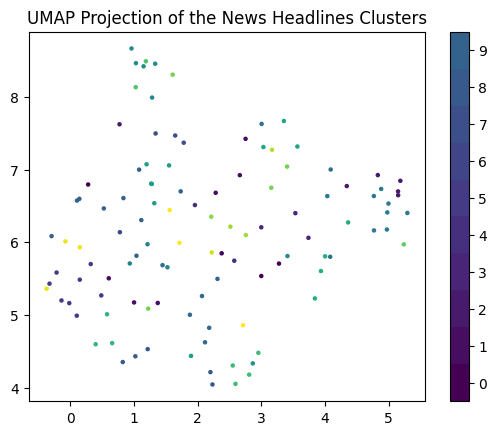

In [116]:
# Apply a Clustering Algorithm (e.g., K-Means)
kmeans = KMeans(n_clusters=30)  # Example with 10 clusters
clusters = kmeans.fit_predict(reduced_data)

# Evaluate the Clustering
silhouette_avg = silhouette_score(reduced_data, clusters)
print(f'Silhouette Score: {silhouette_avg}')

# Visualization with UMAP (optional)
reducer_2d = umap.UMAP(n_components=2)  # Reducing to 2 dimensions for visualization
reduced_data_2d = reducer_2d.fit_transform(embedding_df)

plt.scatter(reduced_data_2d[:, 0], reduced_data_2d[:, 1], c=clusters, cmap='viridis', s=5)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP Projection of the News Headlines Clusters')
plt.show()

In [102]:
dbscan = DBSCAN(eps=0.5, min_samples=3)  # Adjust eps and min_samples as needed
clusters = dbscan.fit_predict(reduced_data)

AIdf['cluster'] = clusters

In [115]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    for i in range(30):
        tmpdf = AIdf.loc[AIdf['cluster']==i][["title"]]
        if len(tmpdf) ==0:
            break
        display(tmpdf)
    


,title
8,AI Stocks Keep Surging. Buy 2 That Havent.
12,"1 Phenomenal Stock That Could Join Microsoft, Apple, Nvidia, Alphabet, Amazon, and Meta in the $1 Trillion Club"
13,3 Rapidly Rising Companies Set to Join the $1 Trillion Club


,title
17,AI's 'positive role' during Indian polls amidst deepfakes disinformation
18,"Our Chicago: Could artificial intelligence impact 2024 election as voters choose between Joe Biden, Donald Trump?"
19,Program looks at AI's impact on politics in La Crosse


,title
20,Georgia artificial intelligence program teaches kids about bias in policing
21,California Teachers are Using AI to Grade Papers. Whos Grading the AI?
22,Will artificial intelligence transform school?


,title
23,So how are we doing with AI in architectural design?
24,Harnessing AI and technological advancements in the AEC industry for enhanced efficiency and productivity
27,"HowArtificial IntelligenceCan Make Our Smart Homes, Smarter"


,title
28,Personalized AI Farming Assistants
29,AI Can Learn Uses for Modern-Day Agriculture
30,Artificial Intelligence is being trained to help all areas of agriculture


,title
43,Banks Must Guard against Scammers Using AI
59,"GenAI Helps Drive 118% Increase in Job Scams, ITRC Says"
60,"Job scams surged 118% in 2023, aided by AI. Here's how to stop them"
63,"Real criminals, fake victims: how chatbots are being deployed in the global fight against phone scammers"


,title
73,OpenAI-Powered Humanoid Robot Fills Spot At BMW Assembly Plant
74,Figure 01: Coffee-making humanoid robot now shows car assembly skill at BMW
75,Video: Figure 01 humanoid trains for its first job assembling BMWs
76,Watch: Figure's 01 humanoids now working at BMW's car plant in US


,title
82,Policy Learning with Large World Models: Advancing Multi-Task Reinforcement Learning Efficiency and Performance
83,"InternLM2.5-7B-Chat: Open Sourcing Large Language Models with Unmatched Reasoning, Long-Context Handling, and Enhanced Tool Use"
84,Reasoning in Large Language Models: A Geometric Perspective


,title
85,Workplace harrasment diagram by chatGPT
87,How ChatGPT is Revolutionizing Customer Service in 2024
88,What are some creative or unexpected uses of ChatGPT youve discovered?


# Final Summary

In [77]:
markdown_str = ''
for i, row in enumerate(AIdf.itertuples()):
    mdstr = f"[{i+1}. {row.title} - {row.src}]({row.url})  \n\n"
    if 0 < len(catdict[row.id]) < 11 :
        topicstr = ", ".join(catdict[row.id])
        mdstr += f"Topics: {topicstr}\n\n"
    mdstr += f"{response_dict[row.id]} \n\n"
    display(Markdown(mdstr))
    markdown_str += mdstr
    

[1. 5 big analyst AI moves: Nvidia downgraded on limited further upside - Feedly AI](https://www.investing.com/news/stock-market-news/5-big-analyst-ai-moves-nvidia-downgraded-on-limited-further-upside-3509545)  

Topics: Stocks, Semiconductor chips, Nvidia, Analyst

- New Street Research downgraded Nvidia stock to Neutral from Buy due to limited further upside based on GPU revenue projections and potential competition.
- UBS downgraded Pure Storage to Sell, expressing concerns about slowing growth, declining market share, high valuation, and exaggerated emphasis on AI.
- Bank of America elevated Dell to its US 1 List, highlighting positive prospects for the company linked to AI server demand, storage needs, and an anticipated PC refresh. 



[2. Two risks to the AI tech rally - Feedly AI](https://au.investing.com/news/stock-market-news/two-risks-to-the-ai-tech-rally-432SI-3330078)  

Topics: AI economic impacts, AI doom, Nvidia

- Yardeni Research identifies two risks to the AI tech rally: excessive capital influx into AI startups and overhyped expectations in the industry.
- Concerns include the significant amount of funding ($330 billion into 26,000 AI startups in 3 years), leading to a crowded market with profitability challenges and potential financial difficulties for startups.
- Analysts caution about inflated claims by industry leaders like Nvidia's CEO, highlighting the need for caution due to possible AI bubble and uncertainties surrounding AI's efficiency gains and industry volatility. 



[3. 45% of Warren Buffett's $398 Billion Portfolio Is Invested in 3 Artificial Intelligence (AI) Stocks - Google News](https://news.google.com/articles/CBMiW2h0dHBzOi8vd3d3LmZvb2wuY29tL2ludmVzdGluZy8yMDI0LzA3LzA3LzQ1LXdhcnJlbi1idWZmZXR0cy0zOTgtYmlsbGlvbi1pcy1pbi0zLWFpLXN0b2Nrcy_SAQA)  

Topics: AI economic impacts, Stocks, GenAI

- Warren Buffett's investment strategy at Berkshire Hathaway focuses on companies with steady growth, reliable profitability, and shareholder-friendly initiatives.
- Three AI stocks in Berkshire Hathaway's portfolio, Snowflake, Amazon, and Apple, are positioned to benefit substantially from the AI revolution.
- Apple is Berkshire Hathaway's largest position at 44.5%, having steadily grown since 2016 and introducing Apple Intelligence software to enhance user experience with AI capabilities. 



[4. Broadcom: An Essential Company For AI Investors (NASDAQ:AVGO) - Google News](https://news.google.com/articles/CBMiV2h0dHBzOi8vc2Vla2luZ2FscGhhLmNvbS9hcnRpY2xlLzQ3MDE4MDEtYnJvYWRjb20tYW4tZXNzZW50aWFsLWNvbXBhbnktZm9yLWFpLWludmVzdG9yc9IBAA)  

Topics: AI economic impacts, Stocks, Semiconductor chips, Big Tech

- Broadcom is viewed as an essential company for AI investors due to its strong AI-related revenue growth, diversified offerings, high profitability, and potential for growth in semiconductor products.
- Intrinsic value calculations suggest that Broadcom (AVGO) is currently trading at a discount, with a 9% potential upside, making it an attractive opportunity for investors.
- Broadcom's focus on AI servers, data centers, and semiconductor products for the Internet-of-Things industry positions the company for future growth, with a strong emphasis on innovation and technological excellence. 



[5. Advanced Micro Devices, Inc. (AMD): Hedge Funds Are Bullish On This AI Stock Right Now - Google News](https://news.google.com/articles/CBMiTGh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vbmV3cy9hZHZhbmNlZC1taWNyby1kZXZpY2VzLWluYy1hbWQtMDI1NjM1ODE4Lmh0bWzSAQA)  

Topics: AI economic impacts, Stocks, Semiconductor chips, AMD

- Advanced Micro Devices, Inc. (AMD) ranks seventh on the list of biggest AI stories, with hedge funds showing bullish sentiment towards the stock
- China is developing new AI patents faster than the US, potentially posing a threat
- AMD is disrupting various industries with AI, achieving significant revenue growth and attracting hedge fund investments worth $15.63 billion 



[6. Better Artificial Intelligence (AI) Stock: Nvidia vs. AMD - Google News](https://news.google.com/articles/CBMiXWh0dHBzOi8vd3d3LmZvb2wuY29tL2ludmVzdGluZy8yMDI0LzA3LzAyL2JldHRlci1hcnRpZmljaWFsLWludGVsbGlnZW5jZS1zdG9jay1udmlkaWEtdnMtYW1kL9IBAA)  

Topics: Stocks, Semiconductor chips, Nvidia, AMD

- Nvidia and AMD are leading players in the AI chip market, with Nvidia holding an estimated 90% market share in AI chips due to its dominance in GPUs.
- While both companies are compelling investments as the AI market grows, Nvidia has shown stronger financial growth and free cash flow compared to AMD, making it a better long-term investment.
- Despite both stocks being considered overvalued currently, Nvidia offers better value for investors due to its financial performance and dominance in AI chip segments. 



[7. Apple's New Artificial Intelligence (AI) Features Could Push This Semiconductor Company to a $1 Trillion Valuation - Google News](https://news.google.com/articles/CBMiXWh0dHBzOi8vd3d3LmZvb2wuY29tL2ludmVzdGluZy8yMDI0LzA3LzA0L2FwcGxlcy1uZXctYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtYWktZmVhdHVyZXMtY291L9IBAA)  

Topics: AI economic impacts, Stocks, Semiconductor chips, Nvidia, Apple, Big Tech

- Apple's new AI features rely on its own silicon chip designs, benefiting semiconductor company Taiwan Semiconductor Manufacturing (TSM) with potential for increased orders.
- Apple's on-device AI processing with Apple Intelligence could boost TSM's sales as Apple leads the way in this technology.
- TSM, already a significant player in chip manufacturing, stands to benefit from Apple's strong iPhone upgrade cycle, demand from Apple's data centers, and the growing trend towards edge computing. 



[8. Could ASML Be The Next Major AI Stock to Split Its Shares? - Feedly AI](https://247wallst.com/technology-3/2024/07/07/could-asml-be-the-next-major-ai-stock-to-split-its-shares/)  

Topics: Stocks

- ASML is a key player in semiconductor manufacturing, known for its EUV lithography process for cutting-edge semiconductors.
- The company's shares are trading above $1,000 and have a history of stock splits during significant technological trends.
- ASML is considered a strong investment with a monopoly in advanced semiconductor manufacturing, making it a potential candidate for another stock split in the future. 



[9. AI Stocks Keep Surging. Buy 2 That Havent. - Feedly AI](https://www.barrons.com/articles/ai-stocks-salesforce-uber-buy-8aea0217)  

Topics: AI economic impacts, Stocks

- Website: barrons.com is a financial news website.
- Provides information on stocks, investing, and personal finance.
- Offers insights, analyses, and recommendations for investors. 



[10. Forget Nvidia: This Stock-Split AI Stock Could Be a Better Buy - Google News](https://news.google.com/articles/CBMiXWh0dHBzOi8vd3d3LmZvb2wuY29tL2ludmVzdGluZy8yMDI0LzA3LzA0L2ZvcmdldC1udmlkaWEtdGhpcy1zdG9jay1zcGxpdC1haS1zdG9jay1jb3VsZC1iZS1hL9IBAA)  

Topics: Stocks

- Broadcom announced a 10-for-1 stock split to make shares more accessible for retail investors, with a lower valuation and more diversification than Nvidia.
- Broadcom is positioned as a potential alternative AI stock due to its custom chip offerings tailored to specific use cases, big-name clients like Alphabet and Bytedance, and a diversified business beyond AI.
- Despite a significant stock price increase in the past five years, Broadcom offers a relatively cheaper valuation with a forward P/E of 28 compared to competitors like Nvidia and AMD. 



[11. Generative AI Sales Could Soar 2,040%: My Pick for the Best AI Stock to Buy Now (Hint: Not Nvidia) - Feedly AI](https://www.fool.com/investing/2024/07/07/generative-ai-soar-2040-best-ai-stock-buy-now-nvda/)  

Topics: AI economic impacts, Stocks, GenAI

- Nvidia is a dominant force in the AI processor market, with GPUs being industry standard for AI workloads, supported by the CUDA software ecosystem.
- Super Micro Computer is gaining market share in AI servers by leveraging in-house design capabilities and a modular approach to product development.
- Super Micro Computer is positioned as a strong AI stock investment due to its reasonable valuation, potential for growth in generative AI hardware, and market leadership in AI server sales. 



[12. Netflix vs. Disney? We asked ChatGPT-4o which stock is a better buy for 2024 - Feedly AI](https://finbold.com/netflix-vs-disney-we-asked-chatgpt-4o-which-stock-is-a-better-buy-for-2024/)  

Topics: Stocks, Language Models, Netflix, ChatGPT

- Netflix and Disney, as dominant companies in the entertainment and streaming industry, are attracting investor attention for 2024 due to their unique positions.
- ChatGPT-4o highlighted that Netflix shows substantial revenue and subscriber growth along with strong content library, while Disney offers diverse revenue streams and improving financial metrics.
- The decision between investing in Netflix or Disney depends on individual investment goals and risk tolerance, with Netflix presenting high growth potential but also higher risks, while Disney may offer a more stable investment opportunity. 



[13. 1 Phenomenal Stock That Could Join Microsoft, Apple, Nvidia, Alphabet, Amazon, and Meta in the $1 Trillion Club - Google News](https://news.google.com/articles/CBMiXWh0dHBzOi8vd3d3LmZvb2wuY29tL2ludmVzdGluZy8yMDI0LzA3LzA3LzEtcGhlbm9tZW5hbC1zdG9jay10aGF0LWNvdWxkLWpvaW4tbWljcm9zb2Z0LWFwcGxlL9IBAA)  

Topics: Stocks, Meta, Amazon, Big Tech

- Super Micro Computer is gaining market share rapidly in the AI hardware industry, with a distinguished track record in customized servers and fueled by the demand driven by AI.
- The company's flexible server options, long track record, and partnerships with leading chipmakers position it well for potential growth towards a $1 trillion market cap.
- Analysts suggest that Super Micro Computer could reach the $1 trillion market cap by 2029 or 2032 if it maintains its growth rate in the AI server market, supported by the rapid adoption of AI technology. 



[14. 3 Rapidly Rising Companies Set to Join the $1 Trillion Club - Google News](https://news.google.com/articles/CBMiXWh0dHBzOi8vaW52ZXN0b3JwbGFjZS5jb20vMjAyNC8wNy8zLXJhcGlkbHktcmlzaW5nLWNvbXBhbmllcy1zZXQtdG8tam9pbi10aGUtMS10cmlsbGlvbi1jbHViL9IBAA)  

Topics: Stocks, Apple

- Advanced Micro Devices (AMD) saw a boost in revenue due to success in data center segment with Instinct MI300X GPUs and server CPU sales.
- Taiwan Semiconductor Manufacturing (TSM) maintained strong gross margin and lead in semiconductor production despite seasonal fluctuations in smartphone market.
- Tesla (TSLA) achieved record energy storage deployments, doubled AI training compute capacity, and is set to increase car production to over 3 million annually, solidifying its position on the future trillion-dollar companies list. 



[15. Google Says AI Could Break Reality - Feedly AI](https://www.404media.co/email/dd4acda7-3cf5-48a1-a940-8bdf0aede2b4/)  

Topics: AI policy and regulation, AI ethical and legal issues, AI doom, GenAI, Google, Big Tech

- Generative AI could distort collective understanding of socio-political reality or scientific consensus, causing significant harm.
- Misuse of generative AI tools is often not overtly malicious and does not violate content policies or terms of services.
- The ease of flooding the internet with AI-generated content poses risks of undermining public trust and distorting information retrieval. 



[16. Top Artificial Intelligence AI Search Engines to Know in 2024 - Google News](https://news.google.com/articles/CBMiZmh0dHBzOi8vd3d3Lm1hcmt0ZWNocG9zdC5jb20vMjAyNC8wNy8wNy90b3AtYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtYWktc2VhcmNoLWVuZ2luZXMtdG8ta25vdy1pbi0yMDI0L9IBamh0dHBzOi8vd3d3Lm1hcmt0ZWNocG9zdC5jb20vMjAyNC8wNy8wNy90b3AtYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtYWktc2VhcmNoLWVuZ2luZXMtdG8ta25vdy1pbi0yMDI0Lz9hbXA)  

- AI search engines use machine learning, natural language processing, and deep learning to provide more thorough and personalized responses to user queries.
- Gemini, Bing AI, Komo, Yep, You.com, Phind, Neeva, Perplexity AI, and Andi are AI search engines known for their specific features like image creation, code generation, and privacy prioritization.
- AI search engines are transforming information retrieval by offering individualized, context-aware results, catering to diverse needs such as privacy-focused queries, specialized tools for developers, and in-depth research capabilities. 



[17. Wild new way to search for anything, anywhere with Google's Circle to Search AI feature - Feedly AI](https://www.foxnews.com/tech/wild-new-way-search-anything-anywhere-googles-circle-search-ai-feature)  

Topics: Google, Big Tech

- Google's Circle to Search tool allows Android users to search anything on a screen without switching apps, activated by long-pressing the home button or navigation bar.
- The Circle to Search feature offers versatile search capabilities including visual searches, text-based searches, and multisearch options for various types of content.
- Supported on select premium Android devices, Circle to Search leverages AI to provide comprehensive information without interrupting the user's current activity. 



[18. AI's 'positive role' during Indian polls amidst deepfakes disinformation - Google News](https://news.google.com/articles/CBMiTmh0dHBzOi8vd3d3LmNvdW50ZXJ2aWV3Lm5ldC8yMDI0LzA3L2Fpcy1wb3NpdGl2ZS1yb2xlLWR1cmluZy1pbmRpYW4tcG9sbHMuaHRtbNIBAA)  

Topics: AI ethical and legal issues, Cybersecurity, GenAI

- Indian political parties used AI in the form of deepfakes and targeted communication during the world's largest election
- AI was utilized for personalized voter engagement, multilingual communication, and online trolling
- The Indian experience showcases the potential of AI in participatory democracy and representative governance, with lessons for democracies worldwide 



[19. Our Chicago: Could artificial intelligence impact 2024 election as voters choose between Joe Biden, Donald Trump? - Google News](https://news.google.com/articles/CBMiaGh0dHBzOi8vYWJjN2NoaWNhZ28uY29tL3Bvc3QvY2hpY2Fnby1jb3VsZC1hcnRpZmljaWFsLWludGVsbGlnZW5jZS1pbXBhY3QtMjAyNC1lbGVjdGlvbi12b3RlcnMvMTUwMzY5NTEv0gEA)  

Topics: GenAI

- In the 2024 presidential election, there is a concern about how artificial intelligence can impact voter behavior, as evidenced by an AI-generated robocall in the New Hampshire primary sounding like Joe Biden.
- The use of AI in political campaigns can worsen divisions in a polarized society, fuel misinformation, and pose challenges in holding bad actors accountable due to the lack of federal regulations specifically addressing AI in elections.
- Various states, including Illinois, have different regulations regarding the use of AI in elections, creating a patchwork of laws at the national level, leading to a somewhat unregulated environment where AI's role in elections remains relatively unchecked. 



[20. Program looks at AI's impact on politics in La Crosse - Google News](https://news.google.com/articles/CBMiigFodHRwczovL3d3dy53cW93LmNvbS9uZXdzL3dpc2NvbnNpbi9wcm9ncmFtLWxvb2tzLWF0LWFpcy1pbXBhY3Qtb24tcG9saXRpY3MtaW4tbGEtY3Jvc3NlL2FydGljbGVfMWI4OGMxZTgtZjIxYy01ODMwLWI4ODYtNDI5NDA4MjY1NjQ4Lmh0bWzSAQA)  

- Discussion about the use of artificial intelligence in politics in La Crosse
- Program features nationally recognized leader Miles Taylor discussing AI's impact on elections
- Presentation is on Zoom and sponsored by Leader Ethics and League of Women Voters of the La Crosse Area 



[21. Georgia artificial intelligence program teaches kids about bias in policing - Google News](https://news.google.com/articles/CBMiaWh0dHBzOi8vd3d3LndyZHcuY29tLzIwMjQvMDcvMDcvZ2VvcmdpYS1hcnRpZmljaWFsLWludGVsbGlnZW5jZS1wcm9ncmFtLXRlYWNoZXMta2lkcy1hYm91dC1iaWFzLXBvbGljaW5nL9IBeGh0dHBzOi8vd3d3LndyZHcuY29tLzIwMjQvMDcvMDcvZ2VvcmdpYS1hcnRpZmljaWFsLWludGVsbGlnZW5jZS1wcm9ncmFtLXRlYWNoZXMta2lkcy1hYm91dC1iaWFzLXBvbGljaW5nLz9vdXRwdXRUeXBlPWFtcA)  

Topics: AI ethical and legal issues, GenAI

- Georgia AI program teaches kids about bias in policing, focusing on facial recognition and predictive policing data analysis
- Program aims to educate kids on biases present in AI systems and how to avoid them 
- The initiative by AI for Black Kids introduces children to AI concepts to contribute to well-rounded and less biased policing techniques 



[22. California Teachers are Using AI to Grade Papers. Whos Grading the AI? - Feedly AI](https://www.the74million.org/article/california-teachers-are-using-ai-to-grade-papers-whos-grading-the-ai/)  

Topics: AI ethical and legal issues, GenAI

- California schools are incorporating AI tools, such as chatbots, to automate tasks like grading papers, providing feedback, and personalizing learning material for students, which can help teachers save time and reduce burnout.
- While AI tools offer benefits like faster grading and more feedback, guidelines on their ethical and appropriate use in classrooms are vague, and there are concerns about accuracy, bias, privacy, and potential negative impacts on students and educators.
- Teachers like Jen Roberts and Alex Rainey have reported positive experiences using AI tools like Writable and GPT-4 to grade papers, but there are challenges such as varying grading standards, costs of AI tools, and the need for teachers to oversee AI-generated feedback to ensure better student outcomes. 



[23. Will artificial intelligence transform school? - Google News](https://news.google.com/articles/CBMiYWh0dHBzOi8vd3d3LmVjb25vbWlzdC5jb20vc3BlY2lhbC1yZXBvcnQvMjAyNC8wNy8wNy93aWxsLWFydGlmaWNpYWwtaW50ZWxsaWdlbmNlLXRyYW5zZm9ybS1zY2hvb2zSAQA)  

Topics: EducationAI startup funding, GenAI, Meta, Big Tech

- The boldest visions for AI in classrooms misunderstand much about education.
- AI tools like Khanmigo are being developed for students and teachers to interact with historical figures and characters.
- Thomas Edison's prediction from 1913 about the obsolescence of books in schools is revisited in the context of AI development in education. 



[24. So how are we doing with AI in architectural design? - Google News](https://news.google.com/articles/CBMiXmh0dHBzOi8vd3d3LmRvbXVzd2ViLml0L2VuL25ld3MvMjAyNC8wNi8yNi9hcmUtd2UtcmVhZHktdG8tdXNlLWFpLWluLWFyY2hpdGVjdHVyYWwtZGVzaWduLmh0bWzSAWJodHRwczovL3d3dy5kb211c3dlYi5pdC9lbi9uZXdzLzIwMjQvMDYvMjYvYXJlLXdlLXJlYWR5LXRvLXVzZS1haS1pbi1hcmNoaXRlY3R1cmFsLWRlc2lnbi5hbXAuaHRtbA)  

Topics: GenAI

- The fast evolution of AI is impacting the architectural design field, with a study commissioned by Chaos analyzing the significant use of AI in architecture and the desire for improved precision and reliability in AI tools.
- AI is predominantly utilized in the early stages of conceptual design, enhancing efficiency and creativity, but there is a lack of defined ethical guidelines for AI use in architectural design.
- The Royal Institute of British Academy is addressing the ethical dilemmas surrounding AI adoption in architecture, aiming to promote responsible stewardship amidst rapid technological advancements. 



[25. Harnessing AI and technological advancements in the AEC industry for enhanced efficiency and productivity - Google News](https://news.google.com/articles/CBMinAFodHRwczovL3d3dy5leHByZXNzY29tcHV0ZXIuaW4vZ3Vlc3QtYmxvZ3MvaGFybmVzc2luZy1haS1hbmQtdGVjaG5vbG9naWNhbC1hZHZhbmNlbWVudHMtaW4tdGhlLWFlYy1pbmR1c3RyeS1mb3ItZW5oYW5jZWQtZWZmaWNpZW5jeS1hbmQtcHJvZHVjdGl2aXR5LzExMzc1Mi_SAaABaHR0cHM6Ly93d3cuZXhwcmVzc2NvbXB1dGVyLmluL2FtcC9ndWVzdC1ibG9ncy9oYXJuZXNzaW5nLWFpLWFuZC10ZWNobm9sb2dpY2FsLWFkdmFuY2VtZW50cy1pbi10aGUtYWVjLWluZHVzdHJ5LWZvci1lbmhhbmNlZC1lZmZpY2llbmN5LWFuZC1wcm9kdWN0aXZpdHkvMTEzNzUyLw)  

- AI in AEC industry enables problem-solving, data-driven learning, and decision support, transforming various operations.
- AI advancements impact AEC sector with improved design capabilities, optimizing project outcomes, cost analysis, and risk management.
- Machine learning algorithms enhance project management by automating tasks, providing real-time data analysis, and improving decision-making for project managers. 



[26. 5 Best AI Tools for the Construction Industry (July 2024) - Google News](https://news.google.com/articles/CBMiQWh0dHBzOi8vd3d3LnVuaXRlLmFpL2Jlc3QtYWktdG9vbHMtZm9yLXRoZS1jb25zdHJ1Y3Rpb24taW5kdXN0cnkv0gEA)  

- AI tools are disrupting the construction industry by enhancing project management, efficiency, and data-driven decision-making.
- AI tools like OpenSpace, Procore, ALICE Technologies, Doxel, and Buildots are transforming construction processes through real-time progress tracking, generative scheduling, and predictive analytics.
- These AI-powered solutions improve project outcomes, optimize resource allocation, enhance safety on construction sites, and revolutionize the entire construction process from planning to completion. 



[27. What generative AI can do for construction right now - Google News](https://news.google.com/articles/CBMiWmh0dHBzOi8vd3d3LmNvbnN0cnVjdGlvbmRpdmUuY29tL25ld3MvZ2VuZXJhdGl2ZS1haS1zd2luZXJ0b24tZnV0dXJldGVjaC1NaWNyb3NvZnQvNzIwNTEzL9IBAA)  

Topics: GenAI

- Aaron Anderson from Swinerton discusses the current capabilities of generative AI in construction 
- Swinerton is utilizing OpenSpace AI for accurate models in a mass timber multifamily development 
- Anderson highlights the importance of AI tools, robotics integration, and evolving business models in the construction industry 



[28. HowArtificial IntelligenceCan Make Our Smart Homes, Smarter - Feedly AI](https://hackernoon.com/how-artificial-intelligence-can-make-our-smart-homes-smarter)  

Topics: AI energy, GenAI

- AI is revolutionizing smart homes, enhancing automation, security, and convenience, and transforming our everyday living experience.
- Smart home technology allows for intelligent automation, enhanced activity analyses, upgraded hands-free digital security, and improved home accessibility.
- Incorporating AI into homes can lead to a more advanced ecosystem, real-time insights, comprehensive pattern identification, and immersive experiences, ultimately reshaping the real estate market towards smarter homes. 



[29. Personalized AI Farming Assistants - Google News](https://news.google.com/articles/CBMiLWh0dHBzOi8vd3d3LnRyZW5kaHVudGVyLmNvbS90cmVuZHMvYWktZmFybWluZ9IBMWh0dHBzOi8vd3d3LnRyZW5kaHVudGVyLmNvbS9hbXAvdHJlbmRzL2FpLWZhcm1pbmc)  

Topics: Robots, AI jobs, Reinforcement Learning, Agriculture, GenAI

- Netagrow is advancing AI farming by providing farmers with AI-driven tools and insights for optimized yields and sustainability.
- The platform offers personalized recommendations on crop management, soil health, and pest control, enabling data-driven decisions to reduce waste and enhance productivity.
- The integration of AI and agriculture signifies a new era where technology intersects with nature to ensure food security and environmental sustainability. 



[30. AI Can Learn Uses for Modern-Day Agriculture - Google News](https://news.google.com/articles/CBMieWh0dHBzOi8vd3d3LmttYWxhbmQuY29tL2FnL2FpLWNhbi1sZWFybi11c2VzLWZvci1tb2Rlcm4tZGF5LWFncmljdWx0dXJlL2FydGljbGVfYWY2Zjc1MzYtM2FlNi0xMWVmLWE2OTYtNGY5ZGJlYWZiZDBmLmh0bWzSAQA)  

Topics: AI economic impacts, Reinforcement Learning, Sustainability, Agriculture, GenAI, OpenAI

- Artificial intelligence can learn and utilize historical data to enhance modern-day agriculture practices, such as monitoring crop damage, disease, and pests using drones and sensors.
- AI is being explored for its potential in identifying diseases in animals early on, ensuring prompt intervention and preventing herd-wide spread.
- Ensuring data security is crucial in the implementation of AI in agriculture, with a focus on safeguarding information and machinery from potential cyber threats. 



[31. Artificial Intelligence is being trained to help all areas of agriculture - Google News](https://news.google.com/articles/CBMiX2h0dHBzOi8vd3d3LnJmZHR2LmNvbS9hcnRpZmljaWFsLWludGVsbGlnZW5jZS1pcy1iZWluZy10cmFpbmVkLXRvLWhlbHAtYWxsLWFyZWFzLW9mLWFncmljdWx0dXJl0gEA)  

Topics: AI economic impacts, AI jobs, Reinforcement Learning, Sustainability, Agriculture, GenAI, Meta

- Artificial intelligence is increasingly used in agriculture to identify plant diseases, pests, and soil conditions, with the goal of improving accuracy in various areas such as nutrition for livestock and crop protection products.
- AI technology requires vast amounts of data to be effective, including crop data, image data, and soil samples, and ongoing input from farmers and ranchers is essential for its development.
- The use of AI in agriculture has grown significantly, with computer science professors at Dakota State University highlighting its potential to revolutionize various aspects of the field through advanced data analysis and image recognition capabilities. 



[32. On AI's impact on sustainability - Google News](https://news.google.com/articles/CBMiamh0dHBzOi8vd3d3Lm1hbmlsYXRpbWVzLm5ldC8yMDI0LzA3LzA3L2J1c2luZXNzL3N1bmRheS1idXNpbmVzcy1pdC9vbi1haXMtaW1wYWN0LW9uLXN1c3RhaW5hYmlsaXR5LzE5NTU1MDbSAW5odHRwczovL3d3dy5tYW5pbGF0aW1lcy5uZXQvMjAyNC8wNy8wNy9idXNpbmVzcy9zdW5kYXktYnVzaW5lc3MtaXQvb24tYWlzLWltcGFjdC1vbi1zdXN0YWluYWJpbGl0eS8xOTU1NTA2L2FtcA)  

Topics: AI energy, AI policy and regulation, Sustainability, Anthropic, Big Tech

- Artificial intelligence (AI) has evolved from a digital assistant to a key component in modern technology, utilized in various fields such as education, science, medical research, space exploration, and financial management.
- Generative AI (GenAI) is a significant advancement in AI technology, becoming deeply integrated into daily activities and applications.
- The widespread adoption of AI has implications for customer interactions, with banks and other industries increasingly relying on AI interfaces for client communication. 



[33. How AI is helping us tackle the climate crisis - Google News](https://news.google.com/articles/CBMiaWh0dHBzOi8vd3d3LnRoZWd1YXJkaWFuLmNvbS90ZWNobm9sb2d5L2FydGljbGUvMjAyNC9qdWwvMDcvaG93LWFpLWlzLWhlbHBpbmctdXMtdGFja2xlLXRoZS1jbGltYXRlLWNyaXNpc9IBaWh0dHBzOi8vYW1wLnRoZWd1YXJkaWFuLmNvbS90ZWNobm9sb2d5L2FydGljbGUvMjAyNC9qdWwvMDcvaG93LWFpLWlzLWhlbHBpbmctdXMtdGFja2xlLXRoZS1jbGltYXRlLWNyaXNpcw)  

Topics: AI energy, Climate, Sustainability

- AI can help accelerate the green transition and address climate and nature crises by enabling decarbonisation opportunities and supporting shifts towards sustainability in sectors like the built environment.
- The power use for AI is often lower than traditional computing methods, such as in energy-intensive climate models, and discussions around its energy consumption should consider its benefits in combating larger sources of emissions like construction and transport.
- There is a need to focus on improving the efficiency and responsible development of AI, while also harnessing its capabilities to drive the green transition further. 



[34. We ask AI to explain why we struggle with solving the climate crisis - Google News](https://news.google.com/articles/CBMibmh0dHBzOi8vZ2VvZ3JhcGhpY2FsLmNvLnVrL2NsaW1hdGUtY2hhbmdlL3dlLWFzay1haS10by1leHBsYWluLXdoeS13ZS1zdHJ1Z2dsZS13aXRoLXNvbHZpbmctdGhlLWNsaW1hdGUtY3Jpc2lz0gEA)  

Topics: AI doom, Climate, Language Models, Cohere

- Climate change is a complex issue with interconnected effects and potential cascading consequences, highlighting the importance of understanding its interactions and amplifications.
- Reasons for lack of public awareness about climate change interconnectedness include complexity, communication challenges, information overload, psychological barriers, and political polarization.
- Despite irreversible changes, catastrophic consequences can still be avoided through swift and decisive action by self-described intelligent human beings. 



[35. Predicting Toxic Algae Blooms with AI Modeling - Feedly AI](https://www.planetizen.com/news/2024/07/130117-predicting-toxic-algae-blooms-ai-modeling)  

Topics: GenAI

- Scientists are using AI and machine learning models to predict water quality issues caused by toxic blue-green algae blooms, fueled by climate change and rising water temperatures.
- Artificial intelligence modeling will be employed to forecast toxic algal blooms by analyzing data collected since 1954 and predicting how climate change may affect the intensity and frequency of these blooms in the future.
- These harmful algal blooms have been reported in all 50 U.S. states and can have significant consequences such as dangerous toxin levels in water sources, impacting communities and activities like summer tourism. 



[36. UAH Doctoral Candidate Leads Study On Leveraging AI And Social Media For Disaster Relief Communication - Google News](https://news.google.com/articles/CBMinQFodHRwczovL2h1bnRzdmlsbGVidXNpbmVzc2pvdXJuYWwuY29tL25ld3MvMjAyNC8wNy8wNy91YWgtZG9jdG9yYWwtY2FuZGlkYXRlLWxlYWRzLXN0dWR5LW9uLWxldmVyYWdpbmctYWktYW5kLXNvY2lhbC1tZWRpYS1mb3ItZGlzYXN0ZXItcmVsaWVmLWNvbW11bmljYXRpb24v0gEA)  

Topics: GenAI

- The page could not be found on the Huntsville Business Journal website.
- Suggestions for users include checking spelling, using similar keywords, and using more than one keyword for better search results.
- Contact information for the Huntsville Business Journal is provided on the site for inquiries and submissions. 



[37. US-China Conflict: USAF Plans 1000 6th-Gen Robo Warplanes To Counter Beijing & Its Ever Growing PLAAF - Google News](https://news.google.com/articles/CBMiRGh0dHBzOi8vd3d3LmV1cmFzaWFudGltZXMuY29tL3VzLWNoaW5hLWNvbmZsaWN0LXVzYWYtcGxhbnMtMTAwMC02dGgv0gFEaHR0cHM6Ly93d3cuZXVyYXNpYW50aW1lcy5jb20vdXMtY2hpbmEtY29uZmxpY3QtdXNhZi1wbGFucy0xMDAwLTZ0aC8)  

Topics: Robots, China, Military

- CCA (Collaborative Combat Aircraft) Drone is part of the US Air Force's Next Generation Air Dominance (NGAD) Family of Systems to fight China
- The CCA program aims to develop unmanned combat air vehicles (UCAVs) that work collaboratively with manned combat aircraft, incorporating AI for increased survivability and reduced costs
- The USAF plans to spend over $6 billion on the CCA program from 2023 to 2028, with the goal of operationalizing the systems by 2030 and deploying over 1,000 CCAs to counter the growing threats from China 



[38. Elon Musk expected to make speech at opening of Shanghai's World AI Conference - Google News](https://news.google.com/articles/CBMiiwFodHRwczovL3d3dy5yZXV0ZXJzLmNvbS90ZWNobm9sb2d5L2FydGlmaWNpYWwtaW50ZWxsaWdlbmNlL2Vsb24tbXVzay1leHBlY3RlZC1tYWtlLXNwZWVjaC1vcGVuaW5nLXNoYW5naGFpcy13b3JsZC1haS1jb25mZXJlbmNlLTIwMjQtMDctMDMv0gEA)  

Topics: AI economic impacts, China, Big Tech, Elon Musk

- Elon Musk will be a keynote speaker at the opening ceremony of the World AI Conference in Shanghai.
- There is uncertainty whether Musk will appear in person or via video at the event.
- Musk's speech coincides with the EU potentially imposing tariffs on Chinese electric vehicle imports. 



[39. Big Tech needs to generate $600 billion in annual revenue to justify AI hardware expenditure - Feedly AI](https://www.techspot.com/news/103699-big-tech-needs-generate-600-billion-annual-revenue.html)  

Topics: AI economic impacts, GenAI, Nvidia, Big Tech, Analyst

- Big Tech needs to generate $600 billion in annual revenue to justify AI hardware expenditure according to the analysis by Sequoia Capital analyst, David Cahn.
- There is a significant gap between revenue expectations from AI infrastructure build-out and actual revenue growth in the AI ecosystem, with a requirement for $600 billion in annual AI revenue.
- Despite potential revenue growth from AI, there are concerns about the industry's ability to fill the financial gap and sustainability of investments in AI infrastructure. 



[40. Samsung expects profits to surge on demand for AI chips - Google News](https://news.google.com/articles/CBMiP2h0dHBzOi8vd3d3LmZ0LmNvbS9jb250ZW50LzhhN2M4NmZlLWYyNzEtNDRlYS05NmUxLTczMGY1NjQ5M2YzOdIBAA)  

Topics: AI economic impacts, Semiconductor chips, GenAI, Big Tech, Samsung

- Samsung Electronics expects a more than 15-fold increase in second-quarter operating profit due to strong demand for AI products, particularly memory chips.
- Samsung's chip division's estimated strong operating profit in the second quarter is offsetting declining margins in the smartphone business.
- Despite positive financial results, Samsung is facing challenges in catching up with competitors in producing advanced HBM chips and is dealing with labor strikes and management changes. 



[41. Chinas tech boom powering AI career coup, with finance muscled out at top of salary pyramid - Feedly AI](https://www.scmp.com/economy/china-economy/article/3269334/chinas-tech-boom-powering-ai-career-coup-finance-muscled-out-top-salary-pyramid)  

Topics: AI economic impacts, AI jobs, China

- China's tech industry is surpassing finance in terms of salary rankings, with AI jobs offering the highest monthly salaries in a new survey
- As China focuses on self-sufficiency in technology and global demand for AI applications increases, the job market is shifting to meet the demand
- AI engineers are now among the top 20 best-paid jobs, with salaries exceeding those in the financial sector 



[42. China's AI model glut is a 'significant waste of resources' due to scarce real-world applications says Baidu CEO - Feedly AI](https://www.tomshardware.com/tech-industry/artificial-intelligence/chinas-ai-model-glut-is-a-significant-waste-of-resources-due-to-scarce-real-world-applications-says-baidu-ceo)  

Topics: AI economic impacts, China, Baidu, Big Tech

- Baidu CEO stated that China's AI model glut is unsustainable with over 100 LLMs lacking practical applications  
- China has surpassed the U.S. in AI patents but is falling behind in citations  
- Competition between LLMs in China leads to business consolidation with larger companies gaining advantages and smaller companies struggling to sustain their products 



[43. China's homegrown AI models are expanding - Google News](https://news.google.com/articles/CBMiO2h0dHBzOi8vcXouY29tL2VtYWlscy9kYWlseS1icmllZi8xODUxNTgwMDc2L2NoaW5hcy1haS1wdXNo0gEA)  

Topics: AI energy, AI policy and regulation, AI economic impacts, AI jobs, China, GenAI, Baidu

- China's homegrown AI models are expanding, with Quartz compiling a list of the country's top artificial intelligence competitors and firms.
- The South Korea tech giant is experiencing solid profits due to AI and chip demand, leading to a three-year high in Samsung stock.
- Tesla's stock has seen a significant turnaround, with better-than-expected second quarter deliveries boosting the company and CEO Elon Musk's value by $10 billion. 



[44. Banks Must Guard against Scammers Using AI - Google News](https://news.google.com/articles/CBMiJWh0dHBzOi8vd3d3LmRhaWx5LXN1bi5jb20vcG9zdC83NTYzNjnSAQA)  

Topics: AI policy and regulation, AI economic impacts, Fintech, AI ethical and legal issues, Cybersecurity, AI doom, Scams, Privacy, GenAI

- Criminals are using Artificial Intelligence (AI) to impersonate bank senior executives and generate AI-based scams, leading to a significant increase in fraud-related losses.
- Banks and fraud prevention officials are concerned about the rise in fraud losses and are implementing measures such as AI tools for payment validation and customer education to prevent scams.
- Journalists play a vital role in exposing corruption, with news reports revealing corruption among government officials, police, and army personnel, contributing to public scrutiny and combating impunity. 



[45. Fintech needs to adopt advanced AI/ML-powered models - Google News](https://news.google.com/articles/CBMiZ2h0dHBzOi8vd3d3Lm5ld2luZGlhbmV4cHJlc3MuY29tL3hwbG9yZS8yMDI0L0p1bC8wNS9maW50ZWNoLW5lZWRzLXRvLWFkb3B0LWFkdmFuY2VkLWFpbWwtcG93ZXJlZC1tb2RlbHPSAXFodHRwczovL3d3dy5uZXdpbmRpYW5leHByZXNzLmNvbS9hbXAvc3RvcnkveHBsb3JlLzIwMjQvSnVsLzA1L2ZpbnRlY2gtbmVlZHMtdG8tYWRvcHQtYWR2YW5jZWQtYWltbC1wb3dlcmVkLW1vZGVscw)  

Topics: AI economic impacts, AI jobs, Fintech, GenAI

- Fintech sector adopting cloud services, IT modernization, and AI/ML integration
- Significant threats include GenAI threats, deepfakes, phishing, and multi-cloud threats
- Recommendations for fintechs include adopting cloud-native security, integrating security in DevOps, implementing AI/ML solutions, conducting risk analysis, and ensuring regulatory compliance 



[46. What strategies can business and technology leaders adopt to effectively balance immediate AI investments with long-term sustainability objectives?  Intelligent CIO Europe - Google News](https://news.google.com/articles/CBMiwAFodHRwczovL3d3dy5pbnRlbGxpZ2VudGNpby5jb20vZXUvMjAyNC8wNy8wNS93aGF0LXN0cmF0ZWdpZXMtY2FuLWJ1c2luZXNzLWFuZC10ZWNobm9sb2d5LWxlYWRlcnMtYWRvcHQtdG8tZWZmZWN0aXZlbHktYmFsYW5jZS1pbW1lZGlhdGUtYWktaW52ZXN0bWVudHMtd2l0aC1sb25nLXRlcm0tc3VzdGFpbmFiaWxpdHktb2JqZWN0aXZlcy_SAQA)  

Topics: AI economic impacts, Sustainability

- UK CEOs prioritizing AI investments for competitive advantage
- Challenge in balancing immediate AI investments with long-term sustainability goals
- Importance of strategic transactions and industrial AI approach for sustainability goals 



[47. How Cohere CEO Aidan Gomez Says AI Will Directly Profit Companies - Google News](https://news.google.com/articles/CCAiC1pGbWFweFlCYWZZmAEB)  

Topics: AI economic impacts, Reinforcement Learning, Language Models, GenAI, Cohere

- Aidan Gomez, CEO of Cohere, is a key figure in generative AI development.
- He is focused on building generative AI models for companies to boost profits.
- Gomez was involved in writing the foundational paper on transformer tech for generative AI during his time as a Google intern in 2017. 



[48. In the age of AI, the role of the CAIO will be indispensable (and here's why) - VentureBeat](https://venturebeat.com/ai/in-the-age-of-ai-the-role-of-the-caio-will-be-indispensable-and-heres-why/)  

Topics: AI jobs

- Chief AI officers are essential for leading organizations into the future in the AI age 
- Establishing governance for responsible AI use is crucial for companies to innovate boldly and rapidly
- Getting AI into the hands of employees and acting decisively in adopting AI technology can provide significant advantages 



[49. CIOs concerns over generative AI echo those of the early days of cloud computing - Feedly AI](https://techcrunch.com/2024/07/07/cios-concerns-over-generative-ai-echo-those-of-the-early-days-of-cloud-computing/)  

Topics: AI ethical and legal issues, GenAI

- CIOs' concerns over generative AI echo those of the early days of cloud computing, with similarities in governance, security, and responsible use.
- CIOs have learned to focus on guiding responsible use of generative AI and enhancing customer experience, instead of just saying no to the technology.
- IT executives understand that locking down generative AI tools is not practical, and they need to find ways to help employees use them safely and effectively to prevent unauthorized usage. 



[50. US intelligence community is embracing generative AI - Feedly AI](https://www.nextgov.com/artificial-intelligence/2024/07/us-intelligence-community-embracing-generative-ai/397849/)  

Topics: AI policy and regulation, AI economic impacts, AI jobs, AI ethical and legal issues, Language Models, GenAI, OpenAI

- US intelligence agencies are utilizing generative AI for content triage, assisting analysts, search and discovery assistance, ideation, and brainstorming.
- Agencies like the CIA are employing generative AI to sift through vast amounts of data, extract insights, and inform policymakers, enhancing intelligence operations.
- Senior intelligence officials are recognizing the potential of generative AI while also emphasizing the importance of responsibly managing risks and ensuring safety, security, and compliance with privacy standards. 



[51. Passwords are passe: GenAI demands new methods of digital security - Google News](https://news.google.com/articles/CBMiX2h0dHBzOi8vd3d3LnRlY2hyYWRhci5jb20vcHJvL3Bhc3N3b3Jkcy1hcmUtcGFzc2UtZ2VuYWktZGVtYW5kcy1uZXctbWV0aG9kcy1vZi1kaWdpdGFsLXNlY3VyaXR50gEA)  

Topics: Cybersecurity, Privacy, GenAI

- Passwords have become outdated in the age of AI, leading to increased vulnerability to cybercriminals.
- Financial institutions face growing threats from AI-powered cybercrimes, requiring new strategies for fraud prevention.
- Behavioral biometric intelligence offers a non-intrusive method to enhance security and combat fraudulent activities in online banking. 



[52. Tokens are a big reason todays generative AI falls short - Reddit](https://www.reddit.com/r/technology/comments/1dx38gy/tokens_are_a_big_reason_todays_generative_ai/)  

Topics: AI economic impacts, LLMs, AI ethical and legal issues, AI doom, Code generation, Language Models, GenAI, OpenAI, Meta, Cohere

- Tokens are highlighted as a significant factor contributing to the limitations of today's generative AI
- Discussion on the definition of AI, AGI, and the perception of intelligence in the AI industry
- Debate on the relevance and scope of artificial intelligence, including applications such as LLMs, NPC pathfinding, recommendation systems, and fraud detection 



[53. What happened to the artificial-intelligence revolution? - Feedly AI](https://www.economist.com/finance-and-economics/2024/07/02/what-happened-to-the-artificial-intelligence-revolution)  

Topics: GenAI, OpenAI

- The artificial intelligence revolution has not had a significant economic impact so far, despite high expectations and investments from major tech firms.
- In San Francisco, there is a prevalent enthusiasm and belief in AI revolutionizing the global economy, with large investments being made in AI-related hardware and research.
- Outside of America's west coast, there is little evidence that AI is having a significant impact in other regions. 



[54. When AI models are past their prime. - The Verge](https://www.theverge.com/2024/7/7/24193768/using-chatgpt-for-coding-help-is-a-fraught-endeavor)  

Topics: AI ethical and legal issues, Language Models, GenAI, OpenAI

- A recent study highlighted the limitations of AI models like ChatGPT when faced with coding problems that were added after their training data cutoff in 2021.
- ChatGPT (using GPT-3.5) performed well on coding problems existing before 2021 but struggled with new problems, sometimes failing to understand the questions.
- The study underscores the importance of having sufficient and up-to-date data for AI models to function effectively, showing a significant drop in success rate when lacking adequate data. 



[55. A former OpenAI researcher sees a clear path to AGI this decade. Bill Gates disagrees - Google News](https://news.google.com/articles/CBMiX2h0dHBzOi8vZm9ydHVuZS5jb20vMjAyNC8wNy8wMi9iaWxsLWdhdGVzLWxlb3BvbGQtYXNjaGVuYnJlbm5lci10cmVhdGlzZS1hZ2ktc3VwZXJpbnRlbGxpZ2VuY2Uv0gEA)  

Topics: OpenAI, Big Tech, Bill Gates

- Former OpenAI researcher sees AGI achievable within the next two to five years, with potential for rapid progression to artificial superintelligence.
- Bill Gates and others doubt the feasibility of achieving AGI through scaling LLMs, emphasizing the need for better AI solutions than current models.
- Debate surrounding the effectiveness of LLMs, with critics highlighting inherent issues and the need for metacognition in AI systems, while considering the practical business applications of current AI technologies. 



[56. AI models that cost $1 billion to train are underway, $100 billion models coming  largest current models take 'only' $100 million to train: Anthropic CEO - Feedly AI](https://www.tomshardware.com/tech-industry/artificial-intelligence/ai-models-that-cost-dollar1-billion-to-train-are-in-development-dollar100-billion-models-coming-soon-largest-current-models-take-only-dollar100-million-to-train-anthropic-ceo)  

Topics: AI economic impacts, LLMs, Language Models, Anthropic

- AI training costs are growing exponentially, with models costing up to $1 billion to train and expectations for $100 billion models in the future.
- Hardware advancements must keep up with the rapid growth in AI models, with significant power consumption and infrastructure requirements for training these advanced models.
- The development of AI from generative artificial intelligence to artificial general intelligence is expected to be gradual, building upon past models' advancements, and hardware innovations seem to be keeping pace. 



[57. Anthropic aims to fix one of the biggest problems in AI right now - Feedly AI](https://www.digitaltrends.com/computing/anthropic-ai-benchmark-funding-program/)  

Topics: AI ethical and legal issues, GenAI, OpenAI, Anthropic

- Anthropic announced a program funding the development of third-party benchmark tests to evaluate its AI models, aiming to elevate the field of AI safety.
- The company is looking for benchmarks to measure AI safety levels, advanced capabilities, and is willing to fund the development of high-volume tasks for testing.
- Interested developers can submit proposals to Anthropic for evaluation on a rolling basis. 



[58. How Congress is fighting the rise of nonconsensual AI porn - Feedly AI](https://thehill.com/policy/technology/4752365-regulation-nonconsensual-explicit-deepfakes/)  

Topics: AI policy and regulation, AI ethical and legal issues, Privacy, GenAI

- Bipartisan bills introduced in Congress aim to regulate the spread of nonconsensual explicit deepfakes created using artificial intelligence.
- The bills target the issue of nonconsensual explicit deepfakes, which have impacted public figures, celebrities, everyday people, and even school students.
- The legislative efforts include the Defiance Act and the Take It Down Act, seeking to provide civil remedies and criminal violations for producing and sharing nonconsensual digitally altered images online. 



[59. Texas teen works to protect victims of non-consensual real and AI porn | Y'all-itics: June 27, 2024 - Google News](https://news.google.com/articles/CBMiuwFodHRwczovL3d3dy53ZmFhLmNvbS92aWRlby9uZXdzL3BvbGl0aWNzL3lhbGwtaXRpY3MvdGV4YXMtdGVlbi13b3Jrcy10by1wcm90ZWN0LXZpY3RpbXMtb2Ytbm9uLWNvbnNlbnN1YWwtcmVhbC1hbmQtYWktcG9ybi15YWxsLWl0aWNzLWp1bmUtMjctMjAyNC8yODctOGVlZjAyN2QtYmIxOS00Y2UwLWJjNjQtZDNmNjI5MDMxNmJi0gEA)  

Topics: AI ethical and legal issues, Privacy, Language Models, GenAI

- Elliston Berry experienced the creation and spread of fake porn images of her by a classmate at the age of 14
- Berry and her mother share their journey and challenges in dealing with the aftermath of non-consensual real and AI porn
- The article discusses the efforts of the Texas teen in advocating for victims and raising awareness about the issue 



[60. GenAI Helps Drive 118% Increase in Job Scams, ITRC Says - Google News](https://news.google.com/articles/CBMic2h0dHBzOi8vd3d3LnB5bW50cy5jb20vYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtMi8yMDI0L2dlbmFpLWhlbHBzLWRyaXZlLTExOHBlcmNlbnQtaW5jcmVhc2UtaW4tam9iLXNjYW1zLWl0cmMtc2F5cy_SAQA)  

Topics: Scams, Language Models, GenAI

- Generative artificial intelligence (AI) led to a 118% increase in job scams in 2023, with cybercriminals using AI to make scams appear more legitimate.
- Scammers targeted individuals on job posting platforms and social media, asking for sensitive personal information under the guise of fake job opportunities.
- Despite an overall 18% decrease in reported scams, job scams increased, highlighting the impact of AI advancements in aiding cybercriminals. 



[61. Job scams surged 118% in 2023, aided by AI. Here's how to stop them - Google News](https://news.google.com/articles/CBMia2h0dHBzOi8vd3d3LmNuYmMuY29tLzIwMjQvMDcvMDcvam9iLXNjYW1zLXN1cmdlZC0xMThwZXJjZW50LWluLTIwMjMtYWlkZWQtYnktYWktaGVyZXMtaG93LXRvLXN0b3AtdGhlbS5odG1s0gFvaHR0cHM6Ly93d3cuY25iYy5jb20vYW1wLzIwMjQvMDcvMDcvam9iLXNjYW1zLXN1cmdlZC0xMThwZXJjZW50LWluLTIwMjMtYWlkZWQtYnktYWktaGVyZXMtaG93LXRvLXN0b3AtdGhlbS5odG1s)  

Topics: AI economic impacts, Scams, GenAI

- Job scams surged 118% in 2023, driven by AI and remote work, leading to an increase in fraudulent job and recruitment ads aimed at stealing personal and financial information from job seekers.
- Scammers pose as recruiters or post fake job listings on reputable platforms, tricking victims into divulging sensitive information that can be used for identity theft, with the typical victim losing around $2,000.
- Employment scams, though accounting for only 9% of identity scams, are an emerging threat, leveraging AI advancements to make fraudulent job offers appear more legitimate, highlighting the importance of independently verifying job opportunities and avoiding upfront requests for personal information. 



[62. Cloudflare launches a tool to combat AI bots - Feedly AI](https://techcrunch.com/2024/07/03/cloudflare-launches-a-tool-to-combat-ai-bots)  

Topics: AI energy, AI economic impacts, AI ethical and legal issues, Cybersecurity, AI doom, GenAI, Cloudflare, Big Tech

- Cloudflare has launched a tool to automatically detect and block AI bots, crawlers, and scrapers.
- The tool analyzes AI bot and crawler traffic to fine-tune automatic bot detection models and flag traffic from evasive AI bots.
- The problem of AI bots has escalated with the demand for model training data, leading many sites to block AI scrapers and crawlers, although some vendors still appear to be circumventing standard bot exclusion rules. 



[63. Computer love: AI-powered chatbots are changing how we understand romantic and sexual well-being - Feedly AI](https://theconversation.com/computer-love-ai-powered-chatbots-are-changing-how-we-understand-romantic-and-sexual-well-being-234054)  

Topics: GenAI, ChatGPT

- AI-powered chatbots offer companionship, intimacy, and emotional support, leading users to form genuine emotional bonds with them, even resembling human relationships.
- There are concerns that reliance on AI romantic companions may hinder the development of social skills, emotional growth, and the ability to navigate real-world relationships.
- Privacy issues have been raised regarding AI chatbots, as they may share personal data and potentially lead to social isolation and emotional dependency for users. 



[64. Real criminals, fake victims: how chatbots are being deployed in the global fight against phone scammers - Reddit](https://www.reddit.com/r/technology/comments/1dxhln5/real_criminals_fake_victims_how_chatbots_are/)  

Topics: Robots, AI ethical and legal issues, Cybersecurity, Scams, GenAI

- Chatbots are being utilized in the global fight against phone scammers to engage and waste scammers' time.
- The use of chatbots aims to reduce the success rate of scam calls and protect potential victims.
- Certain companies are deploying strategies involving AI to combat phone scammers and enhance security measures. 



[65. AI Creates A 1950s The Fifth Element Movie Trailer & It's Freaky - Feedly AI](https://www.looper.com/1613987/ai-1950s-the-fifth-element-movie-trailer-freaky/)  

Topics: Robots, Language Models, GenAI, OpenAI

- AI technology reimagined "The Fifth Element" movie in a 1950s retro style, giving it a unique visual aesthetic with a throwback vibe.
- The fan-made concept trailer features elements like flying cars, buildings, and spacecrafts inspired by 1950s designs, creating a new perspective on the futuristic world of the film.
- Despite positive reception and hopes from fans, there are no current plans for a 1950s-set "The Fifth Element" remake or sequel, as the original remains a cult classic in the sci-fi genre. 



[66. AI turns Family Guy into a 1980s live action sitcom and the results are freaky - Feedly AI](https://www.unilad.com/film-and-tv/news/family-guy-live-action-ai-831421-20240705)  

Topics: GenAI

- AI technology has been used to transform popular cartoons like Family Guy into live-action sitcoms from the 1980s, resulting in both hilarious and terrifying outcomes
- The AI-generated mockup of Family Guy features characters like Peter, Lois, Meg, and Chris, as well as unique interpretations of iconic characters like the Giant Chicken and Stewie
- Viewers reacted with a mix of fascination and unease, with some expressing interest in watching a full sitcom version of the AI-transformed Family Guy 



[67. next level image gen, i can see why artists are going out of business - Reddit](https://www.reddit.com/r/ChatGPT/comments/1dxf72r/next_level_image_gen_i_can_see_why_artists_are/)  

Topics: AI economic impacts, AI doom, GenAI, Nvidia, OpenAI, Cohere, Big Tech

- Users on r/ChatGPT discuss the capabilities of an image generation model, comparing it to human coding skills and discussing its potential applications in creative projects.
- Some users express surprise at the model's ability to visualize unique images, highlighting its potential in assisting with coding tasks and generating creative solutions.
- There are mixed reactions within the community regarding the ease of generating images using the model, with debates on coding complexity, AI capabilities, and the efficiency of using AI tools. 



[68. Trend Of Hurkle-Durkling In Bed Gets Boosted To High Form Via Modern Generative AI - Feedly AI](https://www.forbes.com/sites/lanceeliot/2024/07/07/trend-of-hurkle-durkling-in-bed-gets-boosted-to-high-form-via-modern-generative-ai/)  

Topics: AI economic impacts, AI ethical and legal issues, AI doom, Code generation, Language Models, GenAI, OpenAI, Meta, Cohere, ChatGPT

- Hurkle-durkling is the act of lounging in bed longer than necessary after waking up.
- Generative AI can help detect hurkle-durkling, provide mental health advisement, and analyze behavior patterns associated with it.
- Hurkle-durkling can have both positive aspects like rest and relaxation, and negative aspects like procrastination and routine disruption. 



[69. Fashion Gets a Generative AI Makeover - Feedly AI](https://analyticsindiamag.com/fashion-gets-a-generative-ai-makeover/)  

Topics: GenAI, OpenAI

- Generative AI has the potential to boost the fashion industry's profits by $150 billion to $275 billion by 2030.
- AI algorithms are used to create innovative styles, inspiring designers and making high fashion accessible and diverse.
- Fashion brands like The Fabricant and Rebeca Minkoff use AI for digital clothing designs, GANs generate new fashion designs from existing styles, and various companies integrate AI for trend forecasting and personalized shopping experiences. 



[70. Metas new AI model can turn text into 3D images in under a minute - Feedly AI](https://www.digitaltrends.com/computing/meta-3d-gen-ai-retexture/)  

Topics: AI economic impacts, AI jobs, Language Models, GenAI, Meta, Cohere, Big Tech

- Meta's new "3D Gen" AI model can transform text into high-fidelity 3D images in under a minute.
- The model can generate 3D models quickly and apply new textures using text prompts.
- The model demonstrates high-resolution textures, material maps, physically-based rendering, and generative re-texturing capabilities. 



[71. German court allows patents for AI-generated inventions - Feedly AI](https://www.surrey.ac.uk/news/german-court-allows-patents-ai-generated-inventions)  

Topics: AI policy and regulation, AI economic impacts, AI ethical and legal issues, Intellectual Property, GenAI

- German court rules that inventions generated by artificial intelligence can be patented, resolving a split between German federal appellate courts
- The decision allows for a natural person to be named as an inventor even if AI was used in generating the invention
- This decision is part of the Artificial Inventor Project led by Professor Ryan Abbott from the University of Surrey 



[72. Does Generative AI Violate the Rights of Authors and Artists? - HackerNoon](https://hackernoon.com/does-generative-ai-violate-the-rights-of-authors-and-artists)  

Topics: AI policy and regulation, AI ethical and legal issues, Intellectual Property, GenAI, Meta

- Authors, artists, and employers are upset over generative AI, leading to pending lawsuits and concerns about the impact on their livelihoods.
- Legal questions surrounding copyright and fair use in relation to generative AI are complex and remain unresolved.
- While generative AI can enhance creativity and knowledge, there are debates on whether AI should be treated differently under copyright law and how it may impact various industries in the future. 



[73. Is the First Generative AI Camera on the Horizon? - Google News](https://news.google.com/articles/CBMiR2h0dHBzOi8vd3d3LmNpbmVkLmNvbS9pcy10aGUtZmlyc3QtZ2VuZXJhdGl2ZS1haS1jYW1lcmEtb24tdGhlLWhvcml6b24v0gEA)  

Topics: GenAI, OpenAI

- The CMR M-1 camera is a new concept camera co-developed by SpecialGuestX and 1stAveMachine, featuring generative AI technology.
- The camera challenges the traditional concept of a camera by incorporating generative AI algorithms alongside basic light-capturing elements.
- The CMR M-1 offers a unique workflow that combines vintage design elements with modern generative AI technology, providing a glimpse into potential future camera features. 



[74. OpenAI-Powered Humanoid Robot Fills Spot At BMW Assembly Plant - Feedly AI](https://www.forbes.com/sites/chriswestfall/2024/07/07/openai-powered-humanoid-robot-fills-spot-at-bmw-assembly-plant/)  

Topics: AI economic impacts, Robots, AI jobs, Reinforcement Learning, OpenAI

- BMW's Spartanburg plant is testing a new fully autonomous humanoid robot in its assembly process, with machine learning capabilities powered by OpenAI and built by Figure.
- Humanoid robots are becoming increasingly important in manufacturing due to factors like labor shortages, hazardous tasks, and repetitive work, leading car makers to explore automation options.
- Agility Robotics has established a humanoid robot factory, where production costs have significantly decreased, making humanoid robots more accessible for tasks requiring manual dexterity, navigation, and decision-making. 



[75. Figure 01: Coffee-making humanoid robot now shows car assembly skill at BMW - Google News](https://news.google.com/articles/CBMicGh0dHBzOi8vYmxvZy5hZGFmcnVpdC5jb20vMjAyNC8wNy8wNi9maWd1cmUtMDEtY29mZmVlLW1ha2luZy1odW1hbm9pZC1yb2JvdC1ub3ctc2hvd3MtY2FyLWFzc2VtYmx5LXNraWxsLWF0LWJtdy_SAQA)  

Topics: AI economic impacts, Robots, Anthropic

- Figure signed a commercial agreement with BMW to deploy its humanoid robot in the carmaker's production facility
- The California-based robotics firm released a video showcasing its 01 humanoid robot participating in the vehicle assembly process at BMW
- Adafruit Industries publishes various content including interviews and reporting on the maker market and technology industry 



[76. Video: Figure 01 humanoid trains for its first job assembling BMWs - Google News](https://news.google.com/articles/CBMiMmh0dHBzOi8vbmV3YXRsYXMuY29tL3JvYm90aWNzL2ZpZ3VyZS1odW1hbm9pZC1ibXcv0gEA)  

Topics: AI economic impacts, Robots, AI jobs, Reinforcement Learning, Anthropic

- Figure's humanoid robot has been training to work at a BMW manufacturing plant
- Various companies are developing AI-powered humanoids to undertake physical tasks more efficiently than humans
- These robots are in training for real-world customer operations, particularly in car manufacturing industries 



[77. Watch: Figure's 01 humanoids now working at BMW's car plant in US - Google News](https://news.google.com/articles/CBMiXmh0dHBzOi8vaW50ZXJlc3RpbmdlbmdpbmVlcmluZy5jb20vaW5ub3ZhdGlvbi91cy1maWd1cmUtaHVtYW5vaWQtc3RhcnQtb3BlcmF0aW9ucy1hdC1ibXctcGxhbnTSAQA)  

Topics: AI economic impacts, Robots, AI jobs

- Figure's humanoid robot is deployed at BMW's facility in Spartanburg, SC, demonstrating full autonomy in vehicle assembly with actions guided by neural networks.
- The versatile humanoid robots from Figure can handle various manufacturing tasks, such as sheet metal handling, operating in the body shop, and overseeing the warehouse, with precise placement capabilities enabled by neural networks.
- Several car manufacturers, including BMW and Mercedes, are exploring the use of humanoid robots for automating repetitive and hazardous tasks on assembly lines to improve productivity and address workforce scaling challenges. 



[78. Official PyTorch Documentary Revisits Its Past, and Its Future - Hacker News 2](https://thenewstack.io/official-pytorch-documentary-revisits-its-past-and-its-future/)  

Topics: Open Source

- PyTorch is utilized by over 60% of AI jobs today and has a significant impact on AI research implementations.
- The official PyTorch documentary titled "Powering the AI Revolution" recounts the creation and development of the deep learning framework, highlighting its exponential growth.
- The documentary reflects on the evolution of AI tools, the origin and rise of PyTorch, its contributions to various industries, and its future potential in enabling diverse platforms and applications. 



[79. Perseverance Triumphs: How SHERLOC Was Brought Back to Life on Mars - Reddit](https://www.reddit.com/r/technology/comments/1dx7p3r/perseverance_triumphs_how_sherloc_was_brought/)  

Topics: Robots

- A post in r/technology discusses the successful revival of SHERLOC on Mars
- The post includes 40 points and 2 comments from users
- Users express excitement and amazement at the feat of bringing the science-built machine back to life on Mars 



[80. 400 robotic surgeries, 98% survival rate: Saudi hospital achieves milestone - Reddit](https://www.reddit.com/r/tech/comments/1dxeodw/400_robotic_surgeries_98_survival_rate_saudi/)  

Topics: Robots, Healthcare

- Saudi hospital achieves a milestone of 400 successful robotic cardiac surgeries with a 98% survival rate
- Discussions in the Reddit post include questions about the specifics of robotic surgery, the role of human control in robotic surgeries, and comparisons with traditional surgery survival rates
- Some skepticism and questions are raised regarding the reported statistics and the performance of robotic surgery, particularly in cardiac surgeries. 



[81. Press Release: A 2D device for quantum cooling:EPFL engineers have created a device that can efficiently convert heat into electrical voltage at temperatures lower than that of outer space. The innovation could help overcome a significant obstacle to the adva - Google News](https://news.google.com/articles/CBMiNGh0dHBzOi8vd3d3Lm5hbm90ZWNoLW5vdy5jb20vbmV3cy5jZ2k_c3RvcnlfaWQ9NTc0OTfSAQA)  

- EPFL engineers created a 2D device that efficiently converts heat into electrical voltage at temperatures lower than outer space.
- The device helps in overcoming obstacles in quantum computing technology by cooling quantum bits to millikelvin temperatures.
- The device combines graphene and indium selenide to exploit the Nernst effect, allowing for efficient heat to voltage conversion at ultra-low temperatures. 



[82. Step aside Futurama, scientist build robot that's controlled by a brain in a jar - Reddit](https://www.reddit.com/r/tech/comments/1dxf0nq/step_aside_futurama_scientist_build_robot_thats/)  

Topics: Robots

- Scientists have developed a robot controlled by a brain in a jar, reminiscent of science fiction concepts like Krang and Robobrains.
- The robot is a mockup and the actual brain is kept separate for testing, raising questions about the ethical and practical implications of using human or animal brains for such technology.
- There is discussion on the potential use of proto-brains and the ethical considerations of creating consciousness in non-born entities for tasks like servitude. 



[83. Policy Learning with Large World Models: Advancing Multi-Task Reinforcement Learning Efficiency and Performance - Feedly AI](https://www.marktechpost.com/2024/07/07/policy-learning-with-large-world-models-advancing-multi-task-reinforcement-learning-efficiency-and-performance/)  

Topics: LLMs, Reinforcement Learning, OpenAI

- Reinforcement Learning (RL) is effective for individual tasks but struggles with multitasking, especially with different robotic forms
- Policy Learning with Large World Models (PWM) introduced as an innovative model-based reinforcement learning algorithm 
- PWM utilizes large multi-task world models for efficient policy training, outperforming existing methods with higher rewards and smoother optimization landscapes 



[84. InternLM2.5-7B-Chat: Open Sourcing Large Language Models with Unmatched Reasoning, Long-Context Handling, and Enhanced Tool Use - Feedly AI](https://www.marktechpost.com/2024/07/07/internlm2-5-7b-chat-open-sourcing-large-language-models-with-unmatched-reasoning-long-context-handling-and-enhanced-tool-use/)  

Topics: LLMs, Open Source, Language Models, GenAI, Google, OpenAI, Meta, Cohere, ChatGPT

- InternLM has introduced InternLM2.5-7B-Chat, a large language model in GGUF format compatible with llama.cpp, highlighting state-of-the-art reasoning in mathematical tasks and a 1M context window.
- The model's capability in handling long contexts is enhanced with LMDeploy toolkit for compressing, deploying, and serving LLMs, particularly effective in retrieving information from extensive documents.
- InternLM2.5-7B-Chat demonstrates superior performance in various benchmarks, excelling in tool use, and offers a guide for installation, model download, and deployment examples with faster inference capabilities on NVIDIA GPUs. 



[85. Reasoning in Large Language Models: A Geometric Perspective - Hacker News](https://arxiv.org/abs/2407.02678)  

Topics: LLMs, Language Models, OpenAI, Cohere

- The study explores reasoning abilities of large language models (LLMs) through a geometric understanding.
- A connection is established between the expressive power of LLMs and the density of their self-attention graphs.
- The density of these graphs defines the intrinsic dimension of the inputs to the MLP blocks, with higher intrinsic dimensions implying greater expressive capacity. 



[86. Workplace harrasment diagram by chatGPT - Reddit](https://www.reddit.com/r/ChatGPT/comments/1dxd1yg/workplace_harrasment_diagram_by_chatgpt/)  

Topics: Language Models, GenAI, ChatGPT

- Workplace harassment diagram by ChatGPT shared on r/ChatGPT
- Rules on post behavior within the ChatGPT subreddit
- Comments by users on the diagram and its interpretation 



[87. OpenAI's ChatGPT Mac App Was Saving Chats as Plain Text - Feedly AI](https://www.pcmag.com/news/openais-chatgpt-mac-app-was-saving-chats-as-plain-text)  

Topics: AI ethical and legal issues, Cybersecurity, Privacy, Language Models, OpenAI, Big Tech, ChatGPT

- OpenAI's ChatGPT Mac app was saving chats as plain text.
- The issue was corrected through an update this week.
- The app now encrypts local chats but messages are still not sandboxed. 



[88. How ChatGPT is Revolutionizing Customer Service in 2024 - Feedly AI](https://www.marktechpost.com/2024/07/07/how-chatgpt-is-revolutionizing-customer-service-in-2024/)  

Topics: customer service, Language Models, GenAI, OpenAI, ChatGPT

- OpenAI's ChatGPT is transforming customer service in 2024 using advanced AI technology
- ChatGPT enhances customer interactions through natural language processing and offers 24/7 availability for inquiries
- Implementing ChatGPT in customer service operations reduces costs, provides personalization, multilingual support, scalability, and continuous improvement through machine learning 



[89. What are some creative or unexpected uses of ChatGPT youve discovered? - Reddit](https://www.reddit.com/r/ChatGPT/comments/1dxexjh/what_are_some_creative_or_unexpected_uses_of/)  

Topics: Language Models, GenAI, OpenAI, ChatGPT

- Users have discovered creative uses of ChatGPT such as generating beer recommendations based on a menu photo, translating foreign restaurant menus, creating bedtime stories, and generating music for D&D campaign recaps.
- ChatGPT has been utilized for tasks like resume tailoring for job applications, preparing for interviews, writing emails, optimizing grocery shopping lists, and learning about topics through daily discussions.
- It has also been employed in generating workout plans, meal recipes, legal contract analysis, and assisting lawyers in tasks like summarization, syntax review, and document templating. 



[90. GPT-4o vs Gemini 1.5 Pro vs Claude 3.5 Sonnet. Only Claude calls astrology bullshit right away - Reddit](https://www.reddit.com/r/ChatGPT/comments/1dxmm0u/gpt4o_vs_gemini_15_pro_vs_claude_35_sonnet_only/)  

Topics: Language Models, GenAI, Claude

- Claude 3.5 Sonnet stands out by calling astrology bullshit immediately.
- Users express satisfaction with Claude's responses and effectiveness.
- Discussion includes comparisons between GPT-4o, Gemini 1.5 Pro, and Claude 3.5 Sonnet, with Claude receiving positive feedback for its performance. 



[91. I learned how to use AI generative prompts with this one app - Feedly AI](https://www.techradar.com/computing/websites-apps/i-learned-how-to-use-ai-generative-prompts-with-this-one-app)  

Topics: Language Models, GenAI

- Sololearn provides a range of courses from AI to Python, offering an engaging and hands-on learning experience with real-time feedback.
- The app offers games like 'Bug Hunter' and challenges against opponents, fostering motivation and competition within the Sololearn community.
- Users can also create code in the Code Playground for community feedback, making it a valuable tool for error debugging and improvement in programming skills. 



[92. Mitigating AI bias with prompt engineering  putting GPT to the test - Google News](https://news.google.com/articles/CBMiXmh0dHBzOi8vdmVudHVyZWJlYXQuY29tL2FpL21pdGlnYXRpbmctYWktYmlhcy13aXRoLXByb21wdC1lbmdpbmVlcmluZy1wdXR0aW5nLWdwdC10by10aGUtdGVzdC_SAQA)  

Topics: LLMs, AI ethical and legal issues, Language Models, GenAI, OpenAI, Cohere, Big Tech, ChatGPT

- The experimental methodology analyzed the influence of different AI prompt designs on generating unbiased and fair content from LLMs.
- Ethically-informed prompts demonstrated a reduction in biased output and increased equitable representation of diverse groups compared to neutral prompts.
- Developing tailored approaches with emphasis on inclusive language and social context can enhance fairness in AI applications and mitigate biases. 



[93. Samsung Galaxy AI could soon offer real-time translations in WhatsApp - Feedly AI](https://www.techradar.com/phones/samsung-galaxy-phones/samsung-galaxy-ai-could-soon-offer-real-time-translations-in-whatsapp)  

Topics: Language Models, GenAI, Big Tech, Samsung, WhatsApp

- Samsung Galaxy AI is expected to offer real-time translations in WhatsApp through third-party integrations, expanding its Live Translate feature to other apps.
- The integration could extend to audio calls in WhatsApp, allowing translations between languages during conversations, in addition to text messages.
- Samsung is focusing on incorporating AI features in their phones to stay competitive with other manufacturers like Apple and Google, showcasing the importance of AI in smartphone technology advancements. 



[94. Meta AI may get more collaborative in WhatsApp for Android. - Feedly AI](https://www.theverge.com/2024/7/7/24193680/meta-ai-may-get-more-collaborative-in-whatsapp-for-android)  

Topics: Meta, Big Tech, WhatsApp

- A new WhatsApp beta version for Android allows users to send photos to Meta AI and ask it questions or edit the image using prompts.
- Meta has been introducing more image-generation features on WhatsApp, including a beta feature that enables Meta AI to create avatars for users based on their photos.
- The collaboration between Meta AI and WhatsApp on Android may increase, providing users with more interactive and AI-driven experiences within the app. 



[95. WhatsApp's new feature will let Meta AI edit your photos for you - Feedly AI](https://www.androidauthority.com/whatsapp-meta-ai-update-3457975/)  

Topics: AI policy and regulation, AI economic impacts, AI jobs, AI ethical and legal issues, GenAI, Meta, Big Tech, WhatsApp

- WhatsApp's beta version introduced a new feature that allows users to share photos with Meta AI, which can analyze, provide information, and even edit the uploaded images directly in the chat.
- Meta AI will offer users the capability to ask questions about their photos, identify objects or locations, and request edits to their images.
- The extent of the image editing feature within Meta AI in WhatsApp, currently in development, remains unclear but has the potential to revolutionize photo editing capabilities through AI technology. 



[96. New cyberattack targets iPhone and Apple IDs  Heres how to stay safe - Google News](https://news.google.com/articles/CBMiX2h0dHBzOi8vY3liZXJndXkuY29tL3NjYW1zL25ldy1jeWJlcmF0dGFjay10YXJnZXRzLWlwaG9uZS1hbmQtYXBwbGUtaWRzLWhlcmVzLWhvdy10by1zdGF5LXNhZmUv0gFjaHR0cHM6Ly9jeWJlcmd1eS5jb20vc2NhbXMvbmV3LWN5YmVyYXR0YWNrLXRhcmdldHMtaXBob25lLWFuZC1hcHBsZS1pZHMtaGVyZXMtaG93LXRvLXN0YXktc2FmZS9hbXAv)  

Topics: Cybersecurity, Scams, Privacy, Apple, Big Tech

- A cyberattack targeting Apple iPhone users through text phishing scam has been identified, urging users to be cautious of fake messages requesting Apple ID credentials.
- The attackers create fake websites resembling Apple's login page to steal personal and financial data.
- Apple advises enabling two-factor authentication, being wary of suspicious messages, and staying updated with software to protect against such scams. 



[97. Apple's AI Shift, Board Observer Role At OpenAI, Extended iPhone Settlement Deadline, And AI Partnership With Google: This Week In Appleverse - Alphabet (NASDAQ:GOOG), Apple (NASDAQ:AAPL) - Google News](https://news.google.com/articles/CBMikQFodHRwczovL3d3dy5iZW56aW5nYS5jb20vbmV3cy8yNC8wNy8zOTY1NjI2OS9hcHBsZXMtYWktc2hpZnQtYm9hcmQtb2JzZXJ2ZXItcm9sZS1hdC1vcGVuYWktZXh0ZW5kZWQtaXBob25lLXNldHRsZW1lbnQtZGVhZGxpbmUtYW5kLWFpLXBhcnRuZXJzaGlw0gEA)  

Topics: AI economic impacts, AI jobs, Language Models, GenAI, Google, OpenAI, Apple, Big Tech

- Apple is shifting focus towards artificial intelligence and software due to slower hardware innovation
- Apple secures an observer role at OpenAI, extends iPhone settlement deadline, and works on major changes for the next-gen Vision Pro headset
- Apple is rumored to be partnering with Google in the fall for AI integration into Apple devices 



[98. Android Circuit: Galaxy Z Fold6 Details, Google AI Secrets, Pixel 9 Pro Specs - Google News](https://news.google.com/articles/CBMigAFodHRwczovL3d3dy5mb3JiZXMuY29tL3NpdGVzL2V3YW5zcGVuY2UvMjAyNC8wNy8wNS9hbmRyb2lkLW5ld3MtaGVhZGxpbmVzLXBpeGVsLTktcHJvLWdhbGF4eS16LWZvbGQ2LWh1YXdlaS1taXgtZm9sZDQtZ29vZ2xlLWFpL9IBAA)  

Topics: Big Tech, Samsung

- Final details on Samsung's Galaxy Z Fold6 reveal advancements in the hinge assembly for better design and durability.
- Samsung might discontinue the "Plus" model for the S25 series, focusing on the regular and Ultra models.
- The Pixel 9 Pro is expected to feature a new long-life display and debut Google AI with photo enhancement and creative tools. 



[99. Apple Loop: iPhone 16 Pro Specs, Apple Watch 10 Design Leaks, Paying For Apple's AI - Google News](https://news.google.com/articles/CBMiiAFodHRwczovL3d3dy5mb3JiZXMuY29tL3NpdGVzL2V3YW5zcGVuY2UvMjAyNC8wNy8wNy9hcHBsZS1uZXdzLWhlYWRsaW5lcy1pcGhvbmUtMTYtcHJvLWExNy1hcHBsZS13YXRjaC1pcGhvbmUtYmF0dGVyeS1yZXBsYWNlbWVudC1haS1yY3Mv0gEA)  

Topics: Apple, Big Tech

- iPhone 16 lineup will have AI-capable processors and share the same processor, improving battery life efficiency
- Apple plans to introduce a new technology for easier battery replacements in iPhone models
- Apple is incorporating RCS messaging protocol in its Messages app in iOS 18 to allow for advanced communication features 



[100. Apple Intelligence and a better Siri may be coming to iPhones this spring - Feedly AI](https://www.theverge.com/2024/7/7/24193619/apple-intelligence-better-siri-ios-18-4-spring-public-launch)  

Topics: Apple, Big Tech

- Siri is expected to improve with the introduction of Apple Intelligence AI system in the iOS 18.4 update in spring 2025, allowing for enhanced features like better organization of photos and easier form-filling.
- Beta versions of iOS 18 will offer a preview of upcoming AI features like ChatGPT integration and a new Siri interface, with further enhancements like AirPods with embedded cameras in the works for future generations.
- Apple's AI advancements plan also includes potential features like using AI to describe surroundings with imagery from AirPods and help with navigation, similar to Meta's Ray-Ban glasses. 



[101. I thought small phones were dead, but I want AI to bring them back - Google News](https://news.google.com/articles/CBMiQGh0dHBzOi8vd3d3LmFuZHJvaWRhdXRob3JpdHkuY29tL3NtYWxsLXBob25lcy1haS1yZXR1cm4tMzQ1NjcyNS_SAQA)  

- The desire for the return of small phones is driven by the potential for AI to enhance user experience and functionality on compact devices. 
- The integration of highly capable smart assistants and offloading tasks to the cloud are seen as essential factors in making small phones a feasible reality. 
- The Rabbit R1, despite its shortcomings, represents a forward-thinking approach towards reimagining smartphone design by prioritizing voice commands and minimizing on-device work. 



[102. Police pulled over a Waymo car for driving in the oncoming lane - The Verge](https://www.theverge.com/2024/7/6/24193094/phoenix-waymo-car-pulled-over-traffic-stop-oncoming-lane-police)  

Topics: Autonomous vehicles

- A Waymo car was pulled over by police for driving in the oncoming lane due to confusion with construction signs
- The vehicle had no passengers and was unable to issue a citation as stated in dispatch records
- Despite instances of endangering road users, Waymo claims its cars are 3.5 times more likely to avoid a crash than humans 



[103. Don't Worry: Copilot+ PCs Don't Make Your Windows 11 System Obsolete - Feedly AI](https://www.makeuseof.com/worry-copilot-pc-old-windows-11-system-obsolete/)  

Topics: Microsoft, Big Tech

- CoPilot+ PCs enhance Windows 11 with AI tools via NPUs, offering features like automatic captions, Cocreator support, Auto Super Resolution, and AI assistant capabilities.
- CoPilot+ does not make Windows 11 redundant; it builds on the existing system by adding AI capabilities and features, making it an upgrade rather than a replacement.
- Deciding to buy a CoPilot+ PC depends on the user's interest in AI tools; it is not necessary for all users and primarily benefits those who want to leverage AI capabilities on their devices. 



[104. I spent a day using Copilot+ on the HP EliteBook Ultra, and it drove me crazy - Feedly AI](https://www.laptopmag.com/laptops/i-spent-a-day-using-copilot-on-the-hp-elitebook-ultra-and-it-drove-me-crazy)  

Topics: Language Models

- Copilot+ AI on the HP EliteBook Ultra doesn't offer any new features
- Not all Copilot+ AI features are practical or necessary for daily use
- The performance and battery life of Copilot+ PCs, like the HP EliteBook Ultra, are impressive, but the AI features may not warrant an upgrade at this point. 



[105. A friendly guide to containerization for AI work - Feedly AI](https://go.theregister.com/feed/www.theregister.com/2024/07/07/containerize_ai_apps/)  

- Containerization helps in avoiding dependencies issues by building images configured specifically for tasks and ensures consistent and repeatable deployment.
- Docker allows for easy access to GPUs from Intel, AMD, and Nvidia by passing appropriate flags when spinning up containers.
- Prebuilt images like nvidia/cuda and ROCm images can be used to quickly set up CUDA, ROCm, or OpenVINO environments without building from scratch. 



[106. A friendly guide to containerization for AI workHands onSave the headaches, ship your dependenciesAI + ML6 hrs|1 - The Register](https://www.theregister.com/2024/07/07/containerize_ai_apps/)  

- Containerizing AI workloads can help in managing dependencies, enabling consistent deployment, and running apps with conflicting software stacks.
- Docker can be used to expose Intel, AMD, and Nvidia GPUs to containers, simplifying the process of making GPUs available for tasks.
- Prebuilt images for CUDA, ROCm, and OpenVINO can expedite setting up environment, while converting containers into images and building custom images can enhance reproducibility and testing in AI development. 



[107. Show HN: Workspaice:  Human+AI, Creating Together - Hacker News 2](https://www.nunodonato.com/workspaice-humanai-creating-together/)  

Topics: GenAI

- Workspaice is a locally-run application that combines human creativity and AI assistance in a flexible workspace for creating various projects.
- The application prioritizes privacy and speed by running locally on the user's computer and utilizes AI collaboratively with users in the creation process.
- Workspaice is showcased in a demo video featuring projects like desktop app development, web app creation, and educational content, catering to developers, educators, writers, and anyone with innovative ideas. 



[108. James Muldoon, Mark Graham and Callum Cant: AI feeds off the work of human beings - Reddit](https://www.reddit.com/r/technology/comments/1dxij9l/james_muldoon_mark_graham_and_callum_cant_ai/)  

Topics: AI economic impacts, AI jobs, AI ethical and legal issues, AI doom, Language Models

- Data annotation industry workers, mostly in the global south, face poor working conditions with low wages.
- 80% of the work behind AI products is data annotation, which can be intensive and outsourced.
- AI's exploitation of human labor is a significant issue that needs more attention and discussion. 



[109. Meet Mercy and Anita  the African workers driving the AI revolution, for just over a dollar an hour - Reddit](https://www.reddit.com/r/technology/comments/1dx9xkt/meet_mercy_and_anita_the_african_workers_driving/)  

Topics: AI economic impacts, AI jobs

- Mercy and Anita, African workers, are playing a significant role in driving the AI revolution while earning just over a dollar an hour.
- The article sheds light on the role of these workers in advancing Artificial Intelligence.
- The workers' contributions are crucial to the development and progression of AI technology. 



[110. Figma disables AI-powered 'Make Design' feature after Weather app rip-off - Feedly AI](https://appleinsider.com/articles/24/07/07/figma-disables-ai-powered-make-design-feature-after-weather-app-rip-off)  

Topics: AI ethical and legal issues, Intellectual Property, Big Tech

- Figma is temporarily disabling its primary AI App UI design tool due to accusations of training the model on Apple's Weather app
- Developer Andy Allen demonstrated that Figma's "Make Design" feature was repeatedly copying Apple's app when asked to create a weather app
- Figma CEO Dylan Field defended the company by stating that the fault lies in the company's design systems, with no clear indication of when the tool will return 



[111. Microsoft's AI CEO: Web Content (Without a Robots.txt File) is 'Freeware' for AI Training - Google News](https://news.google.com/articles/CBMifmh0dHBzOi8vc2xhc2hkb3Qub3JnL3N0b3J5LzI0LzA3LzA3LzAwNTQyMjAvbWljcm9zb2Z0cy1haS1jZW8td2ViLWNvbnRlbnQtd2l0aG91dC1hLXJvYm90c3R4dC1maWxlLWlzLWZyZWV3YXJlLWZvci1haS10cmFpbmluZ9IBAA)  

Topics: Robots, AI ethical and legal issues, GenAI, Microsoft, Big Tech

- Microsoft's CEO of AI, Mustafa Suleyman, stated that web content shared online has been considered fair use since the 90s, unless explicitly prohibited by the content producer.
- Suleyman suggested that the economics of information will drastically change, leading to new scientific and cultural knowledge being produced at almost zero marginal cost.
- There is a debate surrounding the use of web content for AI training, with concerns raised about ownership of intellectual property and potential copyright infringement issues. 



[112. Microsofts climbdown over its creepy Recall feature shows its AI strategy is far from intelligent | The tech companys new Windows machines can take constant screenshots of users every action  quelle surprise, its a privacy minefield - Reddit](https://www.reddit.com/r/technology/comments/1dxilwo/microsofts_climbdown_over_its_creepy_recall/)  

Topics: AI ethical and legal issues, Cybersecurity, AI doom, Privacy, Microsoft, Big Tech

- Microsoft faced criticism over the Recall feature in its new Windows machines for taking constant screenshots of users, highlighting privacy concerns.
- The AI strategy of Microsoft was questioned as the Recall feature was considered intrusive and raised privacy issues among users.
- Users expressed dissatisfaction with the privacy implications and performance impact of the Recall feature, with concerns about the extent of monitoring and lack of user control. 



In [78]:
FINAL_SUMMARY_PROMPT = f"""You are a summarization assistant. I will provide a list of today's news stories about AI
and summary bullet points in markdown format. You are tasked with identifying and summarizing the key themes,
common facts, and recurring elements. Your goal is to create a concise summary containing about 20 of the most 
frequently mentioned topics and developments.

Example Input Bullet Points:

[2. Sentient closes $85M seed round for open-source AI](https://cointelegraph.com/news/sentient-85-million-round-open-source-ai)

Topics: AI startup funding, New AI products

- Sentient secured $85 million in a seed funding round led by Peter Thiel's Founders Fund, Pantera Capital, and Framework Ventures for their open-source AI platform.
- The startup aims to incentivize AI developers with its blockchain protocol and incentive mechanism, allowing for the evolution of open artificial general intelligence.
- The tech industry is witnessing a rise in decentralized AI startups combining blockchain

Examples of important stories:

Major investments and funding rounds
Key technological advancements or breakthroughs
Frequently mentioned companies, organizations, or figures
Notable statements by AI leaders
Any other recurring themes or notable patterns

Instructions:

Read the summary bullet points closely.
Use only information provided in them and provide the most common facts without commentary or elaboration.
Write in the professional but engaging, narrative style of a tech reporter for a national publication.
Be balanced, professional, informative, providing accurate, clear, concise summaries in a respectful neutral tone.
Focus on the most common elements across the bullet points and group similar items together.
Headers must be as short and simple as possible: use "Health Care" and not "AI developments in Health Care" or "AI in Health Care"
Ensure that you provide at least one link from the provided text for each item in the summary.
You must include at least 10 and no more than 25 items in the summary.

Example Output Format:

# Today's AI News

### Security and Privacy:
- ChatGPT Mac app had a security flaw exposing user conversations in plain text. ([Macworld](https://www.macworld.com/article/2386267/chatgpt-mac-sandboxing-security-flaw-apple-intelligence.html))
- Brazil suspended Meta from using Instagram and Facebook posts for AI training over privacy concerns. ([BBC](https://www.bbc.com/news/articles/c7291l3nvwv))

### Health Care:
- AI can predict Alzheimer's disease with 70% accuracy up to seven years in advance. ([Decrypt](https://decrypt.co/238449/ai-alzheimers-detection-70-percent-accurate-study))
- New AI system detects 13 cancers with 98% accuracy, revolutionizing cancer diagnosis. ([India Express](https://news.google.com/articles/CBMiiAFodHRwczovL2luZGlhbmV4cHJl))

Bullet Points to Summarize:

"""

In [79]:
response = client.chat.completions.create(
    model=MODEL,
    messages=[
              {"role": "user", "content": FINAL_SUMMARY_PROMPT + markdown_str
              }],
    n=1,   
    temperature=0.5
)


2024-07-07 19:09:41,414 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [80]:
response_str = response.choices[0].message.content
response_str = response_str.replace("$", "\\$")
display(Markdown(response_str))


# Today's AI News

### Stocks and Investments:
- Nvidia was downgraded by New Street Research due to limited upside in GPU revenue projections. ([Investing](https://www.investing.com/news/stock-market-news/5-big-analyst-ai-moves-nvidia-downgraded-on-limited-further-upside-3509545))
- Broadcom is seen as an essential AI investment, with strong AI-related revenue growth and a diversified product offering. ([Seeking Alpha](https://seekingalpha.com/article/4701801-broadcom-an-essential-company-for-ai-investors))
- Samsung expects a significant profit surge from AI chip demand. ([FT](https://www.ft.com/content/8a7c86fe-f271-44ea-96e1-730f56493f39))
- Warren Buffett's Berkshire Hathaway holds major positions in AI stocks like Snowflake, Amazon, and Apple. ([Fool](https://www.fool.com/investing/2024/07/07/45-warren-buffett-398-billion-portfolio-3-ai-stocks/))
- China’s tech boom is driving high salaries for AI jobs, surpassing finance. ([SCMP](https://www.scmp.com/economy/china-economy/article/3269334/chinas-tech-boom-powering-ai-career-coup-finance-muscled-out-top-salary-pyramid))

### AI in Healthcare:
- Saudi hospital achieved 400 robotic cardiac surgeries with a 98% survival rate. ([Reddit](https://www.reddit.com/r/tech/comments/1dxeodw/400_robotic_surgeries_98_survival_rate_saudi/))

### AI Ethical and Legal Issues:
- Bipartisan bills in Congress aim to regulate nonconsensual explicit deepfakes. ([The Hill](https://thehill.com/policy/technology/4752365-regulation-nonconsensual-explicit-deepfakes/))
- German court allows patents for AI-generated inventions. ([Surrey](https://www.surrey.ac.uk/news/german-court-allows-patents-ai-generated-inventions))
- Figma disables its AI-powered "Make Design" feature after accusations of copying Apple's Weather app. ([AppleInsider](https://appleinsider.com/articles/24/07/07/figma-disables-ai-powered-make-design-feature-after-weather-app-rip-off))

### AI in Politics:
- AI's role in the 2024 US presidential election raises concerns about misinformation and voter behavior. ([ABC7 Chicago](https://abc7chicago.com/post/chicago-could-artificial-intelligence-impact-2024-election-voters/15036951/))
- AI was used extensively in Indian elections for personalized voter engagement and multilingual communication. ([Counterview](https://www.counterview.net/2024/07/ais-positive-role-during-indian-polls.html))

### AI in Technology:
- Meta's new AI model can transform text into 3D images rapidly. ([Digital Trends](https://www.digitaltrends.com/computing/meta-3d-gen-ai-retexture/))
- OpenAI's ChatGPT Mac app had a security flaw, saving chats as plain text. ([PCMag](https://www.pcmag.com/news/openais-chatgpt-mac-app-was-saving-chats-as-plain-text))

### AI in Education:
- California teachers are using AI tools like GPT-4 to grade papers, though concerns about accuracy and bias remain. ([The 74 Million](https://www.the74million.org/article/california-teachers-are-using-ai-to-grade-papers-whos-grading-the-ai/))

### AI and Cybersecurity:
- AI-powered scams have increased, with job scams surging 118% in 2023. ([CNBC](https://www.cnbc.com/2024/07/07/job-scams-surged-118percent-in-2023-aided-by-ai.html))
- Cloudflare launches a tool to combat AI bots, crawlers, and scrapers. ([TechCrunch](https://techcrunch.com/2024/07/03/cloudflare-launches-a-tool-to-combat-ai-bots))

### AI in Agriculture:
- AI is advancing modern agriculture by providing insights for optimized yields and sustainability. ([Trend Hunter](https://www.trendhunter.com/trends/ai-farming))

### AI in Big Tech:
- Elon Musk is expected to speak at the World AI Conference in Shanghai. ([Reuters](https://www.reuters.com/technology/artificial-intelligence/elon-musk-expected-make-speech-opening-shanghais-world-ai-conference-2024-07-03/))
- Apple is shifting focus towards AI and software, securing an observer role at OpenAI. ([Benzinga](https://www.benzinga.com/news/24/07/39656269/apples-ai-shift-board-observer-role-at-openai-extended-iphone-settlement-deadline-and-ai-partnership))

### AI in Autonomous Vehicles:
- A Waymo car was pulled over by police for driving in the oncoming lane due to confusion with construction signs. ([The Verge](https://www.theverge.com/2024/7/6/24193094/phoenix-waymo-car-pulled-over-traffic-stop-oncoming-lane-police))

### AI in Customer Service:
- ChatGPT is revolutionizing customer service with 24/7 availability and enhanced interactions. ([MarkTechPost](https://www.marktechpost.com/2024/07/07/how-chatgpt-is-revolutionizing-customer-service-in-2024/))

### AI in Open Source:
- PyTorch documentary highlights its development and impact on AI research. ([The New Stack](https://thenewstack.io/official-pytorch-documentary-revisits-its-past-and-its-future/))

### AI in Privacy:
- Microsoft faced criticism over its Recall feature for taking constant screenshots of users, raising privacy concerns. ([Reddit](https://www.reddit.com/r/technology/comments/1dxilwo/microsofts_climbdown_over_its-creepy-recall/))

### AI in Sustainability:
- AI is being used to predict toxic algae blooms, addressing climate change impacts on water quality. ([Planetizen](https://www.planetizen.com/news/2024/07/130117-predicting-toxic-algae-blooms-ai-modeling))

### AI in Fashion:
- Generative AI is projected to boost the fashion industry's profits significantly by 2030. ([Analytics India Magazine](https://analyticsindiamag.com/fashion-gets-a-generative-ai-makeover/))

### AI in Robotics:
- BMW is testing a fully autonomous humanoid robot in its assembly process, powered by OpenAI. ([Forbes](https://www.forbes.com/sites/chriswestfall/2024/07/07/openai-powered-humanoid-robot-fills-spot-at-bmw-assembly-plant/))

### AI in Language Models:
- InternLM introduced a new large language model, InternLM2.5-7B-Chat, with enhanced reasoning and long-context handling capabilities. ([MarkTechPost](https://www.marktechpost.com/2024/07/07/internlm2-5-7b-chat-open-sourcing-large-language-models-with-unmatched-reasoning-long-context-handling-and-enhanced-tool-use/))

### AI in Policy and Regulation:
- US intelligence community is embracing generative AI for data analysis and content triage. ([NextGov](https://www.nextgov.com/artificial-intelligence/2024/07/us-intelligence-community-embracing-generative-ai/397849/))

In [81]:
log("Sending full summary email ")
subject = f'AI news summary {datetime.now().strftime("%H:%M:%S")}'
final_html_str = markdown.markdown(response_str, extensions=['extra'])
display(HTML(final_html_str))
send_gmail(subject, final_html_str)


2024-07-07 19:09:41,437 - AInewsbot - INFO - Sending full summary email 


In [82]:
log("Finished")


2024-07-07 19:09:42,664 - AInewsbot - INFO - Finished


20